# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines** 
***

---

---

## Import Packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

## Calibrate camera and undistort

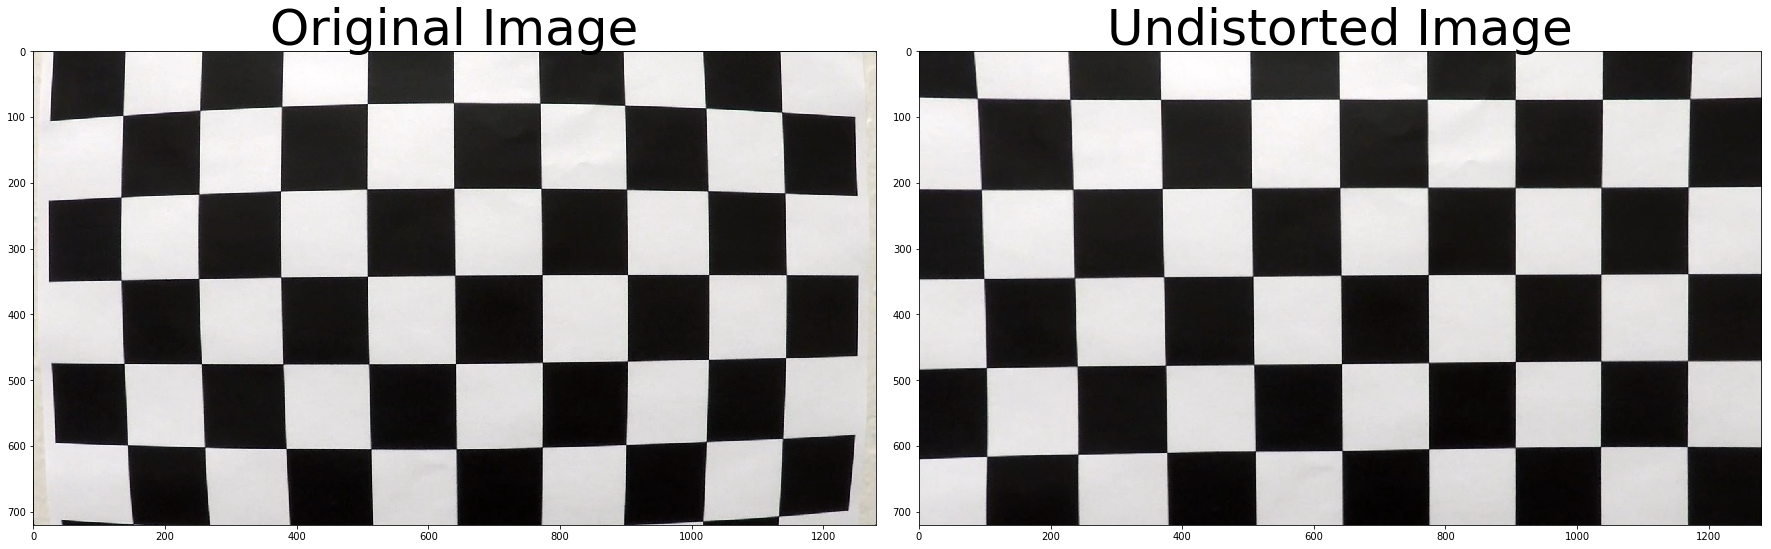

In [2]:
def calibration():

    # Read in an image
    images = glob.glob('camera_cal/calibration*.jpg')

    # prepare object points
    nx = 9
    ny = 6

    # Arrays to store object points and image points from all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points (for example, (3,1,0))
    objp= np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    for fname in images:

        # Read in each image
        image = mpimg.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        
            # Draw and display the corners
            #cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            #plt.imshow(image)
            #plt.show()

    image_test_calibration = mpimg.imread('test_images/test_image_calibration.jpg')

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, \
                                                       image_test_calibration.shape[1::-1], None, None)

    return mtx, dist, image_test_calibration

mtx, dist, image_test_calibration = calibration()

undistorted = cv2.undistort(image_test_calibration, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_test_calibration)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Distortion correction test image

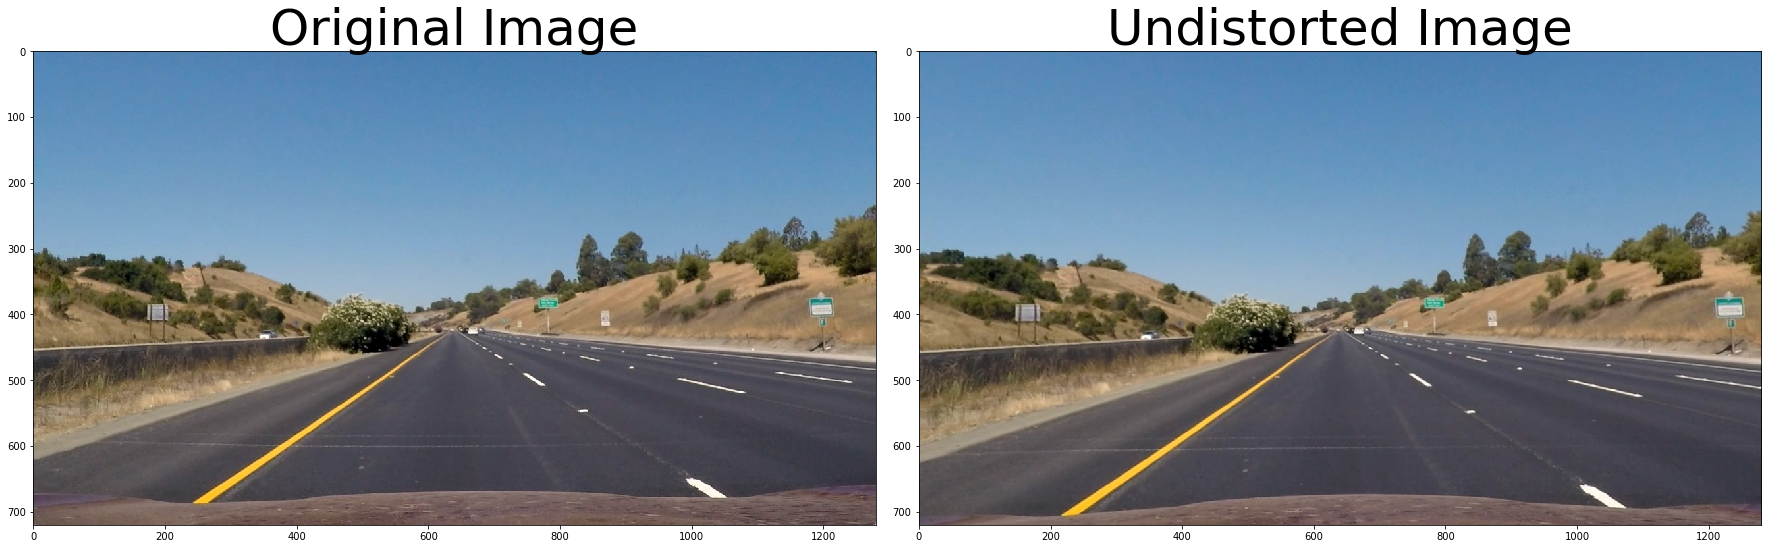

In [3]:
image_test = mpimg.imread('test_images/straight_lines1.jpg')

undistorted_test = cv2.undistort(image_test, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_test)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Color and gradient threshold

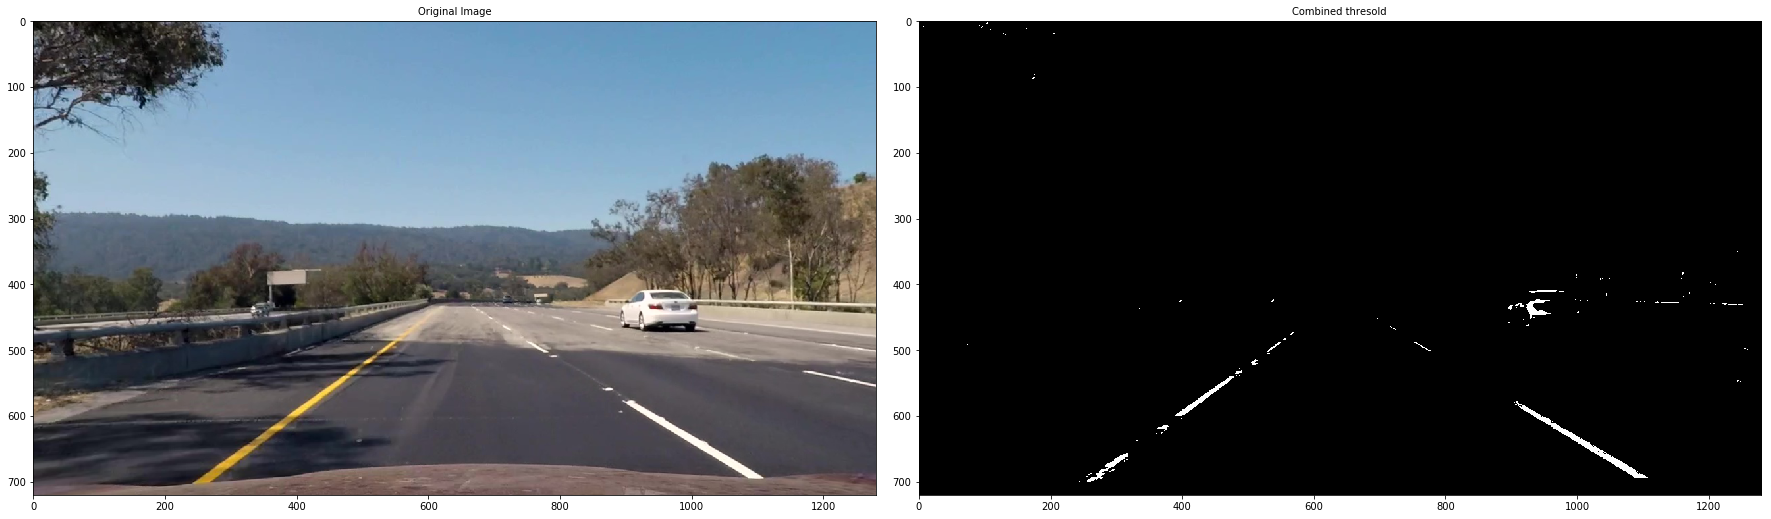

In [4]:
image = mpimg.imread('test_images/test7.jpg')

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return sbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxybinary = np.zeros_like(dir_grad)
    sxybinary[(dir_grad > thresh[0]) & (dir_grad < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxybinary

def h_threshold(img, h_thresh=(15,100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
	# Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    return h_binary
	
def s_threshold(img, s_thresh=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
	# Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

undist = cv2.undistort(image, mtx, dist, None, mtx)

# Apply each of the thresholding functions
grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(20, 100))
dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.7, 1.4))
h_binary = h_threshold(undist, h_thresh=(15,100))
s_binary = s_threshold(undist, s_thresh=(170,255))

combined_gradient = np.zeros_like(dir_binary)
combined_gradient[(grady == 1) & (dir_binary == 1)] = 1

combined_color = np.zeros_like(dir_binary)
combined_color[(h_binary == 1) & (s_binary == 1)] = 1

combined = np.zeros_like(combined_gradient)
combined[(combined_gradient == 1) | (combined_color == 1)] = 1

# Plot the result
f, (ax1, ax6) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=10)
"""
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Directional gradient X', fontsize=10)
ax3.imshow(grady, cmap='gray')
ax3.set_title('Directional gradient Y', fontsize=10)
ax4.imshow(mag_binary, cmap='gray')
ax4.set_title('Gradient magnitude', fontsize=10)
ax5.imshow(dir_binary, cmap='gray')
ax5.set_title('Thresholded Grad. Dir.', fontsize=10)
"""
ax6.imshow(combined_color, cmap='gray')
ax6.set_title('Combined thresold', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Perspective transform


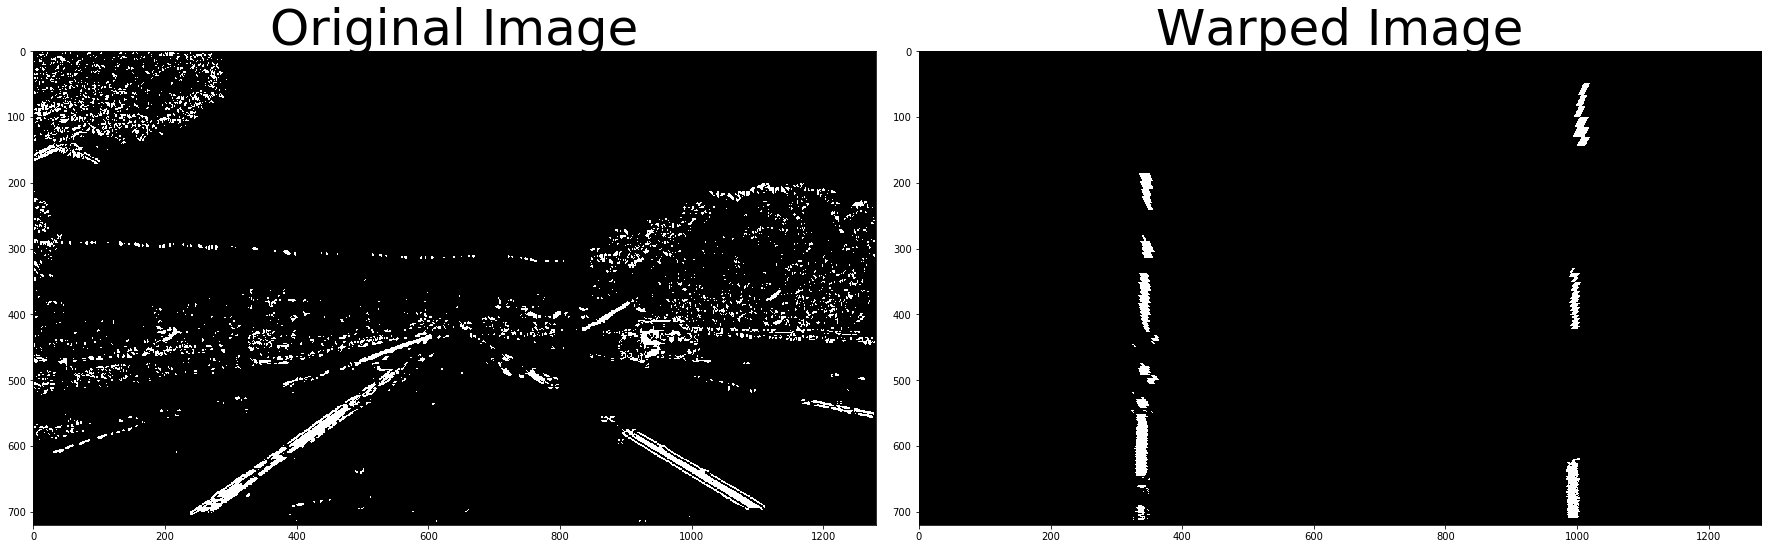

In [5]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, Minv

src = np.float32([[206,720], [1097,720], [580,460], [700,460]])
dst = np.float32([[320,720], [960,720], [320,0], [960,0]])

binary_warped, Minv = warper(combined_color, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Finding lines

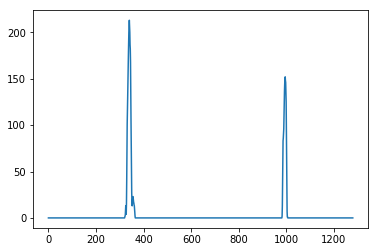

In [6]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

## Sliding window and fit polynomial

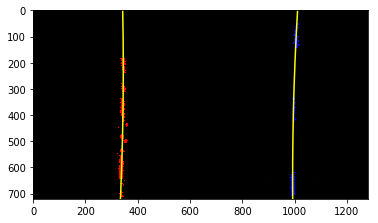

In [7]:
def slid_window_fit_poly(binary_warped, histogram):

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Visualization

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
    
    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty

out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty = \
slid_window_fit_poly(binary_warped, histogram)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

## New binary_warped

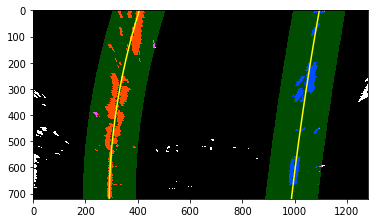

In [8]:
image = mpimg.imread('test_images/test5.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Apply each of the thresholding functions
grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(20, 100))
dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.7, 1.4))
h_binary = h_threshold(undist, h_thresh=(15,100))
s_binary = s_threshold(undist, s_thresh=(170,255))

combined_gradient = np.zeros_like(dir_binary)
combined_gradient[(grady == 1) & (dir_binary == 1)] = 1

combined_color = np.zeros_like(dir_binary)
combined_color[(h_binary == 1) & (s_binary == 1)] = 1

combined = np.zeros_like(combined_gradient)
combined[(combined_gradient == 1) | (combined_color == 1)] = 1

binary_warped, Minv = warper(combined, src, dst)


def new_slid_window_fit_poly(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,1, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,1, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty

result, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty = \
new_slid_window_fit_poly(binary_warped, left_fit, right_fit)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

## Measuring curvature

In [9]:
def meas_curvature(ploty, left_fit, right_fit, leftx, lefty, rightx, righty):

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_curverad, right_curverad

left_meas, right_meas = meas_curvature(ploty, left_fit, right_fit, leftx, lefty, rightx, righty)

2371.64862309 11830.9842433
778.899293539 m 3808.61755465 m


## View Lines

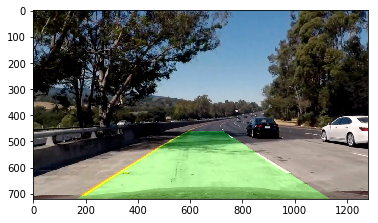

In [10]:
def view_lines(binary_warped, left_fitx, right_fitx, ploty, Minv, img, undist):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

result = view_lines(binary_warped, left_fitx, right_fitx, ploty, Minv, image, undist)

plt.imshow(result)
plt.show()

In [11]:
# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements


def pipeline(img):
        
    undist = cv2.undistort(img, pipeline.mtx, pipeline.dist, None, pipeline.mtx)

    # Apply each of the thresholding functions
    grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(40, 90))
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.8, 1.3))
    h_binary = h_threshold(undist, h_thresh=(15,100))
    s_binary = s_threshold(undist, s_thresh=(170,255))

    combined_gradient = np.zeros_like(dir_binary)
    combined_gradient[(grady == 1) & (dir_binary == 1)] = 1

    combined_color = np.zeros_like(dir_binary)
    combined_color[(h_binary == 1) & (s_binary == 1)] = 1

    combined = np.zeros_like(combined_gradient)
    combined[(combined_gradient == 1) | (combined_color == 1)] = 1
    
    binary_warped, Minv = warper(combined, src, dst)
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    if pipeline.first == True:
        out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, \
        righty = slid_window_fit_poly(binary_warped, histogram)
        
        pipeline.left_fit = left_fit
        pipeline.right_fit = right_fit
        pipeline.first = False
    else:
        result, ploty, pipeline.left_fit, pipeline.right_fit, left_fitx, right_fitx, leftx, lefty, rightx, \
        righty = new_slid_window_fit_poly(binary_warped, pipeline.left_fit, pipeline.right_fit)
    
    left_curverad, right_curverad = meas_curvature(ploty, pipeline.left_fit, pipeline.right_fit, leftx, lefty, rightx, righty)
    
    result = view_lines(binary_warped, left_fitx, right_fitx, ploty, Minv, img, undist)
    print(pipeline.first)
    return result

img = mpimg.imread('test_images/test2.jpg')

pipeline.first = True
pipeline.mtx = mtx
pipeline.dist = dist
pipeline(img)
    
        

2334.00112142 2528.45255903
766.516314414 m 666.524641112 m
False


array([[[ 96, 145, 188],
        [ 95, 144, 187],
        [ 94, 143, 186],
        ..., 
        [ 78, 130, 180],
        [ 78, 130, 180],
        [ 78, 130, 180]],

       [[ 95, 144, 187],
        [ 94, 143, 186],
        [ 94, 143, 186],
        ..., 
        [ 78, 130, 180],
        [ 78, 130, 180],
        [ 78, 130, 180]],

       [[ 95, 144, 187],
        [ 94, 143, 186],
        [ 93, 142, 185],
        ..., 
        [ 78, 130, 179],
        [ 78, 130, 179],
        [ 78, 130, 178]],

       ..., 
       [[ 97,  83,  96],
        [ 98,  84,  97],
        [ 98,  84,  98],
        ..., 
        [122, 174,  88],
        [121, 174,  87],
        [119, 172,  85]],

       [[ 97,  84,  96],
        [ 98,  85,  97],
        [ 99,  86,  98],
        ..., 
        [121, 154,  87],
        [122, 155,  88],
        [120, 153,  86]],

       [[100,  87,  97],
        [100,  87,  97],
        [101,  88,  98],
        ..., 
        [118, 124,  85],
        [120, 125,  86],
        [119, 124,

## Video


In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip('project_video.mp4').subclip(15,50)
clip1 = VideoFileClip('project_video.mp4')
project_clip = clip1.fl_image(pipeline)
%time project_clip.write_videofile(project_output, audio=False)

2351.94660851 5909.94567228
772.285277773 m 1922.58104118 m
False
[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

2351.94660851 5909.94567228
772.285277773 m 1922.58104118 m
False


  0%|                                                                                 | 1/1261 [00:00<06:48,  3.08it/s]

2189.34925094 8814.12031995
718.485025839 m 2770.54204391 m
False


  0%|▏                                                                                | 2/1261 [00:00<06:42,  3.12it/s]

2032.82819105 1567.290048
666.454907177 m 513.687513763 m
False


  0%|▏                                                                                | 3/1261 [00:00<06:38,  3.16it/s]

1856.23703824 1409.25572879
607.556072536 m 461.578925586 m
False


  0%|▎                                                                                | 4/1261 [00:01<06:39,  3.14it/s]

2033.42457292 1694.60947056
667.223862962 m 556.597968102 m
False


  0%|▎                                                                                | 5/1261 [00:01<06:45,  3.10it/s]

2002.02878785 3031.8539115
656.986109544 m 985.934469162 m
False


  0%|▍                                                                                | 6/1261 [00:01<06:35,  3.17it/s]

2051.72140752 4697.4607435
673.651922491 m 1511.06154004 m
False


  1%|▍                                                                                | 7/1261 [00:02<06:28,  3.22it/s]

2062.1520685 2039.52144078
677.221068064 m 442.875065877 m
False


  1%|▌                                                                                | 8/1261 [00:02<06:24,  3.26it/s]

2120.27619447 1824.03063331
696.411635977 m 385.78448051 m
False


  1%|▌                                                                                | 9/1261 [00:02<06:20,  3.29it/s]

2177.14858342 2102.3529453
715.019681601 m 513.916132205 m
False


  1%|▋                                                                               | 10/1261 [00:03<06:20,  3.29it/s]

2277.31784965 2257.3624225
747.644058461 m 582.049648473 m
False


  1%|▋                                                                               | 11/1261 [00:03<06:15,  3.33it/s]

2448.70433171 2475.91505608
802.747995482 m 686.424459034 m
False


  1%|▊                                                                               | 12/1261 [00:03<06:19,  3.29it/s]

2486.8581762 4719.88912027
814.956656113 m 1405.58524828 m
False


  1%|▊                                                                               | 13/1261 [00:04<06:25,  3.23it/s]

2621.42188164 10633.6451746
858.447135577 m 3272.69876015 m
False


  1%|▉                                                                               | 14/1261 [00:04<06:22,  3.26it/s]

2744.20456102 1694.79352768
898.415047575 m 556.480942274 m
False


  1%|▉                                                                               | 15/1261 [00:04<06:20,  3.27it/s]

2810.56408452 1616.67069863
919.831366573 m 530.154017867 m
False


  1%|█                                                                               | 16/1261 [00:04<06:20,  3.27it/s]

3063.23674285 2348.09687854
1001.18287427 m 761.629586724 m
False


  1%|█                                                                               | 17/1261 [00:05<06:26,  3.22it/s]

3027.39954027 4175.43575831
989.701419657 m 1328.63976399 m
False


  1%|█▏                                                                              | 18/1261 [00:05<06:26,  3.21it/s]

3485.07171863 7747.60314021
1135.35278332 m 2433.94931511 m
False


  2%|█▏                                                                              | 19/1261 [00:05<06:25,  3.22it/s]

3992.0489373 157181.54064
1296.5797988 m 47942.8726484 m
False


  2%|█▎                                                                              | 20/1261 [00:06<06:28,  3.20it/s]

4685.24191101 2318.58972459
1515.74528927 m 556.596242531 m
False


  2%|█▎                                                                              | 21/1261 [00:06<06:32,  3.16it/s]

5095.95196666 2950.02961969
1644.6612307 m 797.400617156 m
False


  2%|█▍                                                                              | 22/1261 [00:06<06:35,  3.14it/s]

4943.50403032 2713.37607568
1597.31171196 m 742.74067267 m
False


  2%|█▍                                                                              | 23/1261 [00:07<06:30,  3.17it/s]

4308.75282331 4986.53080211
1399.24601086 m 1480.24600366 m
False


  2%|█▌                                                                              | 24/1261 [00:07<06:39,  3.09it/s]

3709.20232982 100948.6255
1209.12674743 m 31710.5491227 m
False


  2%|█▌                                                                              | 25/1261 [00:07<06:45,  3.05it/s]

3952.98653296 24051.4184017
1287.44817384 m 7572.27724452 m
False


  2%|█▋                                                                              | 26/1261 [00:08<06:47,  3.03it/s]

3245.84643103 98570.8616943
1061.50795199 m 31349.103796 m
False


  2%|█▋                                                                              | 27/1261 [00:08<06:48,  3.02it/s]

3436.48253204 30737.5010991
1122.57970781 m 9894.26403861 m
False


  2%|█▊                                                                              | 28/1261 [00:08<06:40,  3.08it/s]

2958.92578182 2990.26435293
969.544326651 m 980.512277819 m
False


  2%|█▊                                                                              | 29/1261 [00:09<06:37,  3.10it/s]

2933.27120627 1489.15525608
961.99502834 m 488.165625418 m
False


  2%|█▉                                                                              | 30/1261 [00:09<06:27,  3.18it/s]

2591.79908934 1851.86450923
851.008745079 m 607.936882242 m
False


  2%|█▉                                                                              | 31/1261 [00:09<06:25,  3.19it/s]

2405.78108256 3540.18865264
790.186735424 m 1141.47033055 m
False


  3%|██                                                                              | 32/1261 [00:10<06:44,  3.04it/s]

2291.03950908 17198.2021162
752.45854414 m 5121.68959662 m
False


  3%|██                                                                              | 33/1261 [00:10<06:45,  3.03it/s]

2220.05369536 2427.38162127
729.113128778 m 581.916431474 m
False


  3%|██▏                                                                             | 34/1261 [00:10<06:37,  3.08it/s]

2060.53419271 2264.5886269
676.432441247 m 549.189914693 m
False


  3%|██▏                                                                             | 35/1261 [00:11<06:25,  3.18it/s]

1942.7772704 2656.16791259
637.405627415 m 696.870824753 m
False


  3%|██▎                                                                             | 36/1261 [00:11<06:22,  3.21it/s]

1893.03898883 3462.99053077
620.982077838 m 972.45270561 m
False


  3%|██▎                                                                             | 37/1261 [00:11<06:47,  3.00it/s]

1803.66116488 120327.071347
591.360306019 m 37034.407309 m
False


  3%|██▍                                                                             | 38/1261 [00:12<06:56,  2.94it/s]

1727.36088183 1397.98522773
565.932956774 m 459.088232088 m
False


  3%|██▍                                                                             | 39/1261 [00:12<06:48,  2.99it/s]

1637.46930493 1271.92847279
536.031848267 m 417.419953516 m
False


  3%|██▌                                                                             | 40/1261 [00:12<06:46,  3.00it/s]

1642.47659278 1377.40386368
537.908478775 m 452.402868296 m
False


  3%|██▌                                                                             | 41/1261 [00:13<06:40,  3.05it/s]

1633.64445693 1520.53251812
535.30659713 m 499.055309 m
False


  3%|██▋                                                                             | 42/1261 [00:13<06:29,  3.13it/s]

1637.5707548 1781.17110826
537.0233785 m 583.343627501 m
False


  3%|██▋                                                                             | 43/1261 [00:13<07:32,  2.69it/s]

1693.63223866 2239.97529701
555.902199098 m 731.022538313 m
False


  3%|██▊                                                                             | 44/1261 [00:14<07:28,  2.71it/s]

1696.08765085 2777.4657469
556.880588065 m 900.990156277 m
False


  4%|██▊                                                                             | 45/1261 [00:14<07:27,  2.72it/s]

1736.93848796 2739.02604906
570.453492524 m 652.063557136 m
False


  4%|██▉                                                                             | 46/1261 [00:14<07:14,  2.80it/s]

1778.33684137 2713.11988932
584.100116529 m 671.548714184 m
False


  4%|██▉                                                                             | 47/1261 [00:15<06:58,  2.90it/s]

1790.31205806 2997.75430678
588.028214512 m 784.546919641 m
False


  4%|███                                                                             | 48/1261 [00:15<06:48,  2.97it/s]

1955.14807927 2492.75032248
641.686350858 m 647.202137632 m
False


  4%|███                                                                             | 49/1261 [00:15<06:55,  2.91it/s]

2025.20304163 3401.01636386
664.239673864 m 948.277208439 m
False


  4%|███▏                                                                            | 50/1261 [00:16<06:48,  2.97it/s]

2129.57507486 32427.7902775
697.80313515 m 9948.88490396 m
False


  4%|███▏                                                                            | 51/1261 [00:16<06:35,  3.06it/s]

2220.03191816 3613.40356765
727.048600572 m 1163.12218794 m
False


  4%|███▎                                                                            | 52/1261 [00:16<06:23,  3.15it/s]

2210.45730579 1295.52901742
723.889942684 m 425.060707362 m
False


  4%|███▎                                                                            | 53/1261 [00:17<06:26,  3.12it/s]

2597.7074666 1248.49809985
848.491566366 m 409.871121224 m
False


  4%|███▍                                                                            | 54/1261 [00:17<06:25,  3.13it/s]

3177.02449766 1438.69867065
1032.21740478 m 472.421514927 m
False


  4%|███▍                                                                            | 55/1261 [00:17<06:20,  3.17it/s]

3817.43052369 1899.16505978
1234.78546571 m 620.935195407 m
False


  4%|███▌                                                                            | 56/1261 [00:18<06:18,  3.18it/s]

3864.35348338 2858.86106326
1249.96748158 m 920.620585884 m
False


  5%|███▌                                                                            | 57/1261 [00:18<06:17,  3.19it/s]

4002.25446036 10451.93782
1294.92037962 m 2982.99040448 m
False


  5%|███▋                                                                            | 58/1261 [00:18<06:11,  3.24it/s]

4067.28661639 3269.24103079
1317.41275918 m 816.6958662 m
False


  5%|███▋                                                                            | 59/1261 [00:18<06:12,  3.23it/s]

3790.87546512 13820.5406753
1231.39727081 m 3970.60595309 m
False


  5%|███▊                                                                            | 60/1261 [00:19<06:10,  3.24it/s]

3574.52668621 27779.1450465
1164.43217267 m 8181.21919105 m
False


  5%|███▊                                                                            | 61/1261 [00:19<06:16,  3.18it/s]

3150.93716789 1712.60832273
1030.30025385 m 559.466252308 m
False


  5%|███▉                                                                            | 62/1261 [00:19<06:34,  3.04it/s]

3557.48962126 1964.7803047
1161.55440279 m 640.033903874 m
False


  5%|███▉                                                                            | 63/1261 [00:20<06:28,  3.08it/s]

3329.8055123 1355.03994112
1089.42408361 m 445.021013302 m
False


  5%|████                                                                            | 64/1261 [00:20<06:24,  3.11it/s]

3054.59323912 1379.85313158
1000.95639064 m 453.205248469 m
False


  5%|████                                                                            | 65/1261 [00:20<06:19,  3.15it/s]

2674.7930282 1993.97118625
878.06501103 m 648.365803403 m
False


  5%|████▏                                                                           | 66/1261 [00:21<06:16,  3.18it/s]

2929.31309287 2690.49882843
961.169181363 m 867.106244327 m
False


  5%|████▎                                                                           | 67/1261 [00:21<06:17,  3.17it/s]

2571.4756426 3894.32973113
844.310277361 m 1243.53144748 m
False


  5%|████▎                                                                           | 68/1261 [00:21<06:16,  3.17it/s]

2330.77186073 6113.00165389
765.550042839 m 1920.24493195 m
False


  5%|████▍                                                                           | 69/1261 [00:22<06:12,  3.20it/s]

2332.04696598 18989.2963969
765.964495471 m 5850.54473384 m
False


  6%|████▍                                                                           | 70/1261 [00:22<06:10,  3.22it/s]

2745.17275703 2489.73916276
901.073049089 m 596.211388775 m
False


  6%|████▌                                                                           | 71/1261 [00:22<06:16,  3.16it/s]

3010.5824048 2214.33168092
986.838217625 m 535.637976218 m
False


  6%|████▌                                                                           | 72/1261 [00:23<06:14,  3.17it/s]

2836.76883626 2643.64259766
930.396899929 m 698.253329363 m
False


  6%|████▋                                                                           | 73/1261 [00:23<06:20,  3.12it/s]

3094.66897593 3035.17458095
1013.184695 m 843.939714805 m
False


  6%|████▋                                                                           | 74/1261 [00:23<06:13,  3.17it/s]

2935.43244006 2487.15058897
961.156358452 m 684.393723046 m
False


  6%|████▊                                                                           | 75/1261 [00:24<06:08,  3.22it/s]

4540.99640318 2545.26182709
1476.99656205 m 832.788644686 m
False


  6%|████▊                                                                           | 76/1261 [00:24<06:05,  3.24it/s]

4131.31510699 9441.40566964
1343.656938 m 3035.39086547 m
False


  6%|████▉                                                                           | 77/1261 [00:24<06:09,  3.21it/s]

4063.00456164 1723.54880534
1321.38913077 m 565.599210263 m
False


  6%|████▉                                                                           | 78/1261 [00:24<06:06,  3.23it/s]

5533.50906686 1370.3704848
1794.06918895 m 447.345268004 m
False


  6%|█████                                                                           | 79/1261 [00:25<06:09,  3.20it/s]

5221.63723612 1477.00763096
1696.74129981 m 483.553103216 m
False


  6%|█████                                                                           | 80/1261 [00:25<06:08,  3.21it/s]

6993.15910849 1866.06316915
2266.93176344 m 612.895852871 m
False


  6%|█████▏                                                                          | 81/1261 [00:25<06:06,  3.22it/s]

7162.09079721 2371.32411332
2323.83906151 m 777.370225887 m
False


  7%|█████▏                                                                          | 82/1261 [00:26<06:31,  3.01it/s]

5173.3493441 8485.12913936
1686.5539068 m 2687.60994808 m
False


  7%|█████▎                                                                          | 83/1261 [00:26<07:22,  2.66it/s]

6193.21091359 2812.44544657
2013.47008596 m 743.472191839 m
False


  7%|█████▎                                                                          | 84/1261 [00:27<07:51,  2.49it/s]

5564.41733299 2489.4293767
1814.71768782 m 653.323557768 m
False


  7%|█████▍                                                                          | 85/1261 [00:27<07:52,  2.49it/s]

3952.9115619 2192.96705119
1294.3101783 m 575.881017796 m
False


  7%|█████▍                                                                          | 86/1261 [00:27<07:28,  2.62it/s]

3429.75869864 2332.6439485
1125.80987384 m 634.599851036 m
False


  7%|█████▌                                                                          | 87/1261 [00:28<07:09,  2.73it/s]

2911.38532098 4294.12817271
956.208799839 m 1266.86599315 m
False


  7%|█████▌                                                                          | 88/1261 [00:28<07:07,  2.75it/s]

2600.7634621 1615.90594966
853.634720125 m 530.485173423 m
False


  7%|█████▋                                                                          | 89/1261 [00:29<07:15,  2.69it/s]

2532.46830859 1350.51117849
830.358514103 m 443.081260209 m
False


  7%|█████▋                                                                          | 90/1261 [00:29<06:59,  2.79it/s]

2582.80952424 1514.95543949
847.270664449 m 497.475205286 m
False


  7%|█████▊                                                                          | 91/1261 [00:29<06:51,  2.85it/s]

2444.90618781 2016.01167828
801.816739264 m 660.739175933 m
False


  7%|█████▊                                                                          | 92/1261 [00:30<06:35,  2.95it/s]

2482.08929146 2935.73509927
814.142355585 m 953.257639776 m
False


  7%|█████▉                                                                          | 93/1261 [00:30<06:22,  3.05it/s]

2400.49577553 4737.75773446
787.18988154 m 1519.59377033 m
False


  7%|█████▉                                                                          | 94/1261 [00:30<06:24,  3.04it/s]

2404.33819337 6509.20747397
788.306364397 m 2081.86800966 m
False


  8%|██████                                                                          | 95/1261 [00:30<06:18,  3.08it/s]

2346.20908045 2540.35393357
769.054103121 m 639.392681561 m
False


  8%|██████                                                                          | 96/1261 [00:31<06:13,  3.12it/s]

2461.37739752 2078.15672729
807.567553465 m 497.473261367 m
False


  8%|██████▏                                                                         | 97/1261 [00:31<06:14,  3.11it/s]

2444.72628708 3970.98925778
802.403303742 m 1147.03648457 m
False


  8%|██████▏                                                                         | 98/1261 [00:31<06:22,  3.04it/s]

2472.4752702 2718.11252136
811.562007031 m 762.011828236 m
False


  8%|██████▎                                                                         | 99/1261 [00:32<06:55,  2.79it/s]

2561.43979895 2666.27712806
841.146215288 m 762.977026839 m
False


  8%|██████▎                                                                        | 100/1261 [00:32<08:09,  2.37it/s]

2595.80545591 4383.52229212
852.454254248 m 1423.77496114 m
False


  8%|██████▎                                                                        | 101/1261 [00:33<07:45,  2.49it/s]

2933.3975241 1657.00214587
963.473431677 m 543.38748266 m
False


  8%|██████▍                                                                        | 102/1261 [00:33<07:18,  2.64it/s]

2764.60221263 1292.23049852
908.0355541 m 420.567505837 m
False


  8%|██████▍                                                                        | 103/1261 [00:33<06:56,  2.78it/s]

2778.7302131 1386.13216465
912.619029835 m 453.228246739 m
False


  8%|██████▌                                                                        | 104/1261 [00:34<06:33,  2.94it/s]

3035.63211039 1452.11746815
996.969811862 m 474.84024249 m
False


  8%|██████▌                                                                        | 105/1261 [00:34<06:21,  3.03it/s]

3453.43906869 1698.72169506
1133.29334794 m 557.002848868 m
False


  8%|██████▋                                                                        | 106/1261 [00:34<06:16,  3.07it/s]

3449.97625638 1955.86887522
1132.04942855 m 641.997862407 m
False


  8%|██████▋                                                                        | 107/1261 [00:35<06:12,  3.10it/s]

2977.99929976 5446.34507881
978.081590127 m 1754.92315133 m
False


  9%|██████▊                                                                        | 108/1261 [00:35<06:13,  3.09it/s]

2671.1735364 2498.52219164
877.328284186 m 644.269152272 m
False


  9%|██████▊                                                                        | 109/1261 [00:35<06:08,  3.13it/s]

2561.37729039 2964.8001177
841.099116597 m 822.209672918 m
False


  9%|██████▉                                                                        | 110/1261 [00:36<06:05,  3.15it/s]

2551.06609353 2442.08609932
837.753844094 m 661.469392773 m
False


  9%|██████▉                                                                        | 111/1261 [00:36<06:04,  3.15it/s]

2587.37625633 11403.8326251
849.770497513 m 3566.32532971 m
False


  9%|███████                                                                        | 112/1261 [00:36<06:09,  3.11it/s]

2451.8305267 3499.28528909
805.030010563 m 1035.97706133 m
False


  9%|███████                                                                        | 113/1261 [00:37<06:05,  3.14it/s]

2275.83277498 11889.6961917
746.719542233 m 3733.23677402 m
False


  9%|███████▏                                                                       | 114/1261 [00:37<06:05,  3.14it/s]

2106.40452733 1527.42675268
690.239063763 m 499.554514561 m
False


  9%|███████▏                                                                       | 115/1261 [00:37<06:00,  3.18it/s]

2026.32675435 1162.27929332
663.583578369 m 375.815764879 m
False


  9%|███████▎                                                                       | 116/1261 [00:38<05:56,  3.21it/s]

2100.64436853 1234.43741899
688.440800451 m 401.682586726 m
False


  9%|███████▎                                                                       | 117/1261 [00:38<05:52,  3.25it/s]

2172.08639319 1591.51653102
712.651653769 m 522.513433839 m
False


  9%|███████▍                                                                       | 118/1261 [00:38<05:49,  3.27it/s]

2236.40913284 1898.22050028
734.13186278 m 623.17650977 m
False


  9%|███████▍                                                                       | 119/1261 [00:38<05:49,  3.27it/s]

2072.63019804 2492.68850066
679.745664951 m 813.306866053 m
False


 10%|███████▌                                                                       | 120/1261 [00:39<05:46,  3.29it/s]

2167.24597032 7204.43066834
711.391265726 m 2253.26944279 m
False


 10%|███████▌                                                                       | 121/1261 [00:39<05:44,  3.30it/s]

2045.86684109 4632.92745076
671.201888671 m 1273.76563523 m
False


 10%|███████▋                                                                       | 122/1261 [00:39<05:47,  3.28it/s]

1954.51516238 13665.0204944
640.74364702 m 4026.72636466 m
False


 10%|███████▋                                                                       | 123/1261 [00:40<05:45,  3.29it/s]

1933.41502782 7870.00455551
633.712499368 m 2306.52064704 m
False


 10%|███████▊                                                                       | 124/1261 [00:40<05:58,  3.17it/s]

1873.01109373 1875.0499154
613.655962852 m 614.366384967 m
False


 10%|███████▊                                                                       | 125/1261 [00:40<06:02,  3.13it/s]

1992.28403331 5264.27397051
653.752187282 m 1682.25009455 m
False


 10%|███████▉                                                                       | 126/1261 [00:41<06:01,  3.14it/s]

1952.18713922 1283.38860798
640.488748109 m 420.347824939 m
False


 10%|███████▉                                                                       | 127/1261 [00:41<06:10,  3.06it/s]

2025.89381238 1255.57245945
665.134832648 m 410.92640675 m
False


 10%|████████                                                                       | 128/1261 [00:41<06:11,  3.05it/s]

1972.44398732 1531.01899729
647.326529812 m 502.509385628 m
False


 10%|████████                                                                       | 129/1261 [00:42<06:28,  2.91it/s]

2088.59249837 1937.28930623
685.849124842 m 633.501113061 m
False


 10%|████████▏                                                                      | 130/1261 [00:42<06:29,  2.90it/s]

2206.17734438 2291.36198224
724.624944422 m 745.248252048 m
False


 10%|████████▏                                                                      | 131/1261 [00:42<06:35,  2.86it/s]

2145.31618921 2906.53028736
704.606980495 m 935.955595695 m
False


 10%|████████▎                                                                      | 132/1261 [00:43<06:31,  2.88it/s]

2259.34549924 3105.92510444
742.077629429 m 997.679478268 m
False


 11%|████████▎                                                                      | 133/1261 [00:43<06:17,  2.99it/s]

2366.41361485 4142.6717544
777.114468585 m 1080.06692459 m
False


 11%|████████▍                                                                      | 134/1261 [00:43<06:15,  3.00it/s]

2431.94310758 3511.71455057
798.469061069 m 924.221045553 m
False


 11%|████████▍                                                                      | 135/1261 [00:44<06:08,  3.05it/s]

2606.4610757 3206.33398825
855.270103334 m 852.360607335 m
False


 11%|████████▌                                                                      | 136/1261 [00:44<06:03,  3.10it/s]

2744.38162784 5486.39158482
900.027923894 m 1586.34220543 m
False


 11%|████████▌                                                                      | 137/1261 [00:44<05:59,  3.12it/s]

2898.71488357 3655.27100086
950.007178595 m 1044.77096569 m
False


 11%|████████▋                                                                      | 138/1261 [00:45<05:53,  3.18it/s]

2550.91136765 5031.89297443
837.28550412 m 1490.21344592 m
False


 11%|████████▋                                                                      | 139/1261 [00:45<05:47,  3.23it/s]

3144.54236765 2132.23095873
1029.35764286 m 593.028659907 m
False


 11%|████████▊                                                                      | 140/1261 [00:45<05:48,  3.22it/s]

3066.21404535 2827.93584023
1004.3219533 m 923.038749033 m
False


 11%|████████▊                                                                      | 141/1261 [00:46<05:46,  3.23it/s]

3098.87652828 1741.68779305
1015.24923662 m 571.946813982 m
False


 11%|████████▉                                                                      | 142/1261 [00:46<05:55,  3.14it/s]

3138.3974712 2332.08637724
1028.60481508 m 761.039915353 m
False


 11%|████████▉                                                                      | 143/1261 [00:46<05:50,  3.19it/s]

3187.27714086 3222.88763992
1044.72380058 m 1044.76005483 m
False


 11%|█████████                                                                      | 144/1261 [00:46<05:48,  3.20it/s]

3134.06077361 4293.60795526
1027.57500083 m 1382.2634954 m
False


 11%|█████████                                                                      | 145/1261 [00:47<05:48,  3.20it/s]

2955.8712489 9875.645647
970.018372423 m 3097.08832507 m
False


 12%|█████████▏                                                                     | 146/1261 [00:47<05:44,  3.24it/s]

3146.75446332 2740.09390392
1032.13027059 m 710.644149433 m
False


 12%|█████████▏                                                                     | 147/1261 [00:47<05:43,  3.25it/s]

3029.72847959 3095.41969152
994.547751498 m 825.889140915 m
False


 12%|█████████▎                                                                     | 148/1261 [00:48<05:40,  3.27it/s]

2933.93506969 4513.57049327
963.345691562 m 1290.24172537 m
False


 12%|█████████▎                                                                     | 149/1261 [00:48<05:40,  3.27it/s]

3668.33120296 3214.29054658
1201.8212777 m 914.155112168 m
False


 12%|█████████▍                                                                     | 150/1261 [00:48<05:44,  3.23it/s]

3513.62155641 2614.69570902
1151.38533404 m 855.316331167 m
False


 12%|█████████▍                                                                     | 151/1261 [00:49<05:52,  3.15it/s]

4046.35315918 1593.96004225
1323.90583139 m 522.81568539 m
False


 12%|█████████▌                                                                     | 152/1261 [00:49<05:47,  3.19it/s]

3806.363813 1245.72574874
1246.72371628 m 406.746095045 m
False


 12%|█████████▌                                                                     | 153/1261 [00:49<05:45,  3.21it/s]

4044.45234982 1364.07954408
1323.16655388 m 446.569278665 m
False


 12%|█████████▋                                                                     | 154/1261 [00:50<05:41,  3.24it/s]

4374.55709184 1582.47569163
1428.79410931 m 519.585825903 m
False


 12%|█████████▋                                                                     | 155/1261 [00:50<05:37,  3.28it/s]

4105.61616545 2086.58034472
1341.87397116 m 684.263324631 m
False


 12%|█████████▊                                                                     | 156/1261 [00:50<05:36,  3.29it/s]

3829.06871052 2636.86961652
1252.26860532 m 860.815667211 m
False


 12%|█████████▊                                                                     | 157/1261 [00:50<05:38,  3.26it/s]

3320.61916406 5398.55794689
1088.49536143 m 1721.14275658 m
False


 13%|█████████▉                                                                     | 158/1261 [00:51<05:39,  3.25it/s]

3306.65587661 2234.71433552
1083.54815002 m 516.091551357 m
False


 13%|█████████▉                                                                     | 159/1261 [00:51<05:41,  3.22it/s]

2918.64832113 2640.09381606
957.672640173 m 669.095596947 m
False


 13%|██████████                                                                     | 160/1261 [00:51<05:42,  3.22it/s]

2790.33783205 2335.28141704
915.713934788 m 589.890028784 m
False


 13%|██████████                                                                     | 161/1261 [00:52<05:42,  3.21it/s]

2760.32914216 1986.11784478
905.602002032 m 493.384388064 m
False


 13%|██████████▏                                                                    | 162/1261 [00:52<05:39,  3.24it/s]

2612.77897138 1953.78905217
857.468119907 m 506.000666374 m
False


 13%|██████████▏                                                                    | 163/1261 [00:52<05:42,  3.20it/s]

2419.96817153 8622.76954161
794.681833981 m 2612.1593984 m
False


 13%|██████████▎                                                                    | 164/1261 [00:53<05:40,  3.22it/s]

2455.73672233 1537.90125766
806.402907046 m 505.041140359 m
False


 13%|██████████▎                                                                    | 165/1261 [00:53<05:36,  3.26it/s]

2464.60486081 1599.25199334
809.206442076 m 525.036707208 m
False


 13%|██████████▍                                                                    | 166/1261 [00:53<05:32,  3.29it/s]

2345.21210694 2396.84576891
770.241329369 m 777.453342746 m
False


 13%|██████████▍                                                                    | 167/1261 [00:54<05:36,  3.26it/s]

2880.96623696 2814.17900877
943.935092982 m 912.701158425 m
False


 13%|██████████▌                                                                    | 168/1261 [00:54<05:37,  3.24it/s]

2881.46559854 3309.09237081
943.595894588 m 1070.76284074 m
False


 13%|██████████▌                                                                    | 169/1261 [00:54<05:34,  3.27it/s]

2751.48764545 3500.51942375
900.904175444 m 1134.50030887 m
False


 13%|██████████▋                                                                    | 170/1261 [00:54<05:34,  3.26it/s]

2674.83578602 107760.270566
875.77823113 m 32876.975109 m
False


 14%|██████████▋                                                                    | 171/1261 [00:55<05:39,  3.21it/s]

2650.75746591 5761.11912515
867.730895556 m 1652.9623944 m
False


 14%|██████████▊                                                                    | 172/1261 [00:55<05:38,  3.22it/s]

3019.18620089 11095.5391365
986.400333176 m 3316.25253937 m
False


 14%|██████████▊                                                                    | 173/1261 [00:55<05:31,  3.28it/s]

3174.83999498 11678.0042043
1037.28903692 m 3501.92476226 m
False


 14%|██████████▉                                                                    | 174/1261 [00:56<05:36,  3.23it/s]

3216.99217399 2656.79942016
1051.41297132 m 863.429477288 m
False


 14%|██████████▉                                                                    | 175/1261 [00:56<05:38,  3.21it/s]

3142.70867396 943.079637825
1028.04266284 m 300.452684728 m
False


 14%|███████████                                                                    | 176/1261 [00:56<05:46,  3.13it/s]

3250.99807407 997.510411198
1061.95118714 m 319.760913764 m
False


 14%|███████████                                                                    | 177/1261 [00:57<05:59,  3.02it/s]

3376.3269935 1021.64184954
1102.76962828 m 329.148202845 m
False


 14%|███████████▏                                                                   | 178/1261 [00:57<06:03,  2.98it/s]

3387.46041594 1173.12556178
1106.88925049 m 382.757225604 m
False


 14%|███████████▏                                                                   | 179/1261 [00:57<06:05,  2.96it/s]

3432.87633441 1179.85190717
1121.79498598 m 385.064342459 m
False


 14%|███████████▎                                                                   | 180/1261 [00:58<06:12,  2.90it/s]

2899.10394477 1489.98995558
950.759665813 m 489.38725228 m
False


 14%|███████████▎                                                                   | 181/1261 [00:58<06:15,  2.88it/s]

2787.53311233 1618.50138044
914.615146773 m 531.470440533 m
False


 14%|███████████▍                                                                   | 182/1261 [00:59<06:18,  2.85it/s]

2501.35520907 1923.82233981
821.554821822 m 627.654026082 m
False


 15%|███████████▍                                                                   | 183/1261 [00:59<06:22,  2.82it/s]

2240.77833074 9700.6249623
735.749380167 m 2659.69927256 m
False


 15%|███████████▌                                                                   | 184/1261 [00:59<06:24,  2.80it/s]

1969.41980391 20194.338205
645.400906305 m 5902.26904381 m
False


 15%|███████████▌                                                                   | 185/1261 [01:00<06:21,  2.82it/s]

1683.05022873 1879.50382189
548.682696762 m 604.581481678 m
False


 15%|███████████▋                                                                   | 186/1261 [01:00<06:22,  2.81it/s]

1608.01264413 1017.80006361
523.179916386 m 333.911210053 m
False


 15%|███████████▋                                                                   | 187/1261 [01:00<06:16,  2.85it/s]

1512.46612153 1156.28291683
490.568015077 m 379.302370425 m
False


 15%|███████████▊                                                                   | 188/1261 [01:01<06:24,  2.79it/s]

1528.95341237 1245.74745951
496.646551382 m 407.907580079 m
False


 15%|███████████▊                                                                   | 189/1261 [01:01<06:25,  2.78it/s]

1539.11330968 1611.7463048
500.697347856 m 521.550566895 m
False


 15%|███████████▉                                                                   | 190/1261 [01:01<06:26,  2.77it/s]

1551.35412734 1975.33449596
505.191070558 m 631.125768517 m
False


 15%|███████████▉                                                                   | 191/1261 [01:02<06:19,  2.82it/s]

1708.96124844 1936.28163039
559.416808407 m 622.244690579 m
False


 15%|████████████                                                                   | 192/1261 [01:02<06:18,  2.82it/s]

1722.96121783 2114.92661368
564.34399826 m 674.745309394 m
False


 15%|████████████                                                                   | 193/1261 [01:02<06:17,  2.83it/s]

1882.77757029 2288.38149033
617.859788005 m 729.242363788 m
False


 15%|████████████▏                                                                  | 194/1261 [01:03<06:17,  2.82it/s]

1936.09185034 2796.70476074
635.598127116 m 881.806315808 m
False


 15%|████████████▏                                                                  | 195/1261 [01:03<06:25,  2.76it/s]

2164.43409638 7011.27656454
710.869122036 m 1906.25329271 m
False


 16%|████████████▎                                                                  | 196/1261 [01:04<06:25,  2.76it/s]

2390.35147737 4070.71304199
784.246937445 m 1095.93304891 m
False


 16%|████████████▎                                                                  | 197/1261 [01:04<06:26,  2.76it/s]

2663.53280365 4160.72247935
871.682942816 m 1173.3277619 m
False


 16%|████████████▍                                                                  | 198/1261 [01:04<06:22,  2.78it/s]

2799.14506523 3872.60067335
914.117596862 m 1120.96305828 m
False


 16%|████████████▍                                                                  | 199/1261 [01:05<06:19,  2.80it/s]

2765.83940116 4270.39719063
903.668119404 m 1253.83273339 m
False


 16%|████████████▌                                                                  | 200/1261 [01:05<06:20,  2.79it/s]

2775.36302546 2606.69614937
906.292463327 m 739.870407693 m
False


 16%|████████████▌                                                                  | 201/1261 [01:05<06:34,  2.69it/s]

2856.87217058 2527.89404947
933.322894451 m 723.070477602 m
False


 16%|████████████▋                                                                  | 202/1261 [01:06<06:32,  2.70it/s]

2522.04901127 4414.72131562
826.53913336 m 1426.45947167 m
False


 16%|████████████▋                                                                  | 203/1261 [01:06<06:37,  2.66it/s]

2863.33804718 1626.93568028
936.068751058 m 534.348575717 m
False


 16%|████████████▊                                                                  | 204/1261 [01:06<06:35,  2.67it/s]

2802.00128306 1606.82560124
917.111741221 m 527.361516536 m
False


 16%|████████████▊                                                                  | 205/1261 [01:07<06:34,  2.68it/s]

2946.74477556 1984.29932818
963.884595753 m 648.292347287 m
False


 16%|████████████▉                                                                  | 206/1261 [01:07<06:34,  2.68it/s]

2685.3924343 2340.8650468
880.275474603 m 755.677883343 m
False


 16%|████████████▉                                                                  | 207/1261 [01:08<06:36,  2.66it/s]

2554.66248756 8107.09129239
838.223711124 m 2183.53010518 m
False


 16%|█████████████                                                                  | 208/1261 [01:08<06:32,  2.68it/s]

2498.78344323 5240.14670389
819.848193178 m 1395.29219991 m
False


 17%|█████████████                                                                  | 209/1261 [01:08<06:25,  2.73it/s]

2592.62335627 5935.06687684
850.159263503 m 1647.46574777 m
False


 17%|█████████████▏                                                                 | 210/1261 [01:09<06:26,  2.72it/s]

2616.09334439 7091.28901664
857.452914374 m 2051.68635206 m
False


 17%|█████████████▏                                                                 | 211/1261 [01:09<06:29,  2.70it/s]

2517.89566194 9463.00843993
825.597792923 m 2794.79439589 m
False


 17%|█████████████▎                                                                 | 212/1261 [01:09<06:27,  2.71it/s]

2323.06644505 2558.07124069
762.460748541 m 684.135300954 m
False


 17%|█████████████▎                                                                 | 213/1261 [01:10<06:19,  2.76it/s]

2216.69788614 2692.0341841
727.793294475 m 741.596213318 m
False


 17%|█████████████▍                                                                 | 214/1261 [01:10<06:07,  2.85it/s]

2146.05131067 1666.28831605
704.688778392 m 546.150507467 m
False


 17%|█████████████▍                                                                 | 215/1261 [01:10<06:05,  2.86it/s]

2000.87074538 1389.81993414
657.181636527 m 456.366961193 m
False


 17%|█████████████▌                                                                 | 216/1261 [01:11<05:56,  2.93it/s]

2181.88544239 1925.01119051
716.196650118 m 627.210380408 m
False


 17%|█████████████▌                                                                 | 217/1261 [01:11<06:00,  2.90it/s]

2283.65370912 2184.25439576
749.045661147 m 711.002607989 m
False


 17%|█████████████▋                                                                 | 218/1261 [01:11<06:00,  2.89it/s]

2139.41246699 3857.27130726
702.251883665 m 1223.49444159 m
False


 17%|█████████████▋                                                                 | 219/1261 [01:12<05:57,  2.91it/s]

2211.56921962 10315.9842636
725.352145497 m 3178.28301447 m
False


 17%|█████████████▊                                                                 | 220/1261 [01:12<05:53,  2.95it/s]

2426.254185 2392.22786239
794.067607102 m 544.991786822 m
False


 18%|█████████████▊                                                                 | 221/1261 [01:12<05:49,  2.98it/s]

2593.35573004 2663.23154592
847.574765417 m 664.697377215 m
False


 18%|█████████████▉                                                                 | 222/1261 [01:13<05:45,  3.01it/s]

2711.91791238 3556.7103934
885.047996237 m 967.833090613 m
False


 18%|█████████████▉                                                                 | 223/1261 [01:13<06:41,  2.59it/s]

2567.33786411 2658.59049473
839.534213059 m 696.82963406 m
False


 18%|██████████████                                                                 | 224/1261 [01:14<06:45,  2.56it/s]

2724.64717653 1685.12283139
889.461036319 m 396.624279801 m
False


 18%|██████████████                                                                 | 225/1261 [01:14<06:28,  2.67it/s]

2785.76406706 4191.10446594
910.250995628 m 1333.40288384 m
False


 18%|██████████████▏                                                                | 226/1261 [01:14<06:27,  2.67it/s]

2834.59652713 1421.83370307
925.929269067 m 466.993946705 m
False


 18%|██████████████▏                                                                | 227/1261 [01:15<06:14,  2.76it/s]

3003.56121334 1545.66220658
979.443015131 m 507.262526243 m
False


 18%|██████████████▎                                                                | 228/1261 [01:15<06:55,  2.49it/s]

3041.13372115 1856.40329525
991.879990116 m 607.401695274 m
False


 18%|██████████████▎                                                                | 229/1261 [01:16<07:08,  2.41it/s]

3617.42636715 2222.70390614
1173.56334058 m 725.961066279 m
False


 18%|██████████████▍                                                                | 230/1261 [01:16<07:29,  2.30it/s]

2833.96088254 3242.52637712
924.128404765 m 1047.48325992 m
False


 18%|██████████████▍                                                                | 231/1261 [01:17<07:02,  2.44it/s]

3198.53531112 4531.04325309
1038.36614351 m 1451.30153503 m
False


 18%|██████████████▌                                                                | 232/1261 [01:17<06:42,  2.56it/s]

2979.51959836 4761.52247678
969.178546938 m 1319.69623267 m
False


 18%|██████████████▌                                                                | 233/1261 [01:17<06:27,  2.65it/s]

3113.02982122 6878.80080815
1011.42741265 m 1988.7482434 m
False


 19%|██████████████▋                                                                | 234/1261 [01:18<06:11,  2.77it/s]

3146.50323807 5687.62393777
1022.61979411 m 1642.40038288 m
False


 19%|██████████████▋                                                                | 235/1261 [01:18<06:01,  2.84it/s]

3047.80212425 9293.41771725
992.840553207 m 2900.30830124 m
False


 19%|██████████████▊                                                                | 236/1261 [01:18<05:49,  2.94it/s]

3345.32789773 2653.60489838
1088.65487534 m 718.383463829 m
False


 19%|██████████████▊                                                                | 237/1261 [01:19<05:41,  3.00it/s]

3227.44106398 1748.27385357
1052.36891517 m 572.935418768 m
False


 19%|██████████████▉                                                                | 238/1261 [01:19<05:53,  2.89it/s]

3482.47408323 1219.54639133
1136.46342617 m 400.141220256 m
False


 19%|██████████████▉                                                                | 239/1261 [01:19<06:00,  2.84it/s]

3540.01444784 1416.75523306
1155.77893318 m 465.234126308 m
False


 19%|███████████████                                                                | 240/1261 [01:20<06:27,  2.64it/s]

3281.00107534 1604.59319476
1072.23068711 m 525.964956456 m
False


 19%|███████████████                                                                | 241/1261 [01:20<06:37,  2.56it/s]

3250.21672566 1791.50009438
1062.3533113 m 587.038198263 m
False


 19%|███████████████▏                                                               | 242/1261 [01:21<06:48,  2.49it/s]

2891.47245137 1988.2113706
947.689903632 m 648.486895362 m
False


 19%|███████████████▏                                                               | 243/1261 [01:21<07:33,  2.24it/s]

2716.21892947 2274.26289488
890.706400541 m 738.469379141 m
False


 19%|███████████████▎                                                               | 244/1261 [01:22<07:37,  2.22it/s]

2444.83140295 11700.1284845
802.72790418 m 3497.22340788 m
False


 19%|███████████████▎                                                               | 245/1261 [01:22<07:44,  2.19it/s]

2358.28353134 18858.4264927
774.462201102 m 5609.72773521 m
False


 20%|███████████████▍                                                               | 246/1261 [01:22<07:19,  2.31it/s]

2292.87298464 6648.99181248
753.012227917 m 2052.50773918 m
False


 20%|███████████████▍                                                               | 247/1261 [01:23<07:07,  2.37it/s]

1929.56668975 2631.72349181
633.610499987 m 843.623914451 m
False


 20%|███████████████▌                                                               | 248/1261 [01:23<06:49,  2.47it/s]

2469.84907889 5009.80362954
810.806299973 m 1416.92281594 m
False


 20%|███████████████▌                                                               | 249/1261 [01:24<06:38,  2.54it/s]

2387.41995713 1138.59729663
783.923282132 m 372.952857784 m
False


 20%|███████████████▋                                                               | 250/1261 [01:24<06:57,  2.42it/s]

2694.33960619 1237.30193266
883.958641233 m 406.131877264 m
False


 20%|███████████████▋                                                               | 251/1261 [01:25<07:43,  2.18it/s]

2720.21160743 1475.06453469
892.215866913 m 484.28876542 m
False


 20%|███████████████▊                                                               | 252/1261 [01:25<07:31,  2.23it/s]

2658.89612501 1863.54345234
872.673986025 m 609.275847308 m
False


 20%|███████████████▊                                                               | 253/1261 [01:25<07:39,  2.19it/s]

2720.10600014 2129.75683385
892.518068247 m 695.792678619 m
False


 20%|███████████████▉                                                               | 254/1261 [01:26<07:00,  2.40it/s]

2723.83741708 2766.51612845
894.232493427 m 896.377900555 m
False


 20%|███████████████▉                                                               | 255/1261 [01:26<06:49,  2.46it/s]

2367.13935982 2936.85681357
777.494891898 m 950.158819218 m
False


 20%|████████████████                                                               | 256/1261 [01:27<06:33,  2.55it/s]

2577.4388873 9384.65723719
846.524992163 m 2672.87763139 m
False


 20%|████████████████                                                               | 257/1261 [01:27<06:11,  2.71it/s]

2371.5017044 19446.3696735
778.808199022 m 5752.28149254 m
False


 20%|████████████████▏                                                              | 258/1261 [01:27<05:57,  2.80it/s]

2470.53514633 61966.6726546
811.45188611 m 18789.1321491 m
False


 21%|████████████████▏                                                              | 259/1261 [01:27<05:46,  2.89it/s]

2625.64632297 1867.250892
862.396945563 m 612.499115965 m
False


 21%|████████████████▎                                                              | 260/1261 [01:28<05:37,  2.97it/s]

2569.06713105 6095.82243205
843.81842781 m 1825.85196218 m
False


 21%|████████████████▎                                                              | 261/1261 [01:28<05:34,  2.99it/s]

2736.16697249 1390.24268792
898.703303857 m 454.918148869 m
False


 21%|████████████████▍                                                              | 262/1261 [01:28<05:26,  3.06it/s]

2718.48361205 1242.12266301
892.895263114 m 404.327980505 m
False


 21%|████████████████▍                                                              | 263/1261 [01:29<05:21,  3.10it/s]

2863.94734074 1386.73554302
940.671924589 m 453.858743726 m
False


 21%|████████████████▌                                                              | 264/1261 [01:29<05:21,  3.10it/s]

2686.89092115 1617.83985097
882.451357281 m 531.111906924 m
False


 21%|████████████████▌                                                              | 265/1261 [01:29<05:22,  3.08it/s]

2788.83823242 1850.83519207
915.984419228 m 607.870900421 m
False


 21%|████████████████▋                                                              | 266/1261 [01:30<05:35,  2.97it/s]

2832.91731228 2361.04511736
930.413390515 m 774.46871679 m
False


 21%|████████████████▋                                                              | 267/1261 [01:30<05:40,  2.92it/s]

2625.28953319 2737.27004413
861.941875619 m 896.551671121 m
False


 21%|████████████████▊                                                              | 268/1261 [01:30<05:32,  2.98it/s]

2105.52350237 4190.38531795
689.938347847 m 1362.0443283 m
False


 21%|████████████████▊                                                              | 269/1261 [01:31<05:28,  3.02it/s]

2069.57317218 3161.71909992
677.852757374 m 865.889614215 m
False


 21%|████████████████▉                                                              | 270/1261 [01:31<05:28,  3.02it/s]

2226.8370766 3800.11439528
729.932689694 m 1088.90036354 m
False


 21%|████████████████▉                                                              | 271/1261 [01:31<05:29,  3.01it/s]

1983.61263379 7906.97910902
648.094679842 m 2385.35203717 m
False


 22%|█████████████████                                                              | 272/1261 [01:32<05:26,  3.02it/s]

2357.54258594 3931.29442751
772.831083305 m 1273.45095465 m
False


 22%|█████████████████                                                              | 273/1261 [01:32<05:53,  2.80it/s]

2340.42108455 1321.24391504
766.43301068 m 432.405418874 m
False


 22%|█████████████████▏                                                             | 274/1261 [01:33<06:21,  2.59it/s]

2410.26215851 1553.70369917
789.889007706 m 510.121522799 m
False


 22%|█████████████████▏                                                             | 275/1261 [01:33<06:38,  2.47it/s]

2572.08479808 1662.08505158
843.775698193 m 545.804071059 m
False


 22%|█████████████████▎                                                             | 276/1261 [01:34<07:18,  2.25it/s]

2754.2114173 2302.23237171
903.985301733 m 754.941021274 m
False


 22%|█████████████████▎                                                             | 277/1261 [01:34<07:22,  2.22it/s]

2329.21365359 2608.66928359
763.313646197 m 855.249107075 m
False


 22%|█████████████████▍                                                             | 278/1261 [01:34<06:57,  2.36it/s]

2662.26177845 3628.96476983
872.93124137 m 1182.81588801 m
False


 22%|█████████████████▍                                                             | 279/1261 [01:35<06:34,  2.49it/s]

2374.67143503 4821.16908696
777.24909083 m 1564.24536828 m
False


 22%|█████████████████▌                                                             | 280/1261 [01:35<06:15,  2.61it/s]

2614.19638139 2855.90328366
856.928316083 m 768.853546039 m
False


 22%|█████████████████▌                                                             | 281/1261 [01:35<06:06,  2.67it/s]

2446.21508318 2524.49774758
800.759079219 m 681.470932004 m
False


 22%|█████████████████▋                                                             | 282/1261 [01:36<05:47,  2.82it/s]

2694.76000545 4029.70929061
883.607829257 m 1192.67265349 m
False


 22%|█████████████████▋                                                             | 283/1261 [01:36<06:32,  2.49it/s]

2612.8852815 2682.12578877
856.122601566 m 768.562125885 m
False


 23%|█████████████████▊                                                             | 284/1261 [01:37<06:42,  2.43it/s]

3203.21109156 2821.14274089
1051.55146637 m 836.757198572 m
False


 23%|█████████████████▊                                                             | 285/1261 [01:37<06:16,  2.59it/s]

3404.59068422 1833.7833851
1118.00284714 m 517.72260169 m
False


 23%|█████████████████▉                                                             | 286/1261 [01:37<06:14,  2.60it/s]

3728.54708624 2327.74792564
1224.45146962 m 763.888438552 m
False


 23%|█████████████████▉                                                             | 287/1261 [01:38<06:13,  2.61it/s]

4351.34970205 1857.67249842
1429.21524512 m 607.114296765 m
False


 23%|██████████████████                                                             | 288/1261 [01:38<06:14,  2.60it/s]

3891.90489809 2075.11976224
1277.82649222 m 681.053468173 m
False


 23%|██████████████████                                                             | 289/1261 [01:39<05:55,  2.74it/s]

3891.43748749 2707.0225716
1277.49906383 m 889.12673903 m
False


 23%|██████████████████▏                                                            | 290/1261 [01:39<05:43,  2.83it/s]

2759.52902644 4573.88388153
901.787892709 m 1495.93137341 m
False


 23%|██████████████████▏                                                            | 291/1261 [01:39<05:34,  2.90it/s]

3024.02254281 5717.59433313
989.508891265 m 1863.14928455 m
False


 23%|██████████████████▎                                                            | 292/1261 [01:40<05:27,  2.96it/s]

2951.24541406 2962.63832678
965.601223381 m 834.849362909 m
False


 23%|██████████████████▎                                                            | 293/1261 [01:40<05:22,  3.01it/s]

3285.18823186 4138.96595012
1076.16199887 m 1237.96818219 m
False


 23%|██████████████████▍                                                            | 294/1261 [01:40<05:19,  3.03it/s]

3083.03091676 3135.4414724
1009.66830901 m 928.883687777 m
False


 23%|██████████████████▍                                                            | 295/1261 [01:40<05:12,  3.09it/s]

3900.96393469 3180.78525626
1279.95599659 m 949.095663725 m
False


 23%|██████████████████▌                                                            | 296/1261 [01:41<05:52,  2.74it/s]

4946.22750849 2710.56983772
1624.47808487 m 890.28185875 m
False


 24%|██████████████████▌                                                            | 297/1261 [01:41<06:36,  2.43it/s]

5777.35329104 2094.48649899
1897.58517763 m 686.789834063 m
False


 24%|██████████████████▋                                                            | 298/1261 [01:42<06:23,  2.51it/s]

6246.31599156 1662.40724605
2051.39646855 m 541.975023706 m
False


 24%|██████████████████▋                                                            | 299/1261 [01:42<06:46,  2.37it/s]

7003.75268903 1740.01119133
2299.58260522 m 568.209539102 m
False


 24%|██████████████████▊                                                            | 300/1261 [01:43<07:15,  2.21it/s]

5737.9158351 2316.61220048
1884.53900075 m 760.816057002 m
False


 24%|██████████████████▊                                                            | 301/1261 [01:43<07:35,  2.11it/s]

5002.58922519 2508.73653079
1643.07820759 m 823.852501984 m
False


 24%|██████████████████▉                                                            | 302/1261 [01:44<07:59,  2.00it/s]

4438.7425645 4255.09476807
1457.86361287 m 1394.04424352 m
False


 24%|██████████████████▉                                                            | 303/1261 [01:44<08:12,  1.94it/s]

4176.60803729 10901.2958693
1371.58953874 m 3540.48417421 m
False


 24%|███████████████████                                                            | 304/1261 [01:45<08:36,  1.85it/s]

3843.74229663 1875.33296182
1262.15315278 m 465.434136427 m
False


 24%|███████████████████                                                            | 305/1261 [01:46<08:41,  1.83it/s]

5410.51201869 1865.85328468
1777.08736247 m 474.720393567 m
False


 24%|███████████████████▏                                                           | 306/1261 [01:46<08:39,  1.84it/s]

9846.61111207 1603.06625623
3230.15659704 m 397.24727728 m
False


 24%|███████████████████▏                                                           | 307/1261 [01:47<08:34,  1.85it/s]

8487.30387557 1799.63345333
2787.45708364 m 483.641457958 m
False


 24%|███████████████████▎                                                           | 308/1261 [01:47<08:14,  1.93it/s]

9158.09362326 1759.35357929
3007.67897694 m 485.689108657 m
False


 25%|███████████████████▎                                                           | 309/1261 [01:48<08:23,  1.89it/s]

9448.10904247 11884.2438746
3103.23451823 m 3851.52427048 m
False


 25%|███████████████████▍                                                           | 310/1261 [01:48<08:35,  1.85it/s]

8770.73177418 3134.71551185
2880.50783103 m 1028.57717304 m
False


 25%|███████████████████▍                                                           | 311/1261 [01:49<08:16,  1.91it/s]

13704.4089035 5762.74956807
4501.25989596 m 1880.37647652 m
False


 25%|███████████████████▌                                                           | 312/1261 [01:49<07:29,  2.11it/s]

7712.04099987 40885.6655472
2529.71215372 m 13091.8769061 m
False


 25%|███████████████████▌                                                           | 313/1261 [01:49<06:50,  2.31it/s]

16016.4866222 27077.7305618
5260.14120304 m 8707.16743649 m
False


 25%|███████████████████▋                                                           | 314/1261 [01:50<06:16,  2.51it/s]

19768.2880695 14063.5468863
6492.68822979 m 4516.6060419 m
False


 25%|███████████████████▋                                                           | 315/1261 [01:50<05:53,  2.67it/s]

31737.9814369 9700.54288498
10424.4108604 m 3116.66798054 m
False


 25%|███████████████████▊                                                           | 316/1261 [01:50<05:38,  2.79it/s]

61864.8028927 1941.5753927
20317.9486201 m 542.20313225 m
False


 25%|███████████████████▊                                                           | 317/1261 [01:51<05:28,  2.88it/s]

186862.583339 1753.24772345
61375.2465012 m 480.851853474 m
False


 25%|███████████████████▉                                                           | 318/1261 [01:51<05:24,  2.91it/s]

3186042.72385 2272.96131311
1046464.35645 m 680.017753807 m
False


 25%|███████████████████▉                                                           | 319/1261 [01:51<05:21,  2.93it/s]

231270.18993 2957.56246295
75957.9446925 m 969.29421034 m
False


 25%|████████████████████                                                           | 320/1261 [01:52<05:20,  2.93it/s]

26909.7415245 2266.16586739
8837.76839733 m 736.861308861 m
False


 25%|████████████████████                                                           | 321/1261 [01:52<05:23,  2.90it/s]

30350.404169 1960.96059791
9968.40371107 m 634.027694664 m
False


 26%|████████████████████▏                                                          | 322/1261 [01:52<05:16,  2.96it/s]

32894.7866723 2299.00899601
10804.3304873 m 749.640972008 m
False


 26%|████████████████████▏                                                          | 323/1261 [01:53<05:19,  2.93it/s]

76486.5218748 2549.14667342
25121.8663555 m 831.466301876 m
False


 26%|████████████████████▎                                                          | 324/1261 [01:53<05:12,  3.00it/s]

116732.065331 5468.05175727
38336.4626235 m 1795.99768968 m
False


 26%|████████████████████▎                                                          | 325/1261 [01:53<05:30,  2.83it/s]

52387.910898 9260.07161824
17202.0304741 m 3038.76698676 m
False


 26%|████████████████████▍                                                          | 326/1261 [01:54<06:34,  2.37it/s]

73400.1851083 15635.0706282
24108.3696148 m 5129.57551578 m
False


 26%|████████████████████▍                                                          | 327/1261 [01:54<06:29,  2.40it/s]

26517.3795398 250118.149804
8709.45814552 m 81876.7965901 m
False


 26%|████████████████████▌                                                          | 328/1261 [01:55<06:09,  2.53it/s]

66309.915883 1714.2267866
21778.4933409 m 465.256324721 m
False


 26%|████████████████████▌                                                          | 329/1261 [01:55<06:12,  2.50it/s]

92396.7223586 2025.39652619
30347.5739262 m 589.709019294 m
False


 26%|████████████████████▋                                                          | 330/1261 [01:56<06:00,  2.58it/s]

251851.647602 2007.60539169
82702.1365566 m 588.668656931 m
False


 26%|████████████████████▋                                                          | 331/1261 [01:56<05:50,  2.66it/s]

137360.448083 4226.46176271
45058.989268 m 1388.17296268 m
False


 26%|████████████████████▊                                                          | 332/1261 [01:56<05:36,  2.76it/s]

32532.896231 2627.45750417
10657.352765 m 860.3364693 m
False


 26%|████████████████████▊                                                          | 333/1261 [01:57<05:28,  2.83it/s]

131046.300943 2574.53092143
42969.7697564 m 843.106672746 m
False


 26%|████████████████████▉                                                          | 334/1261 [01:57<05:18,  2.91it/s]

39568.5378007 4180.3731329
12969.5606836 m 1372.93510854 m
False


 27%|████████████████████▉                                                          | 335/1261 [01:57<05:09,  2.99it/s]

86679.8689725 3591.19033181
28453.1085271 m 1178.44363748 m
False


 27%|█████████████████████                                                          | 336/1261 [01:58<05:09,  2.98it/s]

93970.5293049 6834.69461416
30843.5603214 m 2244.17987531 m
False


 27%|█████████████████████                                                          | 337/1261 [01:58<05:04,  3.04it/s]

215163.450201 22320.5137237
70654.7136181 m 7316.64477162 m
False


 27%|█████████████████████▏                                                         | 338/1261 [01:58<04:59,  3.09it/s]

330937.423813 15018.5149319
108660.106692 m 4901.03878049 m
False


 27%|█████████████████████▏                                                         | 339/1261 [01:59<04:58,  3.09it/s]

34400.2242272 8690.76268109
11295.3546186 m 2816.98751121 m
False


 27%|█████████████████████▎                                                         | 340/1261 [01:59<04:56,  3.11it/s]

42872.6781872 1671.21539334
14075.5459534 m 459.425633197 m
False


 27%|█████████████████████▎                                                         | 341/1261 [01:59<05:02,  3.05it/s]

32873.5837314 1354.03009993
10787.0498239 m 338.704460927 m
False


 27%|█████████████████████▍                                                         | 342/1261 [02:00<05:15,  2.91it/s]

94716.5014154 1461.71831087
31082.6148289 m 399.120143607 m
False


 27%|█████████████████████▍                                                         | 343/1261 [02:00<05:10,  2.96it/s]

54879.4523333 1500.65544258
18018.8893811 m 427.770254371 m
False


 27%|█████████████████████▌                                                         | 344/1261 [02:00<05:02,  3.03it/s]

13350.6293549 7124.04594787
4384.74687608 m 2316.13412794 m
False


 27%|█████████████████████▌                                                         | 345/1261 [02:01<05:05,  3.00it/s]

16911.3018846 18370.3731116
5554.16714863 m 6033.06935474 m
False


 27%|█████████████████████▋                                                         | 346/1261 [02:01<05:02,  3.02it/s]

19489.1483253 2890.62743315
6401.26356903 m 942.702511005 m
False


 28%|█████████████████████▋                                                         | 347/1261 [02:01<05:05,  2.99it/s]

18373.6924925 3052.96230248
6034.58502184 m 995.923528397 m
False


 28%|█████████████████████▊                                                         | 348/1261 [02:02<05:04,  2.99it/s]

162480.270759 4903.69098096
53332.3484628 m 1609.62692195 m
False


 28%|█████████████████████▊                                                         | 349/1261 [02:02<05:00,  3.04it/s]

920605.683061 6532.36604736
302290.51053 m 2144.96690212 m
False


 28%|█████████████████████▉                                                         | 350/1261 [02:02<04:52,  3.11it/s]

10325.6512944 187392.059932
3380.72394295 m 61465.7485881 m
False


 28%|█████████████████████▉                                                         | 351/1261 [02:02<04:52,  3.11it/s]

8048.42686851 13586.1414685
2632.73985174 m 4443.59882521 m
False


 28%|██████████████████████                                                         | 352/1261 [02:03<04:47,  3.16it/s]

6855.36448089 3988.520382
2241.49927109 m 1281.43483082 m
False


 28%|██████████████████████                                                         | 353/1261 [02:03<04:49,  3.14it/s]

5787.56697428 1510.19084817
1888.55039298 m 412.03808324 m
False


 28%|██████████████████████▏                                                        | 354/1261 [02:03<04:46,  3.16it/s]

5574.70971572 1742.10543316
1819.92895076 m 512.516941859 m
False


 28%|██████████████████████▏                                                        | 355/1261 [02:04<04:48,  3.14it/s]

6448.05708363 1617.42373982
2107.30761813 m 477.218907456 m
False


 28%|██████████████████████▎                                                        | 356/1261 [02:04<04:50,  3.12it/s]

8041.13237967 1643.54286527
2629.60465364 m 493.827700293 m
False


 28%|██████████████████████▎                                                        | 357/1261 [02:04<04:50,  3.11it/s]

7439.39185719 12509.9429746
2432.49477854 m 4108.16088038 m
False


 28%|██████████████████████▍                                                        | 358/1261 [02:05<04:50,  3.11it/s]

6565.31787511 2174.90297495
2143.45784132 m 699.486049466 m
False


 28%|██████████████████████▍                                                        | 359/1261 [02:05<04:48,  3.12it/s]

9789.63645712 2478.4682939
3206.39703181 m 802.75327482 m
False


 29%|██████████████████████▌                                                        | 360/1261 [02:05<04:45,  3.16it/s]

13655.771915 4600.57557458
4479.5519507 m 1508.27609102 m
False


 29%|██████████████████████▌                                                        | 361/1261 [02:06<04:51,  3.09it/s]

18002.7987728 14581.2249866
5912.26872073 m 4787.91538998 m
False


 29%|██████████████████████▋                                                        | 362/1261 [02:06<04:54,  3.06it/s]

14221.5456947 42254.0105563
4668.95903153 m 13854.6833673 m
False


 29%|██████████████████████▋                                                        | 363/1261 [02:06<04:51,  3.08it/s]

10119.7052737 22356.2479183
3322.81586952 m 7310.73560101 m
False


 29%|██████████████████████▊                                                        | 364/1261 [02:07<05:09,  2.90it/s]

6983.13453981 1729.26174286
2289.77562422 m 488.41598832 m
False


 29%|██████████████████████▊                                                        | 365/1261 [02:07<06:11,  2.41it/s]

5873.80390327 1549.63035372
1925.02243993 m 422.194930435 m
False


 29%|██████████████████████▉                                                        | 366/1261 [02:08<06:40,  2.24it/s]

4486.04655291 1777.11656019
1466.12139037 m 521.769715332 m
False


 29%|██████████████████████▉                                                        | 367/1261 [02:08<06:24,  2.33it/s]

3987.948249 1741.38269364
1300.39916179 m 519.753221741 m
False


 29%|███████████████████████                                                        | 368/1261 [02:09<05:58,  2.49it/s]

4026.68681549 4636.97624144
1316.31070366 m 1519.56694488 m
False


 29%|███████████████████████                                                        | 369/1261 [02:09<06:08,  2.42it/s]

4125.51469804 2840.5866836
1348.94007361 m 922.656992577 m
False


 29%|███████████████████████▏                                                       | 370/1261 [02:09<05:48,  2.56it/s]

4528.09414965 2907.66659479
1483.51483146 m 948.021131939 m
False


 29%|███████████████████████▏                                                       | 371/1261 [02:10<05:33,  2.67it/s]

5029.55703514 3229.21109885
1648.82740142 m 1053.87953464 m
False


 30%|███████████████████████▎                                                       | 372/1261 [02:10<05:25,  2.73it/s]

6286.39112485 4894.27641319
2063.303111 m 1605.21916611 m
False


 30%|███████████████████████▎                                                       | 373/1261 [02:10<05:11,  2.85it/s]

11702.1056847 50460.0422369
3843.12598692 m 16532.9806925 m
False


 30%|███████████████████████▍                                                       | 374/1261 [02:11<05:06,  2.90it/s]

20498.3411811 8294.62074431
6725.63612859 m 2704.43930394 m
False


 30%|███████████████████████▍                                                       | 375/1261 [02:11<05:16,  2.80it/s]

19645.7113955 6528.83557928
6435.19926953 m 2116.18568092 m
False


 30%|███████████████████████▌                                                       | 376/1261 [02:12<05:53,  2.50it/s]

29877.959936 1429.98096734
9778.05539792 m 366.894370927 m
False


 30%|███████████████████████▌                                                       | 377/1261 [02:12<06:39,  2.21it/s]

118123.015819 1513.22912396
38554.8095623 m 411.802609129 m
False


 30%|███████████████████████▋                                                       | 378/1261 [02:13<06:49,  2.16it/s]

39130.263867 1579.14887856
12764.7689919 m 452.815533805 m
False


 30%|███████████████████████▋                                                       | 379/1261 [02:13<07:00,  2.10it/s]

15500.4855637 1568.55030604
5047.5216007 m 460.078391767 m
False


 30%|███████████████████████▊                                                       | 380/1261 [02:13<06:35,  2.23it/s]

21775.3821789 1884.61679901
7107.23207779 m 580.715142463 m
False


 30%|███████████████████████▊                                                       | 381/1261 [02:14<06:19,  2.32it/s]

10519.8265744 7538.66407796
3421.92768506 m 2473.6745414 m
False


 30%|███████████████████████▉                                                       | 382/1261 [02:14<05:56,  2.47it/s]

9532.80121479 3085.90139374
3096.75779715 m 1004.85969246 m
False


 30%|███████████████████████▉                                                       | 383/1261 [02:15<05:35,  2.62it/s]

9596.88018291 3479.57266335
3121.11217596 m 1137.58719398 m
False


 30%|████████████████████████                                                       | 384/1261 [02:15<05:25,  2.69it/s]

6746.22346956 6152.54260811
2188.49784086 m 2020.24228381 m
False


 31%|████████████████████████                                                       | 385/1261 [02:15<05:14,  2.78it/s]

6240.05586581 18647.224732
2027.4099262 m 6123.10879129 m
False


 31%|████████████████████████▏                                                      | 386/1261 [02:16<05:03,  2.88it/s]

7291.42893465 14354.8236058
2377.97973518 m 4714.88695145 m
False


 31%|████████████████████████▏                                                      | 387/1261 [02:16<04:58,  2.93it/s]

12634.7671629 9346.79825991
4135.21910773 m 3055.23446359 m
False


 31%|████████████████████████▎                                                      | 388/1261 [02:16<04:50,  3.00it/s]

9836.14732229 3085.82754186
3220.47849975 m 981.850290348 m
False


 31%|████████████████████████▎                                                      | 389/1261 [02:17<04:49,  3.01it/s]

12168.3254238 1554.19918753
3989.957759 m 436.782673172 m
False


 31%|████████████████████████▍                                                      | 390/1261 [02:17<04:42,  3.09it/s]

12769.5138243 1628.25692579
4189.25041525 m 472.211662406 m
False


 31%|████████████████████████▍                                                      | 391/1261 [02:17<04:39,  3.11it/s]

18165.8105274 1735.21267249
5964.19743793 m 520.278799962 m
False


 31%|████████████████████████▌                                                      | 392/1261 [02:17<04:46,  3.04it/s]

20730.7417149 2284.74456024
6806.31306349 m 715.765700695 m
False


 31%|████████████████████████▌                                                      | 393/1261 [02:18<05:08,  2.81it/s]

26935.1167452 1238.33989194
8846.17762436 m 347.827824169 m
False


 31%|████████████████████████▋                                                      | 394/1261 [02:18<05:11,  2.79it/s]

17983.3910387 1283.88328263
5905.53697321 m 374.462684223 m
False


 31%|████████████████████████▋                                                      | 395/1261 [02:19<05:06,  2.83it/s]

14657.205415 13493.7718111
4812.13200696 m 4432.05532321 m
False


 31%|████████████████████████▊                                                      | 396/1261 [02:19<04:56,  2.91it/s]

11008.7859798 4898.27126522
3614.2443231 m 1605.32774557 m
False


 31%|████████████████████████▊                                                      | 397/1261 [02:19<04:53,  2.95it/s]

8038.66075738 5251.50622343
2637.57441545 m 1722.82059014 m
False


 32%|████████████████████████▉                                                      | 398/1261 [02:20<04:48,  2.99it/s]

5860.72708591 4704.97806426
1920.90834996 m 1542.04589137 m
False


 32%|████████████████████████▉                                                      | 399/1261 [02:20<04:55,  2.92it/s]

7537.44776922 35907.4444115
2472.99263486 m 11788.7436951 m
False


 32%|█████████████████████████                                                      | 400/1261 [02:20<05:08,  2.79it/s]

7680.28494274 5194.80726714
2520.94589575 m 1683.50094517 m
False


 32%|█████████████████████████                                                      | 401/1261 [02:21<05:02,  2.84it/s]

8992.60228867 1525.79841605
2952.81934518 m 421.588999874 m
False


 32%|█████████████████████████▏                                                     | 402/1261 [02:21<04:52,  2.94it/s]

18968.4391245 1614.86340286
6230.19298454 m 467.248094956 m
False


 32%|█████████████████████████▏                                                     | 403/1261 [02:21<04:50,  2.95it/s]

44698.5181048 1529.98239046
14674.4758311 m 444.665325571 m
False


 32%|█████████████████████████▎                                                     | 404/1261 [02:22<04:47,  2.98it/s]

113276091.707 1460.40814766
37185186.4846 m 429.499204673 m
False


 32%|█████████████████████████▎                                                     | 405/1261 [02:22<04:45,  2.99it/s]

64431.8423829 1352.55390642
21136.7118587 m 396.099656545 m
False


 32%|█████████████████████████▍                                                     | 406/1261 [02:22<04:42,  3.03it/s]

41566.4893058 4508.20659883
13632.5701475 m 1468.96747126 m
False


 32%|█████████████████████████▍                                                     | 407/1261 [02:23<04:39,  3.05it/s]

31310.5639703 2526.92942778
10268.4688181 m 814.154938236 m
False


 32%|█████████████████████████▌                                                     | 408/1261 [02:23<04:33,  3.12it/s]

21471.0265995 6891.69448659
7036.53659518 m 2258.80410575 m
False


 32%|█████████████████████████▌                                                     | 409/1261 [02:23<04:32,  3.13it/s]

29254.3128229 4129.64093214
9597.41042266 m 1351.26626942 m
False


 33%|█████████████████████████▋                                                     | 410/1261 [02:24<04:30,  3.15it/s]

534624.575383 4099.06242823
175521.873 m 1341.04660131 m
False


 33%|█████████████████████████▋                                                     | 411/1261 [02:24<04:30,  3.14it/s]

96966.8443563 14796.122302
31840.3910829 m 4859.82585492 m
False


 33%|█████████████████████████▊                                                     | 412/1261 [02:24<04:35,  3.08it/s]

378641.900345 4110.38833223
124334.753895 m 1313.89672523 m
False


 33%|█████████████████████████▊                                                     | 413/1261 [02:25<04:34,  3.09it/s]

189596.824521 1483.08062119
62268.3708172 m 402.255795232 m
False


 33%|█████████████████████████▉                                                     | 414/1261 [02:25<04:32,  3.11it/s]

23325.9322539 1643.05915686
7658.11051367 m 475.368665915 m
False


 33%|█████████████████████████▉                                                     | 415/1261 [02:25<04:31,  3.12it/s]

23925.6457483 1703.43959701
7857.91617592 m 510.097471549 m
False


 33%|██████████████████████████                                                     | 416/1261 [02:26<04:36,  3.06it/s]

13555.8579627 2065.69588285
4449.02249094 m 642.27744431 m
False


 33%|██████████████████████████                                                     | 417/1261 [02:26<04:34,  3.08it/s]

12494.7479527 2516.65076783
4100.66694977 m 797.61127846 m
False


 33%|██████████████████████████▏                                                    | 418/1261 [02:26<04:32,  3.09it/s]

12794.422546 2512.10637467
4200.4331379 m 801.879826392 m
False


 33%|██████████████████████████▏                                                    | 419/1261 [02:26<04:33,  3.08it/s]

9611.58646277 29826.7617085
3152.4998877 m 9796.03512766 m
False


 33%|██████████████████████████▎                                                    | 420/1261 [02:27<04:33,  3.08it/s]

6701.38738607 4367.24318795
2194.41407824 m 1430.7956266 m
False


 33%|██████████████████████████▍                                                    | 421/1261 [02:27<04:32,  3.08it/s]

6475.15331743 4594.92727855
2119.02409815 m 1508.18803076 m
False


 33%|██████████████████████████▍                                                    | 422/1261 [02:27<04:31,  3.09it/s]

8266.60988602 12975.5545964
2710.79401355 m 4261.49005721 m
False


 34%|██████████████████████████▌                                                    | 423/1261 [02:28<04:28,  3.12it/s]

9294.87471543 35046.3642029
3049.29756328 m 11483.7111774 m
False


 34%|██████████████████████████▌                                                    | 424/1261 [02:28<04:30,  3.10it/s]

10723.0588458 2472.44088961
3519.32749875 m 762.961203453 m
False


 34%|██████████████████████████▋                                                    | 425/1261 [02:28<04:28,  3.12it/s]

11729.3506489 1759.30034713
3852.13714177 m 516.128604108 m
False


 34%|██████████████████████████▋                                                    | 426/1261 [02:29<04:28,  3.11it/s]

21223.8830865 1720.98178091
6970.93870538 m 508.012172467 m
False


 34%|██████████████████████████▊                                                    | 427/1261 [02:29<04:29,  3.10it/s]

17739.605168 1575.25045109
5826.61135099 m 464.112509654 m
False


 34%|██████████████████████████▊                                                    | 428/1261 [02:29<04:28,  3.10it/s]

21779.2299148 1595.86161643
7153.43645048 m 478.31609823 m
False


 34%|██████████████████████████▉                                                    | 429/1261 [02:30<04:31,  3.06it/s]

41147.6285202 1565.26258805
13513.0630376 m 472.0610533 m
False


 34%|██████████████████████████▉                                                    | 430/1261 [02:30<04:33,  3.04it/s]

16895.5891734 2541.84672457
5549.03364122 m 816.393199704 m
False


 34%|███████████████████████████                                                    | 431/1261 [02:30<04:31,  3.06it/s]

16514.7496024 3552.04578804
5424.24364274 m 1155.35581902 m
False


 34%|███████████████████████████                                                    | 432/1261 [02:31<04:29,  3.07it/s]

24461.5752633 9467.82398883
8030.56560127 m 3102.62589072 m
False


 34%|███████████████████████████▏                                                   | 433/1261 [02:31<04:29,  3.07it/s]

28396.4292315 4198.30428901
9322.57865801 m 1370.68302775 m
False


 34%|███████████████████████████▏                                                   | 434/1261 [02:31<04:31,  3.05it/s]

59065.0274107 3802.70920806
19386.7243629 m 1241.26386077 m
False


 34%|███████████████████████████▎                                                   | 435/1261 [02:32<04:35,  2.99it/s]

98461.6934987 16934.1451626
32314.5692348 m 5561.98607773 m
False


 35%|███████████████████████████▎                                                   | 436/1261 [02:32<05:14,  2.63it/s]

18452.4403605 1961.39260117
6054.80808358 m 581.424924773 m
False


 35%|███████████████████████████▍                                                   | 437/1261 [02:33<05:35,  2.46it/s]

17429.0532776 1527.86732744
5716.10016671 m 422.361833727 m
False


 35%|███████████████████████████▍                                                   | 438/1261 [02:33<05:55,  2.31it/s]

10465.0267075 1846.07816155
3431.65742936 m 550.228403735 m
False


 35%|███████████████████████████▌                                                   | 439/1261 [02:34<06:04,  2.25it/s]

9223.46986164 3614.73555488
3027.19667271 m 1157.63125008 m
False


 35%|███████████████████████████▌                                                   | 440/1261 [02:34<06:35,  2.07it/s]

7533.00988584 1952.55958463
2469.95602542 m 602.609637453 m
False


 35%|███████████████████████████▋                                                   | 441/1261 [02:35<06:20,  2.16it/s]

8459.67673059 1438.38215993
2775.01051196 m 425.26746667 m
False


 35%|███████████████████████████▋                                                   | 442/1261 [02:35<06:12,  2.20it/s]

9604.5559752 4500.82348061
3146.72931936 m 1467.69413088 m
False


 35%|███████████████████████████▊                                                   | 443/1261 [02:35<05:48,  2.35it/s]

11154.1263297 3900.11990903
3658.86344371 m 1271.0009742 m
False


 35%|███████████████████████████▊                                                   | 444/1261 [02:36<05:26,  2.50it/s]

10271.3535616 3756.23326876
3367.91128409 m 1224.5418332 m
False


 35%|███████████████████████████▉                                                   | 445/1261 [02:36<05:06,  2.67it/s]

10188.7758978 3339.06239883
3342.66060114 m 1088.46164815 m
False


 35%|███████████████████████████▉                                                   | 446/1261 [02:36<04:52,  2.79it/s]

9881.90478912 14344.9556074
3244.36583576 m 4711.30592883 m
False


 35%|████████████████████████████                                                   | 447/1261 [02:37<04:43,  2.87it/s]

9086.28479975 19615.3304974
2983.11918734 m 6426.28365869 m
False


 36%|████████████████████████████                                                   | 448/1261 [02:37<04:37,  2.93it/s]

10575.634945 1399.26863991
3473.59889571 m 339.246683435 m
False


 36%|████████████████████████████▏                                                  | 449/1261 [02:37<04:35,  2.95it/s]

11288.4626675 1611.44738218
3707.7254757 m 451.280019323 m
False


 36%|████████████████████████████▏                                                  | 450/1261 [02:38<04:30,  2.99it/s]

12393.04302 1580.9587497
4070.09654758 m 448.539291794 m
False


 36%|████████████████████████████▎                                                  | 451/1261 [02:38<04:25,  3.05it/s]

12785.8069514 1690.30347202
4198.88368186 m 500.660041077 m
False


 36%|████████████████████████████▎                                                  | 452/1261 [02:38<04:24,  3.06it/s]

14978.3387455 1737.52945625
4918.5990431 m 528.727331363 m
False


 36%|████████████████████████████▍                                                  | 453/1261 [02:39<04:21,  3.09it/s]

23803.3078551 14359.4774528
7807.01546623 m 4716.4105715 m
False


 36%|████████████████████████████▍                                                  | 454/1261 [02:39<04:23,  3.06it/s]

17638.733312 3253.66525999
5786.08950322 m 1060.17283419 m
False


 36%|████████████████████████████▌                                                  | 455/1261 [02:39<04:28,  3.00it/s]

36496.8829436 2980.29832334
11956.3285976 m 969.914301856 m
False


 36%|████████████████████████████▌                                                  | 456/1261 [02:40<04:26,  3.02it/s]

49648.7095448 3946.97175986
16228.2885216 m 1292.13780019 m
False


 36%|████████████████████████████▋                                                  | 457/1261 [02:40<04:22,  3.06it/s]

170913.302954 8967.34662926
55909.3943633 m 2944.93862899 m
False


 36%|████████████████████████████▋                                                  | 458/1261 [02:40<04:20,  3.08it/s]

27469.2759259 9610.30680209
8956.4126033 m 3139.59161815 m
False


 36%|████████████████████████████▊                                                  | 459/1261 [02:41<04:20,  3.07it/s]

40163.5409603 8581.73117049
13108.1625978 m 2805.60878361 m
False


 36%|████████████████████████████▊                                                  | 460/1261 [02:41<04:21,  3.06it/s]

32715.1361398 1574.74694579
10681.5347867 m 437.048322402 m
False


 37%|████████████████████████████▉                                                  | 461/1261 [02:41<04:17,  3.10it/s]

22353.5650288 1582.11156768
7300.29390376 m 450.099535326 m
False


 37%|████████████████████████████▉                                                  | 462/1261 [02:42<04:17,  3.11it/s]

19870.5699222 1654.06024118
6495.63347109 m 489.483068755 m
False


 37%|█████████████████████████████                                                  | 463/1261 [02:42<04:16,  3.12it/s]

12539.8010066 1668.41176237
4084.76070069 m 502.385930429 m
False


 37%|█████████████████████████████                                                  | 464/1261 [02:42<04:16,  3.11it/s]

9700.99156538 1503.50406697
3155.83625832 m 449.374945643 m
False


 37%|█████████████████████████████▏                                                 | 465/1261 [02:43<04:15,  3.12it/s]

7180.52392457 1204.8272875
2325.68386634 m 341.359910955 m
False


 37%|█████████████████████████████▏                                                 | 466/1261 [02:43<04:14,  3.12it/s]

6929.45026057 41675.1265364
2246.40529131 m 13688.0831425 m
False


 37%|█████████████████████████████▎                                                 | 467/1261 [02:43<04:14,  3.12it/s]

6729.75196819 8138.12622637
2183.32703285 m 2670.69091938 m
False


 37%|█████████████████████████████▎                                                 | 468/1261 [02:44<04:13,  3.12it/s]

8452.8338561 8314.63964227
2751.19857924 m 2729.22810257 m
False


 37%|█████████████████████████████▍                                                 | 469/1261 [02:44<04:14,  3.11it/s]

7802.8846582 8894.82421373
2545.99519363 m 2917.53309128 m
False


 37%|█████████████████████████████▍                                                 | 470/1261 [02:44<04:17,  3.08it/s]

8941.63123023 8176.1937667
2918.63042713 m 2678.3303243 m
False


 37%|█████████████████████████████▌                                                 | 471/1261 [02:44<04:17,  3.07it/s]

11571.856084 4329.63061498
3785.88746316 m 1411.39409919 m
False


 37%|█████████████████████████████▌                                                 | 472/1261 [02:45<04:24,  2.98it/s]

20840.42039 1439.46865384
6832.89271343 m 400.083619323 m
False


 38%|█████████████████████████████▋                                                 | 473/1261 [02:45<04:18,  3.05it/s]

45904.8336498 1418.82878777
15059.2497302 m 402.484371707 m
False


 38%|█████████████████████████████▋                                                 | 474/1261 [02:45<04:16,  3.07it/s]

52431.8322502 1584.68072506
17215.8334361 m 479.975453491 m
False


 38%|█████████████████████████████▊                                                 | 475/1261 [02:46<04:16,  3.07it/s]

235756.003239 1531.68909395
77420.2277653 m 466.11981826 m
False


 38%|█████████████████████████████▊                                                 | 476/1261 [02:46<04:15,  3.07it/s]

38941.4554248 1441.47983205
12789.5552737 m 441.294378537 m
False


 38%|█████████████████████████████▉                                                 | 477/1261 [02:46<04:14,  3.08it/s]

23815.9212326 1303.99002492
7819.60495449 m 396.245659122 m
False


 38%|█████████████████████████████▉                                                 | 478/1261 [02:47<04:15,  3.07it/s]

17599.120398 3162.79062028
5776.10610624 m 1035.45155527 m
False


 38%|██████████████████████████████                                                 | 479/1261 [02:47<04:13,  3.08it/s]

23400.0101984 6239.89371791
7680.41636963 m 2049.14207314 m
False


 38%|██████████████████████████████                                                 | 480/1261 [02:47<04:12,  3.09it/s]

33088.1827356 7138.59442431
10866.0575394 m 2318.19134751 m
False


 38%|██████████████████████████████▏                                                | 481/1261 [02:48<04:12,  3.09it/s]

18812.9843925 4287.68106904
6173.26949307 m 1380.7245642 m
False


 38%|██████████████████████████████▏                                                | 482/1261 [02:48<04:13,  3.08it/s]

22920.4128498 3946.86910597
7522.09772368 m 1269.08564147 m
False


 38%|██████████████████████████████▎                                                | 483/1261 [02:48<04:12,  3.08it/s]

60406.6052704 10518.175399
19839.8453719 m 3432.94414953 m
False


 38%|██████████████████████████████▎                                                | 484/1261 [02:49<04:13,  3.06it/s]

33538.7222297 2080.12946905
11014.8969139 m 644.869934534 m
False


 38%|██████████████████████████████▍                                                | 485/1261 [02:49<04:14,  3.05it/s]

43599.6845292 1479.09969048
14319.7263695 m 425.924702071 m
False


 39%|██████████████████████████████▍                                                | 486/1261 [02:49<04:13,  3.06it/s]

41796.7859064 1649.05434783
13726.4731825 m 500.42943711 m
False


 39%|██████████████████████████████▌                                                | 487/1261 [02:50<04:25,  2.91it/s]

45807.8391902 1726.8202781
15035.1130809 m 533.715412934 m
False


 39%|██████████████████████████████▌                                                | 488/1261 [02:50<04:19,  2.98it/s]

56508.1601523 1407.31931307
18536.4800686 m 422.645901005 m
False


 39%|██████████████████████████████▋                                                | 489/1261 [02:50<04:19,  2.98it/s]

49547.378668 3204.70405457
16255.3727281 m 1041.92897916 m
False


 39%|██████████████████████████████▋                                                | 490/1261 [02:51<04:28,  2.87it/s]

63841.0844384 3993.96066951
20938.1809393 m 1295.34690967 m
False


 39%|██████████████████████████████▊                                                | 491/1261 [02:51<04:25,  2.90it/s]

163925.131765 3191.26397879
53791.3379827 m 1029.30217977 m
False


 39%|██████████████████████████████▊                                                | 492/1261 [02:51<04:21,  2.94it/s]

474282.125107 3219.58494291
155615.307818 m 1042.85614118 m
False


 39%|██████████████████████████████▉                                                | 493/1261 [02:52<04:18,  2.97it/s]

33856.7416881 3218.46478399
11119.2614738 m 1040.15099046 m
False


 39%|██████████████████████████████▉                                                | 494/1261 [02:52<04:16,  2.99it/s]

56500.3833508 4493.11213835
18548.3523795 m 1462.42571844 m
False


 39%|███████████████████████████████                                                | 495/1261 [02:52<04:19,  2.95it/s]

164140.501587 43396.8538935
53889.5459554 m 14246.2352646 m
False


 39%|███████████████████████████████                                                | 496/1261 [02:53<04:20,  2.94it/s]

65197.8575066 1950.08039976
21411.7865007 m 588.684515797 m
False


 39%|███████████████████████████████▏                                               | 497/1261 [02:53<04:20,  2.94it/s]

77676.0648399 1660.11216588
25504.9303451 m 487.338882574 m
False


 39%|███████████████████████████████▏                                               | 498/1261 [02:53<04:15,  2.98it/s]

74298.5171989 1825.96650367
24399.0624149 m 560.544818947 m
False


 40%|███████████████████████████████▎                                               | 499/1261 [02:54<04:12,  3.01it/s]

16920121.8161 1503.83647839
5557282.73412 m 448.57031213 m
False


 40%|███████████████████████████████▎                                               | 500/1261 [02:54<04:09,  3.05it/s]

116244.15208 1380.3661854
38178.9821912 m 409.698848389 m
False


 40%|███████████████████████████████▍                                               | 501/1261 [02:54<04:12,  3.01it/s]

42185.1301148 1390.14307571
13846.9618389 m 422.422439022 m
False


 40%|███████████████████████████████▍                                               | 502/1261 [02:55<04:14,  2.99it/s]

40060.527764 4097.49769248
13155.2459877 m 1341.30955597 m
False


 40%|███████████████████████████████▌                                               | 503/1261 [02:55<04:16,  2.96it/s]

90519.4727141 4413.18291211
29731.4324914 m 1447.57022399 m
False


 40%|███████████████████████████████▌                                               | 504/1261 [02:55<04:15,  2.96it/s]

35795.9855858 13826.4908819
11756.8767453 m 4540.12836939 m
False


 40%|███████████████████████████████▋                                               | 505/1261 [02:56<04:20,  2.90it/s]

25659.9022564 10167.8930602
8427.37693156 m 3327.01543537 m
False


 40%|███████████████████████████████▋                                               | 506/1261 [02:56<04:15,  2.95it/s]

16221.9717071 4742.66302097
5327.2723732 m 1542.49303774 m
False


 40%|███████████████████████████████▊                                               | 507/1261 [02:57<04:13,  2.97it/s]

15471.5148852 5075.75117909
5080.57032329 m 1654.65671842 m
False


 40%|███████████████████████████████▊                                               | 508/1261 [02:57<04:13,  2.97it/s]

17149.922742 111206.934439
5632.80958872 m 36525.6989503 m
False


 40%|███████████████████████████████▉                                               | 509/1261 [02:57<04:16,  2.94it/s]

23183.5498491 2043.56289091
7614.71696966 m 629.229854871 m
False


 40%|███████████████████████████████▉                                               | 510/1261 [02:58<04:20,  2.88it/s]

45358.3170722 1710.76597621
14897.4622489 m 514.848416783 m
False


 41%|████████████████████████████████                                               | 511/1261 [02:58<04:22,  2.86it/s]

32008.2064144 1673.95181445
10513.1619537 m 507.77038702 m
False


 41%|████████████████████████████████                                               | 512/1261 [02:58<04:16,  2.92it/s]

12218.8579241 1399.14302542
4010.62700746 m 410.145506977 m
False


 41%|████████████████████████████████▏                                              | 513/1261 [02:59<04:11,  2.98it/s]

9228.19558212 1480.08574212
3028.85244418 m 449.793635496 m
False


 41%|████████████████████████████████▏                                              | 514/1261 [02:59<04:11,  2.97it/s]

10096.6546722 3361.44429057
3314.66681221 m 1093.21413332 m
False


 41%|████████████████████████████████▎                                              | 515/1261 [02:59<04:08,  3.00it/s]

10065.2370896 1823.06052337
3305.29475914 m 581.726863796 m
False


 41%|████████████████████████████████▎                                              | 516/1261 [03:00<04:16,  2.91it/s]

16640.3879775 3385.71353428
5465.36686253 m 1108.3781062 m
False


 41%|████████████████████████████████▍                                              | 517/1261 [03:00<04:23,  2.82it/s]

39014.9604029 3132.24483359
12799.925238 m 1011.76320766 m
False


 41%|████████████████████████████████▍                                              | 518/1261 [03:00<04:26,  2.79it/s]

15370.6901447 3320.97656772
5048.30517478 m 1072.80671896 m
False


 41%|████████████████████████████████▌                                              | 519/1261 [03:01<04:26,  2.78it/s]

39661.3565357 3907.42011021
13017.0793227 m 1269.82321194 m
False


 41%|████████████████████████████████▌                                              | 520/1261 [03:01<04:17,  2.87it/s]

6911.75133756 5188.25304388
2261.75434959 m 1674.78078951 m
False


 41%|████████████████████████████████▋                                              | 521/1261 [03:01<04:20,  2.84it/s]

7149.68210254 1804.73825674
2340.90086451 m 530.696537337 m
False


 41%|████████████████████████████████▋                                              | 522/1261 [03:02<04:27,  2.76it/s]

17254.5902675 1811.38317812
5665.28053653 m 548.34992753 m
False


 41%|████████████████████████████████▊                                              | 523/1261 [03:02<04:29,  2.74it/s]

10416.2169186 1766.5503204
3413.53529399 m 538.166922817 m
False


 42%|████████████████████████████████▊                                              | 524/1261 [03:03<04:31,  2.71it/s]

27697.1287354 2371.50723101
9085.42182534 m 756.17785801 m
False


 42%|████████████████████████████████▉                                              | 525/1261 [03:03<04:33,  2.69it/s]

23520.778185 2336.50224975
7722.2936413 m 750.220881343 m
False


 42%|████████████████████████████████▉                                              | 526/1261 [03:03<04:37,  2.65it/s]

47153.0599009 13690.7700942
15485.5797874 m 4474.12750487 m
False


 42%|█████████████████████████████████                                              | 527/1261 [03:04<04:42,  2.59it/s]

53602.424026 4633.74127184
17605.8395282 m 1492.99604424 m
False


 42%|█████████████████████████████████                                              | 528/1261 [03:04<04:31,  2.70it/s]

14380.0618867 3264.77220724
4720.17937849 m 1048.65821416 m
False


 42%|█████████████████████████████████▏                                             | 529/1261 [03:04<04:22,  2.79it/s]

4848.87367182 7611.13215289
1587.64342629 m 2488.74658226 m
False


 42%|█████████████████████████████████▏                                             | 530/1261 [03:05<04:22,  2.79it/s]

7072.86571472 5874.47060045
2322.38947601 m 1922.49110735 m
False


 42%|█████████████████████████████████▎                                             | 531/1261 [03:05<04:22,  2.78it/s]

4631.16226926 10305.736136
1520.46948213 m 3383.86664448 m
False


 42%|█████████████████████████████████▎                                             | 532/1261 [03:05<04:14,  2.86it/s]

8683.69495263 5070.36761578
2851.51631604 m 1662.39671687 m
False


 42%|█████████████████████████████████▍                                             | 533/1261 [03:06<04:07,  2.94it/s]

234266.92597 976.897292152
76799.1431473 m 237.93439121 m
False


 42%|█████████████████████████████████▍                                             | 534/1261 [03:06<04:04,  2.97it/s]

26629.2070624 976.452662977
8740.85801141 m 243.891157662 m
False


 42%|█████████████████████████████████▌                                             | 535/1261 [03:06<04:04,  2.97it/s]

25302.5298778 880.011141451
8300.1439591 m 182.14574677 m
False


 43%|█████████████████████████████████▌                                             | 536/1261 [03:07<04:02,  2.99it/s]

11687.0755383 1872.9609545
3829.49702028 m 588.463453709 m
False


 43%|█████████████████████████████████▋                                             | 537/1261 [03:07<03:59,  3.02it/s]

13736.553167 2713.55557157
4506.12689887 m 876.921681205 m
False


 43%|█████████████████████████████████▋                                             | 538/1261 [03:07<03:56,  3.06it/s]

8894.42646299 9913.32483148
2915.70197583 m 3251.45421777 m
False


 43%|█████████████████████████████████▊                                             | 539/1261 [03:08<03:56,  3.05it/s]

14694.5996374 7239.00533178
4821.77520363 m 2373.33412599 m
False


 43%|█████████████████████████████████▊                                             | 540/1261 [03:08<03:56,  3.05it/s]

57070.9617911 19802.4989999
18736.8725176 m 6504.0736725 m
False


 43%|█████████████████████████████████▉                                             | 541/1261 [03:08<03:53,  3.08it/s]

43723.1104901 88652.8435079
14358.3018688 m 29113.9918047 m
False


 43%|█████████████████████████████████▉                                             | 542/1261 [03:09<03:55,  3.05it/s]

24119.1146917 423598.04581
7914.79044848 m 139060.088518 m
False


 43%|██████████████████████████████████                                             | 543/1261 [03:09<03:57,  3.03it/s]

13557.2038403 127115.384813
4444.11241136 m 41733.5274282 m
False


 43%|██████████████████████████████████                                             | 544/1261 [03:09<04:02,  2.96it/s]

12514.3930207 5608.28094663
4103.80589418 m 1838.63633311 m
False


 43%|██████████████████████████████████▏                                            | 545/1261 [03:10<03:59,  2.99it/s]

143938.973798 4805.81260074
47259.9260643 m 1573.4323067 m
False


 43%|██████████████████████████████████▏                                            | 546/1261 [03:10<04:08,  2.88it/s]

7312.23794862 1667.39838224
2396.59081369 m 523.676260933 m
False


 43%|██████████████████████████████████▎                                            | 547/1261 [03:10<04:00,  2.96it/s]

7834.08554577 2017.41873733
2569.32425227 m 649.623159816 m
False


 43%|██████████████████████████████████▎                                            | 548/1261 [03:11<03:49,  3.11it/s]

7237.55504766 2392.19637683
2374.65986655 m 778.548235546 m
False


 44%|██████████████████████████████████▍                                            | 549/1261 [03:11<03:42,  3.20it/s]

10964.4497929 1058.92212827
3601.30660501 m 328.102697168 m
False


 44%|██████████████████████████████████▍                                            | 550/1261 [03:11<03:40,  3.22it/s]

13191.1493721 965.231477746
4332.53491475 m 299.060210385 m
False


 44%|██████████████████████████████████▌                                            | 551/1261 [03:12<03:39,  3.23it/s]

41108.5906859 5002.49161513
13497.9829656 m 1642.41918349 m
False


 44%|██████████████████████████████████▌                                            | 552/1261 [03:12<03:37,  3.27it/s]

20823.100146 13574.0697753
6832.6589384 m 4445.15989766 m
False


 44%|██████████████████████████████████▋                                            | 553/1261 [03:12<03:37,  3.26it/s]

24204.5420511 21745.1703666
7938.53984407 m 7096.35988834 m
False


 44%|██████████████████████████████████▋                                            | 554/1261 [03:12<03:34,  3.30it/s]

32637.7465677 8959.2719165
10706.7769129 m 2933.56703968 m
False


 44%|██████████████████████████████████▊                                            | 555/1261 [03:13<03:31,  3.34it/s]

61811.5766417 9750.47757989
20294.0509635 m 3192.33212645 m
False


 44%|██████████████████████████████████▊                                            | 556/1261 [03:13<03:28,  3.37it/s]

1260586.66872 5128.4567319
414000.893648 m 1621.62962888 m
False


 44%|██████████████████████████████████▉                                            | 557/1261 [03:13<03:29,  3.35it/s]

7307.2656391 2568.04627332
2395.55923611 m 840.038573914 m
False


 44%|██████████████████████████████████▉                                            | 558/1261 [03:14<03:27,  3.38it/s]

7229.14524117 1846.63703861
2361.71538086 m 601.294607264 m
False


 44%|███████████████████████████████████                                            | 559/1261 [03:14<03:26,  3.41it/s]

12650.6525908 1968.03869824
4093.89885432 m 645.974230726 m
False


 44%|███████████████████████████████████                                            | 560/1261 [03:14<03:22,  3.45it/s]

17735.2792278 1981.12417239
5736.89588664 m 650.518697117 m
False


 44%|███████████████████████████████████▏                                           | 561/1261 [03:15<03:27,  3.37it/s]

119697.515533 2105.11836461
38766.7150538 m 689.212137764 m
False


 45%|███████████████████████████████████▏                                           | 562/1261 [03:15<03:28,  3.35it/s]

26007.4777645 1718.77115227
8523.84655447 m 564.505455985 m
False


 45%|███████████████████████████████████▎                                           | 563/1261 [03:15<03:28,  3.35it/s]

11451.6482354 1571.08778149
3760.95703946 m 514.559333735 m
False


 45%|███████████████████████████████████▎                                           | 564/1261 [03:15<03:25,  3.39it/s]

8806.57415007 15691.6494967
2889.64422943 m 5133.96120554 m
False


 45%|███████████████████████████████████▍                                           | 565/1261 [03:16<03:25,  3.38it/s]

4383.93740125 7275.49291117
1430.58799876 m 2388.87609755 m
False


 45%|███████████████████████████████████▍                                           | 566/1261 [03:16<03:26,  3.37it/s]

27484.9350335 18096.6282719
9007.42554771 m 5943.60473042 m
False


 45%|███████████████████████████████████▌                                           | 567/1261 [03:16<03:31,  3.28it/s]

47862.879436 13832.3951194
15709.8381564 m 4543.14902345 m
False


 45%|███████████████████████████████████▌                                           | 568/1261 [03:17<03:30,  3.29it/s]

55042.8755482 4769.50081173
18076.9739016 m 1564.08954745 m
False


 45%|███████████████████████████████████▋                                           | 569/1261 [03:17<03:33,  3.24it/s]

20003.7879986 8287.85327116
6569.99892829 m 2700.14276497 m
False


 45%|███████████████████████████████████▋                                           | 570/1261 [03:17<03:34,  3.21it/s]

19903.3691611 2853.92051231
6535.45330411 m 901.887466434 m
False


 45%|███████████████████████████████████▊                                           | 571/1261 [03:18<03:34,  3.22it/s]

29762.4162292 30697.8658166
9775.3070213 m 10051.721414 m
False


 45%|███████████████████████████████████▊                                           | 572/1261 [03:18<03:30,  3.28it/s]

40372.9192275 23865.1165272
13258.9732705 m 7775.71162376 m
False


 45%|███████████████████████████████████▉                                           | 573/1261 [03:18<03:28,  3.31it/s]

31693.2950905 3032.4080067
10409.743323 m 969.396133103 m
False


 46%|███████████████████████████████████▉                                           | 574/1261 [03:18<03:32,  3.24it/s]

4752.82093898 4071.52064605
1559.62923817 m 1314.39666615 m
False


 46%|████████████████████████████████████                                           | 575/1261 [03:19<03:31,  3.25it/s]

7868.5640251 18992.8010483
2583.31426023 m 6227.25243893 m
False


 46%|████████████████████████████████████                                           | 576/1261 [03:19<03:31,  3.24it/s]

49383.4468898 42636.2183445
16219.8515699 m 13989.9870653 m
False


 46%|████████████████████████████████████▏                                          | 577/1261 [03:19<03:31,  3.24it/s]

3065.10239995 17542.7149045
1004.29934843 m 5760.79287589 m
False


 46%|████████████████████████████████████▏                                          | 578/1261 [03:20<03:25,  3.33it/s]

49358.5683674 2351.69333873
16205.0637367 m 755.055930606 m
False


 46%|████████████████████████████████████▎                                          | 579/1261 [03:20<03:22,  3.36it/s]

7210.6334065 6704.74036649
2368.35625649 m 2197.37144793 m
False


 46%|████████████████████████████████████▎                                          | 580/1261 [03:20<03:23,  3.35it/s]

4934.45502523 1621.01439845
1620.63298311 m 482.310542077 m
False


 46%|████████████████████████████████████▍                                          | 581/1261 [03:21<03:24,  3.33it/s]

6868.44420429 1272.55095625
2255.92889243 m 369.426451833 m
False


 46%|████████████████████████████████████▍                                          | 582/1261 [03:21<03:20,  3.38it/s]

6633.18588382 1757.90479906
2178.61748548 m 549.670470665 m
False


 46%|████████████████████████████████████▌                                          | 583/1261 [03:21<03:17,  3.42it/s]

234943.912984 1998.03734012
77042.9118042 m 632.56607055 m
False


 46%|████████████████████████████████████▌                                          | 584/1261 [03:21<03:18,  3.41it/s]

9171.18156589 1757.7846405
3012.29356304 m 558.373942261 m
False


 46%|████████████████████████████████████▋                                          | 585/1261 [03:22<03:17,  3.43it/s]

32595.135533 5161.51581726
10703.2183358 m 1683.55898791 m
False


 46%|████████████████████████████████████▋                                          | 586/1261 [03:22<03:21,  3.34it/s]

9312.60481531 3658.25158839
3058.63538654 m 1189.83839396 m
False


 47%|████████████████████████████████████▊                                          | 587/1261 [03:22<03:22,  3.32it/s]

8195.31416815 3087.23140662
2691.75479952 m 998.479616192 m
False


 47%|████████████████████████████████████▊                                          | 588/1261 [03:23<03:17,  3.40it/s]

3722.92213211 1290.39060604
1221.71999319 m 342.025114226 m
False


 47%|████████████████████████████████████▉                                          | 589/1261 [03:23<03:14,  3.45it/s]

1570.75962438 1736.71913283
510.24161562 m 534.994929764 m
False


 47%|████████████████████████████████████▉                                          | 590/1261 [03:23<03:13,  3.47it/s]

41376.7058079 2037.23675638
13588.5301772 m 652.901355148 m
False


 47%|█████████████████████████████████████                                          | 591/1261 [03:24<03:13,  3.46it/s]

37822.2332503 2889.71767093
12422.8365512 m 943.498302726 m
False


 47%|█████████████████████████████████████                                          | 592/1261 [03:24<03:11,  3.50it/s]

8038.51336687 2583.55874145
2639.73632006 m 844.238488892 m
False


 47%|█████████████████████████████████████▏                                         | 593/1261 [03:24<03:10,  3.50it/s]

3540.35721703 7669.68262503
1161.28520266 m 2513.97769171 m
False


 47%|█████████████████████████████████████▏                                         | 594/1261 [03:24<03:11,  3.48it/s]

4083.68618276 3871.54747062
1340.60971593 m 1270.78820685 m
False


 47%|█████████████████████████████████████▎                                         | 595/1261 [03:25<03:13,  3.44it/s]

10144.4018556 3100.35027886
3330.81692252 m 1017.04112234 m
False


 47%|█████████████████████████████████████▎                                         | 596/1261 [03:25<03:12,  3.45it/s]

13765.8855895 1448.09900143
4516.6289406 m 467.599615832 m
False


 47%|█████████████████████████████████████▍                                         | 597/1261 [03:25<03:14,  3.42it/s]

68318.4488592 2961.86909742
22377.0649333 m 972.746525267 m
False


 47%|█████████████████████████████████████▍                                         | 598/1261 [03:26<03:12,  3.44it/s]

3166.77178317 3286.499667
1029.087658 m 1079.37289232 m
False


 48%|█████████████████████████████████████▌                                         | 599/1261 [03:26<03:10,  3.48it/s]

5369.84420598 5468.16993188
1754.55253327 m 1795.05477701 m
False


 48%|█████████████████████████████████████▌                                         | 600/1261 [03:26<03:09,  3.49it/s]

4192.87873309 2576.15383004
1361.70547665 m 766.589559037 m
False


 48%|█████████████████████████████████████▋                                         | 601/1261 [03:26<03:09,  3.48it/s]

12557.7480091 26147.6375811
4110.78567932 m 8443.81519365 m
False


 48%|█████████████████████████████████████▋                                         | 602/1261 [03:27<03:08,  3.49it/s]

49030.1704329 54208.3882656
16097.3062535 m 17414.7421991 m
False


 48%|█████████████████████████████████████▊                                         | 603/1261 [03:27<03:15,  3.36it/s]

13537.5523052 4915.16277429
4446.45511675 m 1545.53660543 m
False


 48%|█████████████████████████████████████▊                                         | 604/1261 [03:27<03:13,  3.39it/s]

5403.73003717 2333.62913042
1764.22706727 m 754.149292067 m
False


 48%|█████████████████████████████████████▉                                         | 605/1261 [03:28<03:12,  3.41it/s]

1350.57272906 1351.34173442
414.557150779 m 413.712789583 m
False


 48%|█████████████████████████████████████▉                                         | 606/1261 [03:28<03:10,  3.45it/s]

1420.77627994 1048.32955899
448.34499297 m 295.971680336 m
False


 48%|██████████████████████████████████████                                         | 607/1261 [03:28<03:10,  3.43it/s]

1533.86056775 1146.61506143
486.529709773 m 347.038906791 m
False


 48%|██████████████████████████████████████                                         | 608/1261 [03:28<03:09,  3.45it/s]

1580.79896274 1099.44975837
501.846497435 m 334.968337527 m
False


 48%|██████████████████████████████████████▏                                        | 609/1261 [03:29<03:08,  3.47it/s]

1740.16969929 1134.4547632
557.251900635 m 353.124103104 m
False


 48%|██████████████████████████████████████▏                                        | 610/1261 [03:29<03:07,  3.48it/s]

1612.13029382 1042.6874532
514.296224471 m 324.052507112 m
False


 48%|██████████████████████████████████████▎                                        | 611/1261 [03:29<03:07,  3.47it/s]

1531.45966688 3040.76777149
490.704749617 m 998.635713651 m
False


 49%|██████████████████████████████████████▎                                        | 612/1261 [03:30<03:06,  3.47it/s]

1525.25165621 21133.0186199
489.888841178 m 6796.36156491 m
False


 49%|██████████████████████████████████████▍                                        | 613/1261 [03:30<03:06,  3.47it/s]

1424.22255646 28351.6625966
457.34846983 m 9096.70890781 m
False


 49%|██████████████████████████████████████▍                                        | 614/1261 [03:30<03:06,  3.47it/s]

1396.33462397 2505.71213316
448.244304807 m 822.361088673 m
False


 49%|██████████████████████████████████████▌                                        | 615/1261 [03:30<03:09,  3.41it/s]

1324.73253169 1324.83735424
428.261397723 m 416.562025324 m
False


 49%|██████████████████████████████████████▌                                        | 616/1261 [03:31<03:09,  3.40it/s]

1243.07679694 1523.74329382
402.856742071 m 492.141388019 m
False


 49%|██████████████████████████████████████▋                                        | 617/1261 [03:31<03:16,  3.28it/s]

1260.10072237 1458.06770707
409.675509869 m 472.38857559 m
False


 49%|██████████████████████████████████████▋                                        | 618/1261 [03:31<03:14,  3.31it/s]

1198.07651432 1158.08576159
391.869095632 m 365.980782685 m
False


 49%|██████████████████████████████████████▊                                        | 619/1261 [03:32<03:11,  3.35it/s]

1362.20576582 1388.74984978
446.995271933 m 451.951523451 m
False


 49%|██████████████████████████████████████▊                                        | 620/1261 [03:32<03:10,  3.36it/s]

1511.63337463 37485.9494139
496.386329288 m 11745.669868 m
False


 49%|██████████████████████████████████████▉                                        | 621/1261 [03:32<03:09,  3.39it/s]

1525.91709692 52936.6312009
501.162040467 m 16514.5160036 m
False


 49%|██████████████████████████████████████▉                                        | 622/1261 [03:33<03:11,  3.33it/s]

1598.44224009 45991.7926042
524.808653228 m 14369.5290481 m
False


 49%|███████████████████████████████████████                                        | 623/1261 [03:33<03:09,  3.37it/s]

1644.96297657 37849.7604448
539.865324363 m 11920.3544346 m
False


 49%|███████████████████████████████████████                                        | 624/1261 [03:33<03:09,  3.37it/s]

1241.7373251 2759.18436485
407.633728015 m 904.094474619 m
False


 50%|███████████████████████████████████████▏                                       | 625/1261 [03:33<03:07,  3.39it/s]

1335.3234418 2721.32882079
437.722604287 m 890.534128611 m
False


 50%|███████████████████████████████████████▏                                       | 626/1261 [03:34<03:06,  3.41it/s]

1239.54256684 2397.35679277
406.47773196 m 785.111990005 m
False


 50%|███████████████████████████████████████▎                                       | 627/1261 [03:34<03:04,  3.44it/s]

1282.83833505 2203.25081144
418.309443271 m 723.432832536 m
False


 50%|███████████████████████████████████████▎                                       | 628/1261 [03:34<03:03,  3.45it/s]

1411.14837403 1179.46344764
459.207602595 m 372.738512951 m
False


 50%|███████████████████████████████████████▍                                       | 629/1261 [03:35<03:03,  3.45it/s]

2244.66626811 1105.53736931
725.28805093 m 345.314168601 m
False


 50%|███████████████████████████████████████▍                                       | 630/1261 [03:35<03:07,  3.36it/s]

2542.12715015 1178.5014672
824.390248033 m 376.429934733 m
False


 50%|███████████████████████████████████████▌                                       | 631/1261 [03:35<03:10,  3.31it/s]

2749.99984312 1170.73788175
894.500023246 m 376.615876586 m
False


 50%|███████████████████████████████████████▌                                       | 632/1261 [03:36<03:10,  3.31it/s]

2974.7467837 1135.10811128
965.960450558 m 365.358270209 m
False


 50%|███████████████████████████████████████▋                                       | 633/1261 [03:36<03:15,  3.21it/s]

2858.41883758 1004.10935572
924.285126114 m 318.38217832 m
False


 50%|███████████████████████████████████████▋                                       | 634/1261 [03:36<03:15,  3.21it/s]

2449.20924837 4505.59368531
787.123562809 m 1458.12046903 m
False


 50%|███████████████████████████████████████▊                                       | 635/1261 [03:36<03:11,  3.28it/s]

2647.32787353 3679.43583131
836.989240549 m 1202.13260247 m
False


 50%|███████████████████████████████████████▊                                       | 636/1261 [03:37<03:07,  3.33it/s]

2683.68518622 1622.81251256
833.663941147 m 530.102110606 m
False


 51%|███████████████████████████████████████▉                                       | 637/1261 [03:37<03:06,  3.35it/s]

2705.21459662 1613.92881289
841.355941879 m 528.170812532 m
False


 51%|███████████████████████████████████████▉                                       | 638/1261 [03:37<03:05,  3.36it/s]

3065.73109861 1650.68273519
957.291389318 m 540.866442663 m
False


 51%|████████████████████████████████████████                                       | 639/1261 [03:38<03:06,  3.33it/s]

3520.21773697 1972.50857336
1112.22538735 m 647.860842387 m
False


 51%|████████████████████████████████████████                                       | 640/1261 [03:38<03:02,  3.39it/s]

4480.62612397 2428.55205434
1427.76235795 m 794.390487239 m
False


 51%|████████████████████████████████████████▏                                      | 641/1261 [03:38<03:04,  3.37it/s]

4833.28927819 1625.42266557
1545.47101579 m 532.948401869 m
False


 51%|████████████████████████████████████████▏                                      | 642/1261 [03:39<03:02,  3.38it/s]

4315.44531708 1361.13131329
1380.14809281 m 443.024341501 m
False


 51%|████████████████████████████████████████▎                                      | 643/1261 [03:39<03:02,  3.38it/s]

5008.93799168 1188.93111597
1587.87603934 m 382.066680718 m
False


 51%|████████████████████████████████████████▎                                      | 644/1261 [03:39<03:02,  3.38it/s]

4701.39763783 1604.13736085
1491.26057864 m 526.021976126 m
False


 51%|████████████████████████████████████████▍                                      | 645/1261 [03:39<03:01,  3.39it/s]

4211.59901219 3353.96142488
1334.9771735 m 1091.32555582 m
False


 51%|████████████████████████████████████████▍                                      | 646/1261 [03:40<02:59,  3.42it/s]

4345.76467626 5057.68198427
1380.34311817 m 1633.77252715 m
False


 51%|████████████████████████████████████████▌                                      | 647/1261 [03:40<02:59,  3.42it/s]

3984.02562081 4083.53344507
1273.05715804 m 1325.27369949 m
False


 51%|████████████████████████████████████████▌                                      | 648/1261 [03:40<02:57,  3.46it/s]

3614.10564559 4418.1560399
1159.26137915 m 1433.76914845 m
False


 51%|████████████████████████████████████████▋                                      | 649/1261 [03:41<02:58,  3.44it/s]

3936.27635708 5306.15058102
1265.76706355 m 1717.87120878 m
False


 52%|████████████████████████████████████████▋                                      | 650/1261 [03:41<02:58,  3.42it/s]

3887.75310035 4341.12723451
1252.09797992 m 1411.25296399 m
False


 52%|████████████████████████████████████████▊                                      | 651/1261 [03:41<02:59,  3.39it/s]

3330.2031979 2115.0669836
1078.20464174 m 694.404873776 m
False


 52%|████████████████████████████████████████▊                                      | 652/1261 [03:41<02:58,  3.42it/s]

3031.50847295 1843.02386811
983.761667093 m 605.298003655 m
False


 52%|████████████████████████████████████████▉                                      | 653/1261 [03:42<02:57,  3.42it/s]

2672.14440435 1252.58225781
871.132596349 m 400.235397248 m
False


 52%|████████████████████████████████████████▉                                      | 654/1261 [03:42<03:01,  3.35it/s]

2704.47829171 1213.10271025
881.552939144 m 386.248366349 m
False


 52%|█████████████████████████████████████████                                      | 655/1261 [03:42<03:05,  3.26it/s]

2451.89802355 1897.41271538
801.56425847 m 623.14811329 m
False


 52%|█████████████████████████████████████████                                      | 656/1261 [03:43<03:15,  3.09it/s]

2423.08741118 2099.97083205
792.317837304 m 689.32667645 m
False


 52%|█████████████████████████████████████████▏                                     | 657/1261 [03:43<03:16,  3.07it/s]

2386.36205578 2178.21401203
779.766262904 m 714.969381788 m
False


 52%|█████████████████████████████████████████▏                                     | 658/1261 [03:43<03:20,  3.01it/s]

2164.98557308 6372.86758564
709.537372526 m 2047.17328605 m
False


 52%|█████████████████████████████████████████▎                                     | 659/1261 [03:44<03:12,  3.12it/s]

2307.93790756 8137.28322872
755.266903546 m 2612.74735966 m
False


 52%|█████████████████████████████████████████▎                                     | 660/1261 [03:44<03:24,  2.93it/s]

2178.67469588 24331.8709151
714.333238845 m 7730.50988691 m
False


 52%|█████████████████████████████████████████▍                                     | 661/1261 [03:44<03:16,  3.05it/s]

2123.73211229 25031.5473094
696.91798083 m 7979.96754355 m
False


 52%|█████████████████████████████████████████▍                                     | 662/1261 [03:45<03:12,  3.11it/s]

2192.86151091 7102.55210732
719.257212982 m 2295.73123179 m
False


 53%|█████████████████████████████████████████▌                                     | 663/1261 [03:45<03:14,  3.08it/s]

2473.00800211 4176.23150765
809.570547665 m 1360.32198937 m
False


 53%|█████████████████████████████████████████▌                                     | 664/1261 [03:45<03:08,  3.16it/s]

2341.01132644 2424.22342268
766.470928431 m 795.778537303 m
False


 53%|█████████████████████████████████████████▋                                     | 665/1261 [03:46<03:04,  3.24it/s]

2302.93692695 1892.73932777
753.313145264 m 620.501072248 m
False


 53%|█████████████████████████████████████████▋                                     | 666/1261 [03:46<03:01,  3.28it/s]

2356.22805969 1207.67356929
769.520222131 m 376.000926648 m
False


 53%|█████████████████████████████████████████▊                                     | 667/1261 [03:46<02:58,  3.33it/s]

2441.10386773 1483.66085378
797.754197014 m 479.590171412 m
False


 53%|█████████████████████████████████████████▊                                     | 668/1261 [03:47<03:05,  3.19it/s]

2722.75669625 1264.87826451
887.95294414 m 402.768709118 m
False


 53%|█████████████████████████████████████████▉                                     | 669/1261 [03:47<02:59,  3.29it/s]

3050.22070328 1494.96520195
992.905875847 m 486.804750075 m
False


 53%|█████████████████████████████████████████▉                                     | 670/1261 [03:47<03:00,  3.27it/s]

2888.00182283 2062.36213035
941.409672619 m 677.346884599 m
False


 53%|██████████████████████████████████████████                                     | 671/1261 [03:47<02:59,  3.29it/s]

3276.44145355 14368.715227
1062.42401033 m 4610.52834204 m
False


 53%|██████████████████████████████████████████                                     | 672/1261 [03:48<02:57,  3.32it/s]

3387.8510462 18335.0194032
1098.52057355 m 5877.71240013 m
False


 53%|██████████████████████████████████████████▏                                    | 673/1261 [03:48<02:55,  3.36it/s]

3558.37575448 43711.4665992
1151.30113545 m 14042.0645117 m
False


 53%|██████████████████████████████████████████▏                                    | 674/1261 [03:48<02:54,  3.36it/s]

3599.62708159 14711.206566
1163.64953423 m 4757.86054979 m
False


 54%|██████████████████████████████████████████▎                                    | 675/1261 [03:49<02:54,  3.35it/s]

3617.52375212 4646.36034942
1168.71826993 m 1519.82457505 m
False


 54%|██████████████████████████████████████████▎                                    | 676/1261 [03:49<02:56,  3.32it/s]

3856.88731853 2492.7388195
1243.84818734 m 818.746379597 m
False


 54%|██████████████████████████████████████████▍                                    | 677/1261 [03:49<02:55,  3.32it/s]

3943.25418673 2073.45508965
1273.39892084 m 680.366270821 m
False


 54%|██████████████████████████████████████████▍                                    | 678/1261 [03:50<02:56,  3.31it/s]

3913.36136514 1230.90628139
1264.50359471 m 380.383530744 m
False


 54%|██████████████████████████████████████████▌                                    | 679/1261 [03:50<02:53,  3.35it/s]

4116.98815448 1157.77238772
1330.63745711 m 353.764997477 m
False


 54%|██████████████████████████████████████████▌                                    | 680/1261 [03:50<02:53,  3.34it/s]

3826.91793029 1275.79446069
1239.0693147 m 404.103551411 m
False


 54%|██████████████████████████████████████████▋                                    | 681/1261 [03:50<02:53,  3.34it/s]

3914.45541381 1064.47420014
1267.9752374 m 326.418383585 m
False


 54%|██████████████████████████████████████████▋                                    | 682/1261 [03:51<02:51,  3.37it/s]

3926.73020784 1120.38064086
1273.44767777 m 351.673767965 m
False


 54%|██████████████████████████████████████████▊                                    | 683/1261 [03:51<02:49,  3.40it/s]

3871.38512519 4422.22294994
1258.28190933 m 1444.34403001 m
False


 54%|██████████████████████████████████████████▊                                    | 684/1261 [03:51<02:49,  3.41it/s]

3779.70883094 12393.9300984
1229.19966263 m 4003.08686721 m
False


 54%|██████████████████████████████████████████▉                                    | 685/1261 [03:52<02:51,  3.36it/s]

3651.60314429 12638.3170243
1187.52969401 m 4103.95674042 m
False


 54%|██████████████████████████████████████████▉                                    | 686/1261 [03:52<02:50,  3.38it/s]

4270.84812692 9403.08656117
1384.96534072 m 3062.23907768 m
False


 54%|███████████████████████████████████████████                                    | 687/1261 [03:52<02:50,  3.38it/s]

3531.74342108 5336.4425483
1151.79217607 m 1744.37293225 m
False


 55%|███████████████████████████████████████████                                    | 688/1261 [03:52<02:49,  3.39it/s]

3833.4433854 4015.98028604
1251.25685568 m 1314.72245509 m
False


 55%|███████████████████████████████████████████▏                                   | 689/1261 [03:53<02:49,  3.38it/s]

3684.47677214 2544.09898387
1203.0764616 m 835.618063941 m
False


 55%|███████████████████████████████████████████▏                                   | 690/1261 [03:53<02:48,  3.38it/s]

2837.41757322 1681.99129352
929.95914637 m 546.054710297 m
False


 55%|███████████████████████████████████████████▎                                   | 691/1261 [03:53<02:49,  3.36it/s]

2846.26971476 1223.09883886
932.151887657 m 375.554861155 m
False


 55%|███████████████████████████████████████████▎                                   | 692/1261 [03:54<02:47,  3.39it/s]

2564.60783644 1163.40180223
841.16422877 m 358.196995799 m
False


 55%|███████████████████████████████████████████▍                                   | 693/1261 [03:54<02:48,  3.37it/s]

2373.26890615 1304.00968716
778.956103156 m 414.776643601 m
False


 55%|███████████████████████████████████████████▍                                   | 694/1261 [03:54<02:46,  3.40it/s]

2186.62441591 1199.57590453
718.076214006 m 378.915393589 m
False


 55%|███████████████████████████████████████████▌                                   | 695/1261 [03:55<02:56,  3.21it/s]

2306.34675171 3365.2255579
757.163200262 m 1103.07661068 m
False


 55%|███████████████████████████████████████████▌                                   | 696/1261 [03:55<02:52,  3.28it/s]

2322.30478273 9811.12310059
761.979065584 m 3184.27085157 m
False


 55%|███████████████████████████████████████████▋                                   | 697/1261 [03:55<03:06,  3.02it/s]

1984.11987218 8886.85340632
651.568987287 m 2893.65062435 m
False


 55%|███████████████████████████████████████████▋                                   | 698/1261 [03:56<03:03,  3.06it/s]

2170.37589589 7215.63690014
712.000656247 m 2356.38871997 m
False


 55%|███████████████████████████████████████████▊                                   | 699/1261 [03:56<03:02,  3.09it/s]

1999.16444532 2419.88019271
655.986247104 m 794.415206504 m
False


 56%|███████████████████████████████████████████▊                                   | 700/1261 [03:56<02:57,  3.16it/s]

1749.54348722 2271.3132692
574.508092565 m 745.410625998 m
False


 56%|███████████████████████████████████████████▉                                   | 701/1261 [03:57<02:59,  3.11it/s]

2090.52642444 2097.30026913
685.359986242 m 687.848736004 m
False


 56%|███████████████████████████████████████████▉                                   | 702/1261 [03:57<02:54,  3.20it/s]

2320.11317711 1855.7818699
758.911684323 m 605.72616204 m
False


 56%|████████████████████████████████████████████                                   | 703/1261 [03:57<02:52,  3.24it/s]

2295.172762 1197.54621847
750.417870919 m 367.282935584 m
False


 56%|████████████████████████████████████████████                                   | 704/1261 [03:57<02:52,  3.23it/s]

2479.17716964 1260.47272035
808.550511725 m 396.025434326 m
False


 56%|████████████████████████████████████████████▏                                  | 705/1261 [03:58<02:49,  3.29it/s]

2674.71692804 1121.83956308
870.96888748 m 345.554926134 m
False


 56%|████████████████████████████████████████████▏                                  | 706/1261 [03:58<02:46,  3.34it/s]

2634.65650451 1180.097138
858.636077838 m 370.00492076 m
False


 56%|████████████████████████████████████████████▎                                  | 707/1261 [03:58<02:45,  3.35it/s]

3123.55580103 3977.89730242
1014.00551176 m 1303.69437344 m
False


 56%|████████████████████████████████████████████▎                                  | 708/1261 [03:59<02:45,  3.34it/s]

2814.65334286 5164.93566234
914.975344549 m 1690.15533381 m
False


 56%|████████████████████████████████████████████▍                                  | 709/1261 [03:59<02:42,  3.39it/s]

2657.10095908 4867.9505825
864.510605553 m 1594.02373837 m
False


 56%|████████████████████████████████████████████▍                                  | 710/1261 [03:59<02:42,  3.39it/s]

2640.37945427 3777.3641468
859.750595581 m 1239.58019449 m
False


 56%|████████████████████████████████████████████▌                                  | 711/1261 [04:00<02:42,  3.39it/s]

2806.70263642 3035.69887777
913.49933541 m 996.940361399 m
False


 56%|████████████████████████████████████████████▌                                  | 712/1261 [04:00<02:42,  3.38it/s]

2832.06114174 2242.72959581
922.369497283 m 736.454200022 m
False


 57%|████████████████████████████████████████████▋                                  | 713/1261 [04:00<02:41,  3.39it/s]

2793.93670065 1975.88224154
908.816692886 m 647.921322173 m
False


 57%|████████████████████████████████████████████▋                                  | 714/1261 [04:00<02:41,  3.39it/s]

3143.29873864 1784.19080275
1018.2458286 m 583.522818515 m
False


 57%|████████████████████████████████████████████▊                                  | 715/1261 [04:01<02:39,  3.43it/s]

3119.75121766 1125.92708771
1011.0719187 m 341.730742781 m
False


 57%|████████████████████████████████████████████▊                                  | 716/1261 [04:01<02:39,  3.42it/s]

2980.40335358 1057.07246994
968.876771 m 320.155684332 m
False


 57%|████████████████████████████████████████████▉                                  | 717/1261 [04:01<02:39,  3.40it/s]

3383.00881207 971.162517068
1097.1894587 m 288.222836881 m
False


 57%|████████████████████████████████████████████▉                                  | 718/1261 [04:02<02:39,  3.40it/s]

3620.56158408 1410.61503007
1172.09731569 m 457.985231591 m
False


 57%|█████████████████████████████████████████████                                  | 719/1261 [04:02<02:38,  3.42it/s]

3442.2366933 1175.83804177
1116.65005023 m 375.759074239 m
False


 57%|█████████████████████████████████████████████                                  | 720/1261 [04:02<02:38,  3.40it/s]

3094.93516578 2796.15137385
1005.95376873 m 915.905287809 m
False


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [04:03<02:46,  3.24it/s]

3061.55696611 6952.30553382
995.788351904 m 2238.0080158 m
False


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [04:03<02:45,  3.25it/s]

2809.47238372 9833.22248064
915.505989566 m 3158.07892448 m
False


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [04:03<02:49,  3.17it/s]

2867.30433678 7522.35324587
934.014224196 m 2424.96513443 m
False


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [04:03<02:48,  3.18it/s]

2695.72795179 6556.61255054
880.36527799 m 2112.47735174 m
False


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [04:04<02:48,  3.18it/s]

2530.94017711 3382.25606193
827.01538442 m 1102.43739925 m
False


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [04:04<02:45,  3.22it/s]

2800.75746461 2216.28709578
912.020846202 m 727.301167029 m
False


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [04:04<02:44,  3.25it/s]

2598.64060863 1099.82041457
847.34300051 m 338.174831366 m
False


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [04:05<02:45,  3.22it/s]

2454.38250805 1296.60866594
800.705321322 m 418.167178179 m
False


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [04:05<02:41,  3.29it/s]

2345.19570802 1175.25885657
765.787157195 m 374.973028653 m
False


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [04:05<02:40,  3.31it/s]

2307.04212851 1203.33973211
752.866580486 m 387.876490087 m
False


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [04:06<02:39,  3.33it/s]

2367.33883159 1208.63124182
770.24736493 m 391.200093654 m
False


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [04:06<02:42,  3.26it/s]

2031.21183566 9295.07771963
662.545249784 m 2977.84595665 m
False


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [04:06<02:38,  3.34it/s]

2140.63237111 6673.18864546
696.896223404 m 2151.72059258 m
False


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [04:07<02:44,  3.21it/s]

2402.97695415 5891.66919703
779.871466575 m 1905.41757005 m
False


 58%|██████████████████████████████████████████████                                 | 735/1261 [04:07<02:46,  3.16it/s]

2200.71958915 5843.53666141
715.659850639 m 1891.15929883 m
False


 58%|██████████████████████████████████████████████                                 | 736/1261 [04:07<02:49,  3.11it/s]

2402.90367375 2695.07767077
779.246505584 m 881.510490371 m
False


 58%|██████████████████████████████████████████████▏                                | 737/1261 [04:08<02:52,  3.04it/s]

2530.06307207 2279.15420173
818.36642302 m 747.612310324 m
False


 59%|██████████████████████████████████████████████▏                                | 738/1261 [04:08<03:02,  2.86it/s]

2786.38011543 2068.29244025
899.68327081 m 678.973216074 m
False


 59%|██████████████████████████████████████████████▎                                | 739/1261 [04:08<03:02,  2.86it/s]

2689.74119144 1214.77616646
867.399279816 m 385.579144151 m
False


 59%|██████████████████████████████████████████████▎                                | 740/1261 [04:09<02:53,  3.00it/s]

2980.91344023 1107.69307938
957.288045357 m 346.890005621 m
False


 59%|██████████████████████████████████████████████▍                                | 741/1261 [04:09<02:52,  3.02it/s]

2737.87536022 1174.14958987
880.629350163 m 374.873040647 m
False


 59%|██████████████████████████████████████████████▍                                | 742/1261 [04:09<02:46,  3.12it/s]

2692.29181616 1146.50312015
866.945811512 m 366.311378465 m
False


 59%|██████████████████████████████████████████████▌                                | 743/1261 [04:09<02:42,  3.19it/s]

2711.31607643 3072.60993802
871.881237496 m 1004.32064221 m
False


 59%|██████████████████████████████████████████████▌                                | 744/1261 [04:10<02:38,  3.25it/s]

2525.94551515 4021.15095788
815.444353235 m 1307.00716011 m
False


 59%|██████████████████████████████████████████████▋                                | 745/1261 [04:10<02:35,  3.33it/s]

2886.07856994 3675.57179785
928.275412197 m 1196.5205313 m
False


 59%|██████████████████████████████████████████████▋                                | 746/1261 [04:10<02:34,  3.34it/s]

2920.80966008 3866.12191924
940.328895046 m 1257.27682982 m
False


 59%|██████████████████████████████████████████████▊                                | 747/1261 [04:11<02:33,  3.34it/s]

3065.18521552 4060.82852627
986.76605334 m 1319.05315435 m
False


 59%|██████████████████████████████████████████████▊                                | 748/1261 [04:11<02:32,  3.36it/s]

3055.60119501 3507.38401483
985.347388649 m 1139.61102376 m
False


 59%|██████████████████████████████████████████████▉                                | 749/1261 [04:11<02:30,  3.40it/s]

3504.59340744 2125.82696355
1124.74068778 m 696.237811615 m
False


 59%|██████████████████████████████████████████████▉                                | 750/1261 [04:12<02:38,  3.22it/s]

3826.76662658 1908.33710884
1223.67439976 m 625.632829703 m
False


 60%|███████████████████████████████████████████████                                | 751/1261 [04:12<02:37,  3.24it/s]

4268.63535754 1188.43071803
1362.57015602 m 382.5069865 m
False


 60%|███████████████████████████████████████████████                                | 752/1261 [04:12<02:38,  3.21it/s]

3531.68841443 1218.36466465
1131.9629272 m 394.541177412 m
False


 60%|███████████████████████████████████████████████▏                               | 753/1261 [04:13<02:39,  3.18it/s]

3437.24643773 1104.57160741
1099.26400293 m 356.061120925 m
False


 60%|███████████████████████████████████████████████▏                               | 754/1261 [04:13<02:49,  2.98it/s]

3373.21146332 984.910192686
1079.18880339 m 312.696558094 m
False


 60%|███████████████████████████████████████████████▎                               | 755/1261 [04:13<02:47,  3.01it/s]

3236.41728838 1149.8634219
1039.53425529 m 374.60704953 m
False


 60%|███████████████████████████████████████████████▎                               | 756/1261 [04:14<02:49,  2.97it/s]

3421.44683151 1129.20214073
1099.7301693 m 368.351202194 m
False


 60%|███████████████████████████████████████████████▍                               | 757/1261 [04:14<02:47,  3.00it/s]

3303.97021713 6764.69803026
1064.70696338 m 2132.7484457 m
False


 60%|███████████████████████████████████████████████▍                               | 758/1261 [04:14<02:46,  3.02it/s]

3286.33881591 7641.81095481
1061.01346365 m 2409.29001315 m
False


 60%|███████████████████████████████████████████████▌                               | 759/1261 [04:15<02:44,  3.04it/s]

2909.10227468 10428.511155
943.254121472 m 3291.38775805 m
False


 60%|███████████████████████████████████████████████▌                               | 760/1261 [04:15<02:46,  3.01it/s]

3273.88958651 5411.95041741
1058.81627333 m 1731.04132367 m
False


 60%|███████████████████████████████████████████████▋                               | 761/1261 [04:15<02:45,  3.01it/s]

3389.50366056 3841.32860505
1098.43882547 m 1236.58351418 m
False


 60%|███████████████████████████████████████████████▋                               | 762/1261 [04:16<02:43,  3.04it/s]

3304.97232874 2434.32548229
1071.91232647 m 793.949661455 m
False


 61%|███████████████████████████████████████████████▊                               | 763/1261 [04:16<02:45,  3.02it/s]

2934.56777869 1308.6946418
955.988994908 m 423.651398428 m
False


 61%|███████████████████████████████████████████████▊                               | 764/1261 [04:16<02:44,  3.02it/s]

2637.28220727 1180.43456665
861.538175617 m 378.227449362 m
False


 61%|███████████████████████████████████████████████▉                               | 765/1261 [04:17<02:47,  2.96it/s]

2498.77291007 1215.62880735
816.801289245 m 392.758404104 m
False


 61%|███████████████████████████████████████████████▉                               | 766/1261 [04:17<02:50,  2.91it/s]

2259.1766369 1317.23200485
740.270471347 m 429.57923105 m
False


 61%|████████████████████████████████████████████████                               | 767/1261 [04:17<02:51,  2.87it/s]

2096.21439525 1189.28349953
687.322034721 m 386.110969873 m
False


 61%|████████████████████████████████████████████████                               | 768/1261 [04:18<02:52,  2.85it/s]

1998.21590321 4458.54343423
655.312423654 m 1437.06156206 m
False


 61%|████████████████████████████████████████████████▏                              | 769/1261 [04:18<02:51,  2.87it/s]

2058.95877088 84079.4852149
674.586477405 m 26504.4087076 m
False


 61%|████████████████████████████████████████████████▏                              | 770/1261 [04:18<02:50,  2.87it/s]

1970.93649519 87308.5937731
646.129137829 m 27594.2942922 m
False


 61%|████████████████████████████████████████████████▎                              | 771/1261 [04:19<02:49,  2.89it/s]

2082.90976457 525998.953846
682.836652299 m 166181.532019 m
False


 61%|████████████████████████████████████████████████▎                              | 772/1261 [04:19<02:43,  2.99it/s]

2179.23447668 9638.98466129
713.79554432 m 3084.83166225 m
False


 61%|████████████████████████████████████████████████▍                              | 773/1261 [04:19<02:39,  3.05it/s]

2396.35279423 3911.97792475
783.129353916 m 1271.55237657 m
False


 61%|████████████████████████████████████████████████▍                              | 774/1261 [04:20<02:38,  3.07it/s]

2716.07340578 2649.52407751
884.855961576 m 867.746096391 m
False


 61%|████████████████████████████████████████████████▌                              | 775/1261 [04:20<02:38,  3.06it/s]

2648.03466055 1092.89443083
862.325902475 m 327.728026301 m
False


 62%|████████████████████████████████████████████████▌                              | 776/1261 [04:20<02:36,  3.10it/s]

2672.9812464 1105.23132026
869.361543238 m 338.667543184 m
False


 62%|████████████████████████████████████████████████▋                              | 777/1261 [04:21<02:35,  3.12it/s]

2603.21480015 1167.91145583
846.216600912 m 366.697131779 m
False


 62%|████████████████████████████████████████████████▋                              | 778/1261 [04:21<02:35,  3.11it/s]

2747.44374631 1580.78844926
891.55271787 m 514.248416303 m
False


 62%|████████████████████████████████████████████████▊                              | 779/1261 [04:21<02:35,  3.10it/s]

2934.65802619 1622.51432164
951.934535177 m 529.495290593 m
False


 62%|████████████████████████████████████████████████▊                              | 780/1261 [04:22<02:34,  3.12it/s]

3245.43436504 4249.75802441
1051.39654751 m 1388.49067698 m
False


 62%|████████████████████████████████████████████████▉                              | 781/1261 [04:22<02:33,  3.14it/s]

3626.22168267 5789.37516746
1176.13097425 m 1881.29664689 m
False


 62%|████████████████████████████████████████████████▉                              | 782/1261 [04:22<02:33,  3.13it/s]

3336.82826853 11784.623106
1084.31381991 m 3814.0339578 m
False


 62%|█████████████████████████████████████████████████                              | 783/1261 [04:23<02:32,  3.13it/s]

3725.2730423 8330.45601228
1209.14580094 m 2706.78402219 m
False


 62%|█████████████████████████████████████████████████                              | 784/1261 [04:23<02:31,  3.15it/s]

3337.30986655 8356.48169346
1087.96268261 m 2716.53659228 m
False


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [04:23<02:31,  3.14it/s]

3960.90269846 3045.51864983
1286.32000548 m 999.678498383 m
False


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [04:23<02:31,  3.13it/s]

4020.58804583 2287.04349726
1306.00492146 m 750.963464247 m
False


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [04:24<02:31,  3.13it/s]

3899.41971489 1050.32946892
1267.17297065 m 298.912135482 m
False


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [04:24<02:29,  3.17it/s]

3268.48548002 1021.4884958
1064.8115992 m 293.037429136 m
False


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [04:24<02:31,  3.12it/s]

3141.31013134 1287.93143418
1024.11504695 m 406.912166837 m
False


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [04:25<02:30,  3.14it/s]

3322.8376593 1082.31899492
1082.89219407 m 331.751333561 m
False


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [04:25<02:31,  3.10it/s]

3478.11204281 953.575139114
1133.96076187 m 284.390762723 m
False


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [04:25<02:30,  3.11it/s]

3631.30121786 13962.5782877
1181.79498249 m 4512.22639558 m
False


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [04:26<02:29,  3.12it/s]

3872.5930013 29012.2907615
1259.12241332 m 9311.49610409 m
False


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [04:26<02:28,  3.14it/s]

4066.13001679 32930.8353884
1320.26242321 m 10685.4933992 m
False


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [04:26<02:29,  3.12it/s]

5148.95323767 3770.07129991
1664.05962698 m 1237.96736865 m
False


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [04:27<02:28,  3.14it/s]

4999.74221608 2744.02559095
1619.96889944 m 900.990675821 m
False


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [04:27<02:26,  3.17it/s]

6101.74118845 2297.53277246
1973.69375765 m 752.943728316 m
False


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [04:27<02:25,  3.19it/s]

6499.18168453 2003.30135223
2107.31766264 m 654.060751996 m
False


 63%|██████████████████████████████████████████████████                             | 799/1261 [04:28<02:26,  3.15it/s]

8531.24018765 1160.67087374
2765.56941717 m 343.66842957 m
False


 63%|██████████████████████████████████████████████████                             | 800/1261 [04:28<02:26,  3.15it/s]

6934.25310731 1106.60368011
2257.63872072 m 326.468964464 m
False


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [04:28<02:25,  3.15it/s]

6601.04763523 1254.1299761
2153.54429004 m 390.817447024 m
False


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [04:29<02:24,  3.17it/s]

6079.21367476 1321.89732367
1985.60929534 m 418.651237923 m
False


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [04:29<02:25,  3.15it/s]

5159.1043781 1059.64467617
1686.09505811 m 318.976105965 m
False


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [04:29<02:26,  3.13it/s]

4245.14320405 8438.90593285
1388.8804452 m 2714.94821495 m
False


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [04:30<02:25,  3.14it/s]

3793.41020736 8171.47895651
1243.17084439 m 2643.62766915 m
False


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [04:30<02:25,  3.14it/s]

3501.56206817 11594.6572739
1149.02330254 m 3770.26690028 m
False


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [04:30<02:25,  3.12it/s]

3284.44631493 5982.10212946
1078.21030563 m 1964.79175849 m
False


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [04:30<02:25,  3.11it/s]

3136.24456356 5643.47298467
1030.09302344 m 1853.43622826 m
False


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [04:31<02:23,  3.14it/s]

2842.62100211 4225.96849798
933.393644832 m 1387.98581059 m
False


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [04:31<02:24,  3.12it/s]

2953.69382245 2961.08563375
969.777958301 m 968.616943382 m
False


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [04:31<02:24,  3.12it/s]

3294.0941048 1270.54832235
1081.56197324 m 365.126693993 m
False


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [04:32<02:23,  3.13it/s]

2847.52710474 1245.86298076
933.813593829 m 363.726877376 m
False


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [04:32<02:21,  3.16it/s]

2813.32640292 1240.87846182
922.447624861 m 367.819294952 m
False


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [04:32<02:21,  3.15it/s]

2610.72582744 1181.23613209
855.678580835 m 351.487117989 m
False


 65%|███████████████████████████████████████████████████                            | 815/1261 [04:33<02:22,  3.14it/s]

2534.41759555 1118.95647258
831.47267906 m 328.365504431 m
False


 65%|███████████████████████████████████████████████████                            | 816/1261 [04:33<02:22,  3.13it/s]

2542.55140919 5784.76500071
834.976388832 m 1899.24762468 m
False


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [04:33<02:22,  3.12it/s]

2573.2296312 4263.68209892
845.165326794 m 1396.11871489 m
False


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [04:34<02:21,  3.13it/s]

2657.38811111 4293.4953553
872.774138513 m 1406.9087937 m
False


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [04:34<02:22,  3.11it/s]

3086.15682745 3863.76809322
1013.51405396 m 1266.55694399 m
False


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [04:34<02:22,  3.10it/s]

3159.38807013 3022.20180239
1037.59917591 m 988.797841894 m
False


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [04:35<02:21,  3.10it/s]

3947.87907513 2562.4603807
1295.87024416 m 838.046657511 m
False


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [04:35<02:21,  3.09it/s]

4356.55504967 1946.02380717
1429.30681783 m 630.291591327 m
False


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [04:35<02:23,  3.04it/s]

5240.44090025 1313.45352823
1716.62546629 m 403.853384334 m
False


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [04:36<02:21,  3.09it/s]

5156.68902535 1156.52611892
1687.90917544 m 346.196276888 m
False


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [04:36<02:18,  3.14it/s]

4780.69650505 1136.33417874
1564.87204373 m 343.444109187 m
False


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [04:36<02:17,  3.17it/s]

4407.61970309 1312.1285233
1443.50495541 m 414.97196902 m
False


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [04:37<02:18,  3.12it/s]

4079.94346076 1363.85094175
1336.81647145 m 435.043391826 m
False


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [04:37<02:17,  3.15it/s]

4081.89345832 3852.26808189
1337.52743842 m 1264.84941124 m
False


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [04:37<02:16,  3.16it/s]

4002.12112022 4278.06660536
1312.08518155 m 1403.75514545 m
False


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [04:37<02:14,  3.20it/s]

3606.02052711 4022.91363343
1183.53492625 m 1320.3753105 m
False


 66%|████████████████████████████████████████████████████                           | 831/1261 [04:38<02:17,  3.12it/s]

3678.08229382 4836.25386355
1207.41822154 m 1585.8451929 m
False


 66%|████████████████████████████████████████████████████                           | 832/1261 [04:38<02:18,  3.09it/s]

4179.5957228 3174.47961974
1371.2569163 m 1042.56638565 m
False


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [04:38<02:16,  3.13it/s]

4424.56917924 2951.48227894
1452.24713066 m 969.316231108 m
False


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [04:39<02:14,  3.17it/s]

4239.67423428 1395.09129267
1392.07846693 m 443.591570295 m
False


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [04:39<02:14,  3.16it/s]

3343.74541996 1304.72646488
1097.99358472 m 412.442040239 m
False


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [04:39<02:15,  3.14it/s]

3039.76876855 1222.79830171
997.094147471 m 384.516340216 m
False


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [04:40<02:16,  3.11it/s]

2758.25328199 1171.28331304
904.205104425 m 368.386568815 m
False


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [04:40<02:14,  3.14it/s]

2459.49995555 1179.51043851
805.425378098 m 373.83392981 m
False


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [04:40<02:13,  3.15it/s]

2537.26416156 923.597806163
831.994080881 m 277.672753288 m
False


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [04:41<02:13,  3.14it/s]

2267.41015533 1618.94979275
742.150302525 m 530.121285118 m
False


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [04:41<02:13,  3.14it/s]

2285.32150905 1031.09715525
746.795228553 m 328.767810646 m
False


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [04:41<02:13,  3.14it/s]

2129.31511722 1058.23428991
694.611864888 m 341.83015161 m
False


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [04:42<02:13,  3.12it/s]

2181.06670384 3516.79975744
711.491528733 m 1148.15797582 m
False


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [04:42<02:13,  3.12it/s]

2111.14791911 6044.46397937
689.113295265 m 1961.67234594 m
False


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [04:42<02:12,  3.13it/s]

2275.96364401 5090.22846486
745.914252969 m 1656.68567708 m
False


 67%|█████████████████████████████████████████████████████                          | 846/1261 [04:43<02:12,  3.13it/s]

2487.52352802 3943.18201212
816.450263788 m 1286.9766021 m
False


 67%|█████████████████████████████████████████████████████                          | 847/1261 [04:43<02:12,  3.12it/s]

2749.2120628 1665.87341694
902.743609147 m 544.293482384 m
False


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [04:43<02:13,  3.09it/s]

2683.87716392 1260.45023972
881.387761138 m 401.646398264 m
False


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [04:44<02:13,  3.09it/s]

3100.25492011 1359.3830234
1018.05656237 m 440.773198103 m
False


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [04:44<02:12,  3.11it/s]

3100.87099023 1104.61183118
1017.81063523 m 350.319257318 m
False


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [04:44<02:11,  3.12it/s]

3535.79795202 1078.09202957
1159.13612541 m 344.170097945 m
False


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [04:45<02:13,  3.06it/s]

3834.953493 1146.58105927
1254.06820503 m 371.46632694 m
False


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [04:45<02:15,  3.02it/s]

4012.93244879 1674.60084804
1312.41818793 m 550.014292784 m
False


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [04:45<02:13,  3.05it/s]

4692.60614779 2784.3821611
1532.42375375 m 906.604298336 m
False


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [04:46<02:14,  3.03it/s]

4762.85700363 7642.81037709
1554.57456574 m 2446.37106824 m
False


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [04:46<02:13,  3.03it/s]

4502.84776156 8462.05852923
1470.92478997 m 2710.80178284 m
False


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [04:46<02:11,  3.06it/s]

4663.0770065 4410.29125511
1520.23240185 m 1429.36565718 m
False


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [04:47<02:11,  3.07it/s]

5137.47242281 1608.64372682
1671.76384912 m 524.164562778 m
False


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [04:47<02:10,  3.09it/s]

4790.31821226 1338.7234604
1561.27516188 m 430.35178539 m
False


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [04:47<02:10,  3.07it/s]

5095.27035254 1244.58631107
1659.44346615 m 398.830355345 m
False


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [04:47<02:07,  3.13it/s]

4490.66930031 1349.92155657
1467.63155201 m 437.915231392 m
False


 68%|██████████████████████████████████████████████████████                         | 862/1261 [04:48<02:07,  3.14it/s]

4453.59233423 1059.38120055
1456.62463659 m 334.111135258 m
False


 68%|██████████████████████████████████████████████████████                         | 863/1261 [04:48<02:06,  3.14it/s]

3689.1092032 1041.75192865
1210.16744262 m 331.907532181 m
False


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [04:48<02:08,  3.10it/s]

3695.50325244 1107.79507952
1213.04201331 m 358.83807372 m
False


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [04:49<02:06,  3.12it/s]

3813.05703757 1863.28427228
1250.82032472 m 611.600238794 m
False


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [04:49<02:06,  3.12it/s]

4043.94548304 1896.92908107
1327.33680822 m 621.669603477 m
False


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [04:49<02:04,  3.15it/s]

3808.15279638 3051.86637989
1249.81421779 m 990.891261319 m
False


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [04:50<02:06,  3.10it/s]

3913.0374908 4912.14821411
1283.45413395 m 1583.46450636 m
False


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [04:50<02:05,  3.12it/s]

3966.40528329 6182.68074445
1300.9540699 m 1970.51858039 m
False


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [04:50<02:05,  3.11it/s]

4393.67924906 2335.79191307
1439.49783539 m 765.997141264 m
False


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [04:51<02:04,  3.13it/s]

4563.32429764 1607.22153348
1496.1593201 m 526.713997542 m
False


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [04:51<02:04,  3.11it/s]

5811.22144115 1349.25214202
1902.08591081 m 440.433167539 m
False


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [04:51<02:05,  3.09it/s]

6127.75041737 1309.01836761
2007.40441257 m 427.4820863 m
False


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [04:52<02:04,  3.10it/s]

4441.58190883 1143.91225214
1457.51351232 m 371.209463305 m
False


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [04:52<02:03,  3.11it/s]

3684.98121909 1516.35057766
1209.62126539 m 498.050492518 m
False


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [04:52<02:04,  3.09it/s]

3526.59066255 1538.57882087
1158.22195005 m 505.091504091 m
False


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [04:53<02:02,  3.12it/s]

3050.2878734 2395.80013754
1001.83871194 m 777.380055769 m
False


 70%|███████████████████████████████████████████████████████                        | 878/1261 [04:53<02:02,  3.12it/s]

2810.03505893 1725.19235246
922.851009281 m 564.3414741 m
False


 70%|███████████████████████████████████████████████████████                        | 879/1261 [04:53<02:02,  3.13it/s]

2560.42437417 10381.2313775
840.601926511 m 3274.70491829 m
False


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [04:54<02:03,  3.09it/s]

2598.97856449 44550.8875117
853.581237605 m 13948.5312421 m
False


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [04:54<02:01,  3.12it/s]

2819.86049312 4962.252425
926.156039597 m 1407.84231951 m
False


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [04:54<02:01,  3.13it/s]

2937.31505935 4133.51817495
964.627543126 m 1336.16020484 m
False


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [04:55<01:59,  3.15it/s]

3784.77625678 1581.57442736
1239.76730247 m 516.716638027 m
False


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [04:55<02:03,  3.06it/s]

3906.62219268 1338.49387725
1277.96797074 m 433.392227808 m
False


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [04:55<02:02,  3.08it/s]

3465.12537174 1261.03623679
1132.63246833 m 407.162367397 m
False


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [04:56<02:01,  3.09it/s]

3823.85334761 1667.90126456
1249.06473928 m 547.309358013 m
False


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [04:56<01:59,  3.12it/s]

3866.00538056 1931.10885214
1260.66373506 m 634.232651125 m
False


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [04:56<02:01,  3.08it/s]

4308.31289322 2202.75215252
1401.84360775 m 722.663056797 m
False


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [04:56<02:00,  3.08it/s]

5357.72977039 2003.96469463
1741.21639019 m 657.482205285 m
False


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [04:57<01:59,  3.11it/s]

6057.87751283 4032.56664831
1967.84164883 m 1308.31876645 m
False


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [04:57<01:58,  3.11it/s]

6388.15494873 11274.6893294
2077.54050606 m 3606.95380147 m
False


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [04:57<01:59,  3.09it/s]

7667.24743965 16410.2538003
2487.65665119 m 5244.39729071 m
False


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [04:58<01:58,  3.11it/s]

7265.94838832 293186.804221
2358.98344487 m 91827.7676924 m
False


 71%|████████████████████████████████████████████████████████                       | 894/1261 [04:58<01:57,  3.11it/s]

12296.9337921 1859.51758136
3963.49470243 m 608.65667969 m
False


 71%|████████████████████████████████████████████████████████                       | 895/1261 [04:58<01:56,  3.14it/s]

10903.0740281 1445.31670485
3518.75831085 m 467.308135397 m
False


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [04:59<01:57,  3.11it/s]

10523.7064152 1523.17831264
3406.6810339 m 496.877365998 m
False


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [04:59<01:56,  3.13it/s]

7031.71499571 1247.86652928
2286.37322949 m 401.379570827 m
False


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [04:59<01:56,  3.12it/s]

6224.61722225 1718.94905681
2029.54865796 m 564.285075707 m
False


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [05:00<01:56,  3.12it/s]

5820.64338336 2240.9639245
1897.54954711 m 735.05352553 m
False


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [05:00<01:56,  3.09it/s]

5534.76941072 1567.70295966
1803.94828557 m 514.475673646 m
False


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [05:00<01:55,  3.11it/s]

4541.29814233 4348.88108632
1485.82608541 m 1411.4142436 m
False


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [05:01<01:55,  3.12it/s]

4566.02923479 8794.89058798
1494.78285235 m 2825.5792135 m
False


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [05:01<01:54,  3.13it/s]

5253.17525762 6713.43460121
1720.13262808 m 2166.17165375 m
False


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [05:01<01:54,  3.12it/s]

4886.13279415 6521.81524458
1601.83829425 m 2103.24652025 m
False


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [05:02<01:54,  3.11it/s]

4642.33865268 4006.01106705
1522.74437353 m 1305.15596321 m
False


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [05:02<01:54,  3.10it/s]

5332.16211287 1283.79709941
1748.82200758 m 406.240290775 m
False


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [05:02<01:53,  3.12it/s]

6489.23016922 1129.67646253
2124.30742694 m 351.972094991 m
False


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [05:03<01:53,  3.12it/s]

4793.39480908 1089.89604932
1572.42505205 m 340.888452747 m
False


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [05:03<01:54,  3.08it/s]

3661.89153343 1033.10942728
1202.29831396 m 322.65883862 m
False


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [05:03<01:53,  3.09it/s]

3206.51934147 975.911987428
1053.17684932 m 304.947987999 m
False


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [05:04<01:54,  3.05it/s]

3230.25517606 1764.55580684
1060.98019351 m 579.539964297 m
False


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [05:04<01:55,  3.03it/s]

2958.43920877 1905.49765032
971.693259102 m 625.802131808 m
False


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [05:04<01:53,  3.06it/s]

2671.25758727 3590.872141
876.993686938 m 1169.63362849 m
False


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [05:05<01:54,  3.04it/s]

2611.13721131 4758.8307018
856.937856326 m 1542.63993825 m
False


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [05:05<01:54,  3.02it/s]

2375.75217646 5297.11031969
779.249499307 m 1715.95428909 m
False


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [05:05<01:53,  3.03it/s]

2473.6662594 6126.50792649
811.411389771 m 1975.09002514 m
False


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [05:06<01:53,  3.04it/s]

2513.82670004 2066.36651061
825.241829045 m 678.66134095 m
False


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [05:06<01:52,  3.05it/s]

2583.32245373 1476.7663389
848.135404135 m 481.697990687 m
False


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [05:06<01:50,  3.09it/s]

2399.6621281 1393.28704983
787.991059845 m 454.328303727 m
False


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [05:07<01:50,  3.08it/s]

2352.61484812 1415.65984941
772.665288706 m 462.698393396 m
False


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [05:07<01:50,  3.08it/s]

2712.23977499 1056.38770374
890.647957081 m 335.348664573 m
False


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [05:07<01:48,  3.11it/s]

2665.31207587 2431.45726854
875.095597992 m 795.417637044 m
False


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [05:07<01:48,  3.12it/s]

2748.66536807 1958.87700978
902.170025378 m 642.730335171 m
False


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [05:08<01:48,  3.10it/s]

2745.2082951 6297.69698846
900.028257321 m 2029.30944214 m
False


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [05:08<01:48,  3.09it/s]

2727.31575118 14396.408688
893.513369855 m 4621.45641071 m
False


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [05:08<01:48,  3.10it/s]

3031.41717951 14949.2112343
992.464165768 m 4790.36587409 m
False


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [05:09<01:47,  3.12it/s]

3328.34634823 7046.74509918
1087.74681671 m 2274.75045128 m
False


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [05:09<01:47,  3.09it/s]

4146.72262452 5666.97151174
1351.7670703 m 1834.31610938 m
False


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [05:09<01:48,  3.07it/s]

5003.55310863 1259.18511002
1624.89168319 m 396.573891318 m
False


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [05:10<01:48,  3.06it/s]

5576.75457856 1247.35950973
1806.04367387 m 395.909395032 m
False


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [05:10<01:47,  3.08it/s]

6779.46184008 1311.84158919
2189.87770955 m 422.09601514 m
False


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [05:10<01:46,  3.08it/s]

6686.69648326 1180.89642081
2156.88121198 m 377.465397619 m
False


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [05:11<01:45,  3.10it/s]

5650.72362825 1179.17598464
1831.26423038 m 378.351954125 m
False


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [05:11<01:44,  3.14it/s]

6003.19325948 1382.47608081
1941.00939975 m 450.947928389 m
False


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [05:11<01:44,  3.11it/s]

9496.5876457 1021.36149201
3056.38737141 m 326.889788196 m
False


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [05:12<01:44,  3.10it/s]

4096.47030792 2988.98848403
1335.13880117 m 977.105088424 m
False


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [05:12<01:44,  3.11it/s]

3406.13459812 3492.24033348
1112.77280507 m 1138.89111566 m
False


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [05:12<01:44,  3.10it/s]

3448.28406498 3127.51396269
1127.37490051 m 1021.01346657 m
False


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [05:13<01:43,  3.12it/s]

3353.73218573 2556.12750316
1096.48888911 m 836.92455074 m
False


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [05:13<01:44,  3.08it/s]

3217.95319929 1364.92531664
1053.02707543 m 440.188313115 m
False


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [05:13<01:43,  3.10it/s]

2834.76025442 1253.26612851
929.444043614 m 404.187876548 m
False


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [05:14<01:42,  3.10it/s]

2665.57107957 1248.67430737
874.152729033 m 404.462412864 m
False


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [05:14<01:42,  3.09it/s]

2629.07977686 1084.00301518
863.14315604 m 345.673597278 m
False


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [05:14<01:43,  3.07it/s]

2438.93731149 1078.38431209
800.615213894 m 347.512953009 m
False


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [05:15<01:43,  3.07it/s]

2436.11350039 896.973333004
799.688952374 m 280.62330296 m
False


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [05:15<01:42,  3.07it/s]

2594.11757616 939.833825159
851.406560117 m 300.980217906 m
False


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [05:15<01:41,  3.08it/s]

2559.01424304 1598.7030973
839.189880723 m 524.868260207 m
False


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [05:16<01:42,  3.04it/s]

2573.73635994 4464.62825136
844.321889202 m 1431.7147731 m
False


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [05:16<01:41,  3.06it/s]

2845.6409586 6314.60463506
931.939569897 m 2014.14464241 m
False


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [05:16<01:40,  3.08it/s]

3220.7713408 8102.29892582
1053.02494195 m 2571.37738816 m
False


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [05:17<01:40,  3.10it/s]

3434.3621417 10576.4597671
1123.58414985 m 3331.28167386 m
False


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [05:17<01:39,  3.10it/s]

3540.45920851 1816.08237683
1154.56463141 m 596.385756229 m
False


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [05:17<01:39,  3.09it/s]

4485.93331334 1651.3071658
1459.79236411 m 541.989915004 m
False


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [05:18<01:39,  3.09it/s]

5938.13942556 1350.47957171
1919.28466841 m 440.865647211 m
False


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [05:18<01:39,  3.09it/s]

6379.09347236 1339.5460299
2054.31422231 m 437.55704465 m
False


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [05:18<01:38,  3.10it/s]

6519.98755228 1449.15717525
2103.00480336 m 475.588247082 m
False


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [05:18<01:37,  3.10it/s]

7075.82513177 1788.20443989
2273.69321136 m 586.734315935 m
False


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [05:19<01:37,  3.11it/s]

4486.30499187 2441.25800835
1456.23581145 m 793.752828383 m
False


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [05:19<01:37,  3.11it/s]

3810.35209086 11986.968571
1235.52723948 m 3776.16102633 m
False


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [05:19<01:38,  3.06it/s]

4960.07811286 254230.117333
1600.1705502 m 79542.6693028 m
False


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [05:20<01:39,  3.03it/s]

4446.50387304 66851.9429817
1437.99596007 m 20950.7699009 m
False


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [05:20<01:37,  3.08it/s]

5144.98030606 15973.6879861
1656.51748885 m 5078.34953042 m
False


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [05:20<01:37,  3.07it/s]

4346.05291869 7905.26968714
1406.00548114 m 2524.75853856 m
False


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [05:21<01:36,  3.07it/s]

3235.96662178 1159.63857809
1050.66185867 m 358.62520765 m
False


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [05:21<01:36,  3.07it/s]

3912.73087144 1179.38986865
1263.63650181 m 371.61818874 m
False


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [05:21<01:35,  3.09it/s]

4294.26820933 1278.30236698
1384.79103451 m 411.584226101 m
False


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [05:22<01:35,  3.09it/s]

4157.55839169 1816.05292092
1339.85013825 m 596.240265267 m
False


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [05:22<01:35,  3.07it/s]

4223.31964187 1471.94852673
1364.13910809 m 480.689235468 m
False


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [05:22<01:35,  3.06it/s]

5150.71474181 1584.78063421
1662.32261613 m 519.617015621 m
False


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [05:23<01:33,  3.10it/s]

4631.7379256 1666.06602812
1498.48661875 m 546.947883083 m
False


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [05:23<01:33,  3.11it/s]

4462.09168212 2686.52819512
1446.92960614 m 879.005360052 m
False


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [05:23<01:34,  3.06it/s]

4348.13303624 11530.382277
1410.13884233 m 3713.55948727 m
False


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [05:24<01:32,  3.10it/s]

6171.7096528 99832.5882668
1995.09773132 m 31894.3492183 m
False


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [05:24<01:32,  3.11it/s]

5489.6502338 28501.7529831
1774.91349872 m 9095.89205254 m
False


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [05:24<01:32,  3.09it/s]

6123.9785537 18081.6304843
1978.78719584 m 5829.90933859 m
False


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [05:25<01:35,  3.00it/s]

6951.21589817 8378.45528743
2249.50368012 m 2729.46354383 m
False


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [05:25<01:33,  3.03it/s]

6553.56526767 18872.9594619
2120.69275438 m 6126.09717938 m
False


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [05:25<01:32,  3.05it/s]

7293.31306105 19335.556858
2360.90881903 m 6209.81833788 m
False


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [05:26<01:32,  3.06it/s]

5222.15839193 8054.17001949
1700.98593753 m 2633.96567748 m
False


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [05:26<01:31,  3.07it/s]

8438.56694793 10534.1261379
2743.69048681 m 3440.55803636 m
False


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [05:26<01:29,  3.11it/s]

5340.86396305 6491.91147977
1746.71314597 m 2124.67607431 m
False


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [05:27<01:29,  3.12it/s]

4411.38478669 4359.31846532
1445.34507903 m 1430.61121502 m
False


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [05:27<01:28,  3.14it/s]

4836.39150574 7619.40961849
1586.90065343 m 2488.96622348 m
False


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [05:27<01:28,  3.13it/s]

4450.61791765 4134.57668435
1460.87841576 m 1356.24495257 m
False


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [05:28<01:28,  3.12it/s]

8244.20350585 3126.48516305
2700.59795457 m 1026.83399683 m
False


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [05:28<01:27,  3.14it/s]

11737.4327575 5104.18905655
3843.03297443 m 1673.78679905 m
False


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [05:28<01:27,  3.12it/s]

21847.7581967 3020.23947241
7143.38705178 m 991.771160274 m
False


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [05:29<01:27,  3.12it/s]

29981.983605 2204.49655533
9786.93753682 m 720.461813382 m
False


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [05:29<01:27,  3.11it/s]

152950.491949 2190.87098517
50071.6278605 m 716.324856871 m
False


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [05:29<01:27,  3.10it/s]

5656.35545738 1999.41315573
1857.82777075 m 651.399624703 m
False


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [05:30<01:27,  3.10it/s]

5366.69750183 1857.32032257
1762.37498215 m 603.475568355 m
False


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [05:30<01:27,  3.07it/s]

8377.56062251 1754.35122889
2751.47161623 m 568.838254899 m
False


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [05:30<01:27,  3.07it/s]

8138.8356 1298.26658066
2673.18097876 m 407.965621073 m
False


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [05:30<01:26,  3.08it/s]

3292.21293423 1615.41191711
1079.67791656 m 522.435765999 m
False


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [05:31<01:26,  3.09it/s]

2361.69889614 1238.05743456
770.855083062 m 391.775268356 m
False


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [05:31<01:26,  3.07it/s]

1484.34823516 1561.60248209
474.033108652 m 507.534571932 m
False


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [05:31<01:25,  3.08it/s]

1447.47787274 1227.25888573
463.167839169 m 394.41912759 m
False


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [05:32<01:24,  3.11it/s]

1470.357055 2668.7211532
470.185255715 m 876.148425963 m
False


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [05:32<01:24,  3.10it/s]

2009.80198064 4378.11733422
654.299188061 m 1430.15815684 m
False


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [05:32<01:24,  3.10it/s]

2262.47445488 4681.75713021
739.110892014 m 1374.01153112 m
False


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [05:33<01:23,  3.11it/s]

2582.1936767 12198.0611566
841.98147786 m 3805.444968 m
False


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [05:33<01:22,  3.13it/s]

3989.66821953 4582.23340851
1304.85526004 m 1478.74669024 m
False


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [05:33<01:23,  3.11it/s]

3882.59388269 3876.49437634
1261.9639125 m 1246.08502962 m
False


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [05:34<01:23,  3.09it/s]

3429.35343743 2643.53370027
1116.63974079 m 867.165747979 m
False


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [05:34<01:22,  3.10it/s]

4959.86759044 1415.20576334
1627.66142957 m 453.661997898 m
False


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [05:34<01:22,  3.09it/s]

4669.20058186 1057.30385605
1532.80744526 m 318.918234116 m
False


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [05:35<01:23,  3.03it/s]

3386.48138916 950.827193224
1109.5016924 m 281.103905105 m
False


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [05:35<01:23,  3.04it/s]

4086.61940096 1028.97616088
1339.2406101 m 320.121371906 m
False


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [05:35<01:21,  3.08it/s]

4117.59837016 1470.49970884
1351.42156384 m 479.676761052 m
False


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [05:36<01:22,  3.06it/s]

2588.622938 1152.16149697
850.233579799 m 371.835774316 m
False


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [05:36<01:21,  3.06it/s]

670784.250928 1202.54195118
219887.935978 m 392.613653947 m
False


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [05:36<01:21,  3.05it/s]

51154.2282105 1087.18885501
16775.4980301 m 354.675636386 m
False


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [05:37<01:21,  3.06it/s]

29040.9150565 1078.45694454
9524.68163492 m 351.971421975 m
False


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [05:37<01:20,  3.08it/s]

30918.2624693 5724.22809509
10150.999519 m 1845.11091753 m
False


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [05:37<01:19,  3.08it/s]

13958.1554346 2249.6524334
4584.0394443 m 738.853273493 m
False


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [05:38<01:19,  3.07it/s]

11674.7882442 1694.80085209
3833.37444438 m 554.999239989 m
False


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [05:38<01:19,  3.07it/s]

4244.0416341 1451.34246861
1392.09390786 m 471.831021035 m
False


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [05:38<01:19,  3.07it/s]

5679.72171134 1641.3786029
1865.27717423 m 537.797067693 m
False


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [05:39<01:18,  3.07it/s]

5575.82697428 1511.29555406
1830.77292708 m 494.822895151 m
False


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [05:39<01:18,  3.08it/s]

3039.16153814 2098.84638657
997.468789689 m 688.937637709 m
False


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [05:39<01:17,  3.08it/s]

3170.32424209 2371.43210482
1038.96864365 m 776.358437396 m
False


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [05:40<01:17,  3.08it/s]

3122.37020135 3619.79396871
1023.88931641 m 1171.77947404 m
False


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [05:40<01:18,  3.02it/s]

7408.75322968 2899.94569213
2432.51126877 m 942.72628258 m
False


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [05:40<01:17,  3.05it/s]

21543.379109 7680.31677832
7073.01101559 m 2444.81487424 m
False


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [05:41<01:17,  3.03it/s]

7107.78088437 2839.60810459
2333.6725293 m 930.151414997 m
False


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [05:41<01:16,  3.07it/s]

8347.64982558 1469.61376604
2737.77368559 m 473.47834198 m
False


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [05:41<01:15,  3.08it/s]

4418.83184052 1426.99685104
1449.0751025 m 459.283387116 m
False


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [05:42<01:15,  3.09it/s]

5207.2907628 1670.88334957
1708.07307002 m 546.097148312 m
False


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [05:42<01:15,  3.07it/s]

1359.63168118 1335.73246067
437.3530654 m 430.604866869 m
False


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [05:42<01:15,  3.05it/s]

1625.82803428 1337.37915821
532.249179932 m 432.183662615 m
False


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [05:43<01:14,  3.10it/s]

1794.01791443 1349.52441424
589.081312749 m 438.227880999 m
False


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [05:43<01:14,  3.08it/s]

1583.30196539 1454.88396063
517.405964922 m 475.523452922 m
False


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [05:43<01:14,  3.06it/s]

1710.43343121 3282.09132534
561.644612418 m 1076.19325281 m
False


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [05:44<01:14,  3.05it/s]

3105.05556773 2579.85069442
1009.19886367 m 847.318713766 m
False


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [05:44<01:13,  3.08it/s]

2964.73049607 1891.62920349
958.350916337 m 619.572043736 m
False


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [05:44<01:12,  3.10it/s]

4632.72989538 1510.41603543
1482.48169163 m 491.234157722 m
False


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [05:44<01:12,  3.07it/s]

3531.97056969 919.950632625
1140.98999828 m 257.455203308 m
False


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [05:45<01:13,  3.05it/s]

3125.39928352 899.549253239
1005.46165346 m 261.226682156 m
False


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [05:45<01:12,  3.06it/s]

22282.3770052 893.687144256
7028.32824447 m 264.901244862 m
False


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [05:45<01:12,  3.06it/s]

5925.50942931 811.543147119
1911.35300845 m 233.912485954 m
False


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [05:46<01:11,  3.07it/s]

3243.31287698 1433.22449254
1056.40098501 m 470.027487806 m
False


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [05:46<01:11,  3.07it/s]

1520.28205246 1030.99741388
498.326212947 m 333.234169048 m
False


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [05:46<01:11,  3.06it/s]

1571.52304488 1578.85295138
515.491482153 m 518.254313508 m
False


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [05:47<01:10,  3.09it/s]

1513.98557083 1994.57058898
492.688398473 m 649.344909401 m
False


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [05:47<01:10,  3.07it/s]

1334.77568337 7478.83726742
436.479258965 m 2368.2392536 m
False


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [05:47<01:09,  3.11it/s]

1535.45864297 8657.66872732
503.317735316 m 2728.75660351 m
False


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [05:48<01:09,  3.10it/s]

1671.59927113 15327.1585199
546.401070662 m 4513.70195026 m
False


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [05:48<01:08,  3.11it/s]

2179.24990041 4865.84381275
715.742912451 m 1342.11766042 m
False


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [05:48<01:09,  3.07it/s]

2146.76689939 4137.03536581
704.796807068 m 1323.42895546 m
False


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [05:49<01:08,  3.10it/s]

2340.58706028 1280.44394501
767.782802414 m 416.448998508 m
False


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [05:49<01:08,  3.08it/s]

2716.72569297 1242.87409668
887.98063594 m 405.125881282 m
False


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [05:49<01:07,  3.09it/s]

3475.96453801 1153.18684198
1130.90985227 m 374.94321612 m
False


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [05:50<01:08,  3.04it/s]

4549.14371341 2351.13867319
1445.24566329 m 767.247341788 m
False


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [05:50<01:07,  3.07it/s]

7123.99681761 28397.9846814
2214.72730483 m 8920.48514735 m
False


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [05:50<01:07,  3.07it/s]

8649.20610378 14575.5409222
2659.53350773 m 4630.90138411 m
False


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [05:51<01:06,  3.09it/s]

5541.05792756 8447.2081046
1713.4927664 m 2719.64008562 m
False


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [05:51<01:06,  3.06it/s]

7130.68597766 3201.77441538
2192.8117295 m 1046.63668192 m
False


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [05:51<01:05,  3.09it/s]

4377.92374594 2196.1794377
1358.48709594 m 721.341565757 m
False


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [05:52<01:05,  3.09it/s]

3732.34280953 1172.91008647
1162.34985278 m 365.86885337 m
False


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [05:52<01:04,  3.10it/s]

3634.11145234 2459.06300595
1126.62272855 m 807.597517535 m
False


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [05:52<01:05,  3.06it/s]

3806.59169254 2910.62398042
1186.38112578 m 955.353721194 m
False


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [05:53<01:04,  3.06it/s]

3301.76902711 1650.71645592
1058.70138181 m 540.092891586 m
False


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [05:53<01:04,  3.05it/s]

3685.02049872 1113.53400594
1188.07408577 m 355.001027002 m
False


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [05:53<01:04,  3.05it/s]

3876.82002818 1129.47803943
1259.70572682 m 363.613874833 m
False


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [05:54<01:04,  3.02it/s]

4428.60910985 1191.06103403
1441.45478901 m 388.088314932 m
False


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [05:54<01:04,  3.03it/s]

5009.66962052 2035.57806126
1625.67821851 m 666.864050756 m
False


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [05:54<01:04,  3.02it/s]

5374.05090592 1942.73973598
1744.82553927 m 636.410903313 m
False


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [05:55<01:03,  3.03it/s]

6690.42460515 4929.1738455
2157.77467749 m 1588.65084558 m
False


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [05:55<01:04,  2.98it/s]

7857.72982223 3651.7372286
2524.58006267 m 1183.58116913 m
False


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [05:55<01:03,  3.01it/s]

11986.8418753 4896.13165256
3851.39776349 m 1573.44705482 m
False


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [05:56<01:03,  3.00it/s]

12646.8660691 2309.41162627
4051.52359886 m 755.589695558 m
False


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [05:56<01:02,  3.03it/s]

11305.838853 1443.04708154
3635.80260058 m 471.436168905 m
False


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [05:56<01:02,  3.00it/s]

9342.67262924 1205.44591089
3008.10877972 m 388.934281301 m
False


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [05:57<01:02,  3.01it/s]

7708.38298555 1301.78848354
2486.3658618 m 425.141585642 m
False


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [05:57<01:02,  2.99it/s]

5754.12003266 1150.75907259
1866.76419185 m 373.542701757 m
False


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [05:57<01:01,  3.00it/s]

4613.86358376 1939.87414709
1493.71636882 m 636.033025842 m
False


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [05:58<01:01,  3.01it/s]

4339.48851249 1133.5817849
1407.29738327 m 370.034530323 m
False


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [05:58<01:01,  3.00it/s]

3654.70552542 3307.28828599
1190.13299455 m 1067.33129829 m
False


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [05:58<01:00,  3.03it/s]

3532.1718501 7585.23416128
1152.16069452 m 2406.939324 m
False


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [05:59<00:59,  3.05it/s]

3806.82210895 8034.55636035
1244.69783292 m 2522.2363777 m
False


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [05:59<00:59,  3.01it/s]

3746.7787691 20710.3006922
1223.95103304 m 6466.78396284 m
False


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [05:59<01:00,  2.98it/s]

4194.18713412 48724.9609049
1368.78887341 m 15121.9628993 m
False


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [06:00<01:00,  2.95it/s]

4695.71651953 4133.8173063
1530.77486797 m 1332.32573537 m
False


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [06:00<00:59,  2.98it/s]

4303.64390792 1669.77242129
1403.61554105 m 547.967045275 m
False


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [06:00<00:59,  2.95it/s]

4310.17181904 1333.66991969
1409.34496122 m 434.696740838 m
False


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [06:01<00:58,  2.99it/s]

4210.11482348 1326.52860746
1373.99469315 m 433.323180511 m
False


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [06:01<00:57,  3.00it/s]

3726.99061196 1059.2312047
1217.37203169 m 339.467276131 m
False


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [06:01<00:57,  3.03it/s]

3638.22128667 1910.14177813
1188.70916675 m 626.555936719 m
False


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [06:02<00:56,  3.02it/s]

3397.50742695 2020.89395247
1108.8647062 m 662.567146546 m
False


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [06:02<00:57,  3.00it/s]

3638.90984753 2195.71814486
1189.464115 m 718.386076005 m
False


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [06:02<00:56,  3.00it/s]

3701.02123197 2005.68969651
1210.21474023 m 656.839045551 m
False


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [06:03<00:56,  3.01it/s]

4467.45791652 5156.75754742
1458.73897947 m 1661.99905734 m
False


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [06:03<00:56,  2.99it/s]

5022.11747936 7746.57879374
1640.03149716 m 2477.6311618 m
False


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [06:03<00:55,  3.01it/s]

11031.2175587 3215.33163529
3561.62425764 m 1049.57793874 m
False


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [06:04<00:54,  3.02it/s]

9398.16344515 1355.13145486
3038.58865723 m 436.244339781 m
False


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [06:04<00:54,  3.01it/s]

12020.5504351 1236.48946918
3876.29237859 m 395.55860575 m
False


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [06:04<00:54,  2.99it/s]

10855.7230122 1283.89402887
3500.3235112 m 415.160322567 m
False


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [06:05<00:53,  3.03it/s]

9657.45528163 1475.45007687
3124.6241394 m 482.6255804 m
False


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [06:05<00:53,  3.02it/s]

9876.03988092 1218.18969849
3193.63753122 m 395.320663328 m
False


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [06:05<00:53,  3.03it/s]

10662.8146015 2194.10704717
3442.89343997 m 719.426557989 m
False


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [06:06<00:53,  2.99it/s]

17139.5527239 2523.55324136
5557.17937076 m 821.420963705 m
False


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [06:06<00:54,  2.90it/s]

12231.8152718 3000.08338895
3970.84511132 m 973.782226667 m
False


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [06:06<00:54,  2.92it/s]

10942.1907834 246508.637444
3563.58694432 m 77383.2606053 m
False


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [06:07<00:53,  2.94it/s]

8318.97388648 17576.6882826
2716.29348193 m 5487.38254979 m
False


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [06:07<00:53,  2.91it/s]

10579.5166473 23209.2303463
3440.56433861 m 7420.26467893 m
False


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [06:07<00:51,  2.98it/s]

6557.11191184 5027.64008565
2147.23775792 m 1635.80721433 m
False


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [06:08<00:51,  2.98it/s]

3876.25026405 1372.57258077
1272.25673065 m 436.377643975 m
False


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [06:08<00:53,  2.85it/s]

3691.92065948 1252.14069264
1212.50953848 m 394.811044252 m
False


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [06:08<00:54,  2.79it/s]

3434.92072285 1226.57701823
1128.14645189 m 389.093394228 m
False


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [06:09<00:53,  2.81it/s]

3351.65168465 1239.28597159
1100.29652851 m 393.976577988 m
False


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [06:09<00:53,  2.81it/s]

3435.90088676 1217.27432779
1128.33444173 m 390.386615739 m
False


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [06:09<00:53,  2.79it/s]

4051.67202077 1499.84058928
1328.65552724 m 489.223404987 m
False


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [06:10<00:53,  2.76it/s]

4380.77123113 1497.80764451
1436.22124005 m 489.845566901 m
False


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [06:10<00:54,  2.70it/s]

5423.16383466 2775.41367682
1776.99285449 m 910.640822075 m
False


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [06:11<00:55,  2.61it/s]

6127.57190055 3169.61037853
2000.76039646 m 1040.58482797 m
False


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [06:11<00:56,  2.57it/s]

8199.44597627 2321.92098023
2668.74758157 m 762.551737786 m
False


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [06:11<00:56,  2.56it/s]

12147.0764393 1336.04684331
3944.01204158 m 425.490843731 m
False


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [06:12<00:56,  2.54it/s]

15534.3114134 1211.91617959
5046.596246 m 383.722596019 m
False


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [06:12<00:56,  2.53it/s]

15496.1971138 1169.03879282
5048.99902217 m 371.695779631 m
False


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [06:13<00:55,  2.52it/s]

12516.9795896 1191.03622326
4090.12327303 m 382.506464303 m
False


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [06:13<00:53,  2.62it/s]

11155.0825483 957.135157571
3653.1978858 m 297.236488704 m
False


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [06:13<00:51,  2.69it/s]

10428.5868078 1021.58427782
3421.20435583 m 326.870053218 m
False


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [06:14<00:49,  2.77it/s]

6779.69146191 1868.83004502
2225.15683415 m 613.046960684 m
False


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [06:14<00:47,  2.86it/s]

6039.16833294 3415.85574333
1983.51876486 m 1100.87664055 m
False


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [06:14<00:45,  2.96it/s]

4851.01455329 2132.14498185
1593.32407951 m 696.034868534 m
False


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [06:15<00:45,  2.94it/s]

3869.66516729 2376.17267841
1270.74858205 m 773.519463682 m
False


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [06:15<00:45,  2.97it/s]

3452.08987389 7669.31193575
1132.57869863 m 2434.27286728 m
False


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [06:15<00:44,  2.99it/s]

3143.48172577 8912.27078237
1032.00889432 m 2683.70240739 m
False


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [06:16<00:43,  3.02it/s]

3694.79578428 2022.93912018
1213.50702215 m 664.300479706 m
False


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [06:16<00:43,  3.02it/s]

3445.90748183 1329.23730733
1131.8111383 m 428.121197554 m
False


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [06:16<00:42,  3.07it/s]

2708.66714233 1207.28495953
889.670814984 m 385.309286945 m
False


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [06:17<00:42,  3.05it/s]

3024.72169852 1270.80626979
993.461123227 m 411.981203452 m
False


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [06:17<00:42,  3.04it/s]

3047.77309281 1052.4871578
1001.0158986 m 334.856645312 m
False


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [06:17<00:41,  3.03it/s]

3356.60840879 2579.60174008
1101.94937441 m 843.911330609 m
False


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [06:18<00:41,  3.06it/s]

3737.42549159 2436.95082134
1225.47057925 m 798.019100406 m
False


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [06:18<00:40,  3.08it/s]

4215.8135137 7550.58408435
1378.60998703 m 2441.55314397 m
False


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [06:18<00:40,  3.08it/s]

5512.57351997 16494.4692141
1798.38878707 m 5297.47618501 m
False


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [06:19<00:40,  3.04it/s]

7331.98633379 10569.7846917
2382.59074884 m 3418.03075926 m
False


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [06:19<00:39,  3.06it/s]

10685.0574958 3196.01158256
3460.40278297 m 1047.83828963 m
False


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [06:19<00:39,  3.07it/s]

11694.2372029 2269.78078903
3799.46070438 m 745.036362476 m
False


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [06:20<00:39,  3.06it/s]

9547.08504697 1361.84793974
3106.56188887 m 433.681768033 m
False


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [06:20<00:39,  3.04it/s]

7485.13075157 1355.26804326
2441.64357092 m 434.259815189 m
False


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [06:20<00:38,  3.06it/s]

6992.48719228 1241.64408094
2282.77281045 m 395.083759649 m
False


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [06:21<00:38,  3.08it/s]

5314.77818135 1426.8783086
1736.62320791 m 461.814854309 m
False


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [06:21<00:37,  3.09it/s]

5370.37699772 1652.57335761
1758.5791816 m 540.721932046 m
False


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [06:21<00:38,  2.99it/s]

4662.307581 1836.56662172
1528.18890632 m 602.705512139 m
False


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [06:22<00:37,  3.08it/s]

4532.03812762 3460.35255145
1485.35062913 m 1133.5114113 m
False


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [06:22<00:36,  3.09it/s]

4524.53744509 4550.49477353
1485.10619677 m 1482.73864983 m
False


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [06:22<00:36,  3.08it/s]

4865.68592254 5671.0056134
1595.46174139 m 1848.13160714 m
False


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [06:22<00:36,  3.05it/s]

4504.43145729 7168.18625473
1478.22321666 m 2327.41125891 m
False


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [06:23<00:35,  3.07it/s]

5437.57695686 2540.69622202
1782.59411194 m 834.487260692 m
False


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [06:23<00:35,  3.08it/s]

5437.53912158 1298.16636374
1782.46752233 m 410.627028103 m
False


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [06:23<00:34,  3.09it/s]

6140.94148228 1308.38901666
2014.83736561 m 419.687454005 m
False


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [06:24<00:35,  3.06it/s]

4993.60649016 1236.85991579
1639.00579454 m 395.538145628 m
False


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [06:24<00:34,  3.07it/s]

4993.60991602 1140.67458056
1639.07641714 m 362.850382659 m
False


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [06:24<00:34,  3.07it/s]

5612.07825144 1078.52034586
1842.81389881 m 343.444911993 m
False


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [06:25<00:34,  3.03it/s]

5356.66849021 1898.65420582
1758.21410697 m 623.493974487 m
False


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [06:25<00:34,  3.02it/s]

3527.27799542 2364.12803004
1158.49804413 m 774.120300722 m
False


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [06:25<00:33,  3.06it/s]

2900.42274469 1677.06704037
952.550389673 m 550.815786939 m
False


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [06:26<00:32,  3.07it/s]

2689.85637181 4648.33188813
883.465036116 m 1508.85804288 m
False


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [06:26<00:32,  3.05it/s]

2839.74246502 6166.91190175
932.713939603 m 1989.51759729 m
False


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [06:26<00:32,  3.00it/s]

2798.17355658 2907.35445568
918.732190953 m 952.129334402 m
False


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [06:27<00:32,  3.05it/s]

2639.62519606 1395.22470223
866.772900302 m 453.264870746 m
False


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [06:27<00:31,  3.06it/s]

2716.91037195 1568.17871355
892.351431279 m 514.04888997 m
False


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [06:27<00:31,  3.05it/s]

2644.92546297 1337.01754311
868.643877521 m 436.07368672 m
False


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [06:28<00:31,  3.02it/s]

2631.5113599 1251.4272168
864.209661913 m 407.467441851 m
False


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [06:28<00:30,  3.05it/s]

2807.314612 998.114662827
921.356036285 m 317.40581184 m
False


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [06:28<00:29,  3.11it/s]

3115.28196973 1833.56539895
1019.35823248 m 601.719754989 m
False


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [06:29<00:29,  3.10it/s]

3645.59009032 1841.31505813
1189.53133031 m 604.035431712 m
False


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [06:29<00:30,  3.03it/s]

4286.69470624 3192.90376022
1389.67149776 m 1037.53127745 m
False


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [06:29<00:29,  3.01it/s]

5264.23031111 4416.9175392
1698.67270043 m 1427.36980287 m
False


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [06:30<00:29,  3.03it/s]

6355.34348326 4638.59185808
2047.14237676 m 1494.81373583 m
False


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [06:30<00:28,  3.06it/s]

10878.8618268 2551.6941745
3463.7660258 m 833.871668283 m
False


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [06:30<00:28,  3.01it/s]

11432.7387938 1464.53849211
3648.77246481 m 478.36521007 m
False


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [06:31<00:28,  3.00it/s]

9187.48112532 1243.447752
2946.65415522 m 401.58886736 m
False


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [06:31<00:28,  3.03it/s]

8149.40788789 1414.65944999
2615.29670335 m 463.25597852 m
False


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [06:31<00:27,  3.05it/s]

7662.65294753 1445.57846414
2472.007771 m 474.458569152 m
False


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [06:32<00:27,  3.00it/s]

7075.19823116 1187.71735496
2281.50658151 m 387.32681185 m
False


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [06:32<00:27,  3.00it/s]

6222.81432758 1766.14549382
2011.54534933 m 579.055309011 m
False


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [06:32<00:26,  3.01it/s]

6745.61856398 3019.92476289
2182.36270855 m 973.804126149 m
False


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [06:33<00:26,  3.03it/s]

7262.05822007 2469.79980534
2345.02405352 m 801.954346229 m
False


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [06:33<00:26,  2.98it/s]

7121.7407138 6651.98902531
2304.36244906 m 2111.74331814 m
False


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [06:33<00:26,  3.00it/s]

6157.57237854 9828.34854828
1996.29684177 m 3103.54217828 m
False


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [06:34<00:25,  3.02it/s]

7346.14370471 3854.97843077
2368.52151221 m 1245.70288409 m
False


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [06:34<00:24,  3.05it/s]

7519.55536971 1385.24500722
2433.67229714 m 449.36955688 m
False


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [06:34<00:24,  3.05it/s]

7165.7857872 1129.73139267
2321.81081845 m 356.915047885 m
False


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [06:35<00:24,  3.03it/s]

5220.13109776 1287.52220108
1698.93367661 m 419.064202566 m
False


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [06:35<00:24,  3.02it/s]

4270.12909966 1190.42759624
1396.67373661 m 386.082200481 m
False


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [06:35<00:23,  3.07it/s]

3857.62496222 1354.76695113
1262.07809735 m 443.486684172 m
False


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [06:36<00:23,  3.03it/s]

3486.24860915 1790.05053085
1141.92370746 m 587.544530077 m
False


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [06:36<00:23,  3.03it/s]

3056.6788309 2462.16900036
1001.85995561 m 804.808176509 m
False


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [06:36<00:22,  3.00it/s]

3085.65351844 5586.85918251
1010.60331888 m 1802.72327608 m
False


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [06:37<00:22,  3.05it/s]

2857.71993708 6865.01727361
937.787285373 m 2205.72704661 m
False


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [06:37<00:22,  3.04it/s]

3148.42733992 8787.64107541
1030.57785636 m 2831.5184915 m
False


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [06:37<00:21,  3.06it/s]

3178.53496606 2623.41098243
1039.57330473 m 859.450107538 m
False


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [06:38<00:21,  3.07it/s]

3626.32845647 1362.65628273
1185.20920096 m 437.59707461 m
False


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [06:38<00:20,  3.09it/s]

4011.68944487 1277.79664231
1311.29705696 m 408.713794222 m
False


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [06:38<00:20,  3.05it/s]

5062.2430539 1259.52823154
1656.18100225 m 405.233966894 m
False


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [06:39<00:20,  3.05it/s]

4985.93765174 1460.57644345
1634.21464239 m 478.158671721 m
False


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [06:39<00:19,  3.07it/s]

5163.9385825 1039.71591764
1689.19317104 m 328.39882695 m
False


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [06:39<00:19,  3.07it/s]

5397.2729175 972.546033493
1765.52533637 m 307.100991446 m
False


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [06:40<00:19,  3.02it/s]

4393.30012516 1275.84769894
1437.80102541 m 417.48468064 m
False


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [06:40<00:19,  2.95it/s]

3388.90982313 1007.945098
1110.09392625 m 326.351317389 m
False


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [06:40<00:19,  2.97it/s]

3240.49900107 1693.1124752
1060.54242181 m 555.83085216 m
False


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [06:41<00:18,  2.99it/s]

3303.36064812 3203.28127846
1076.74516686 m 1043.99758442 m
False


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [06:41<00:18,  2.95it/s]

3700.05698348 2568.85208662
1200.23994885 m 841.126778458 m
False


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [06:41<00:18,  2.97it/s]

3608.89050429 1723.82954545
1172.62622086 m 565.869501343 m
False


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [06:42<00:17,  3.02it/s]

2934.86319485 1036.51319598
954.652636794 m 323.318004759 m
False


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [06:42<00:17,  3.04it/s]

2918.98779204 1017.17298242
951.250913723 m 320.477729477 m
False


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [06:42<00:16,  3.03it/s]

2766.42382831 1043.10212444
902.188879608 m 334.072440335 m
False


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [06:43<00:16,  3.05it/s]

2765.53336668 926.636378541
902.48425345 m 292.748744816 m
False


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [06:43<00:15,  3.07it/s]

3167.92213389 913.441456067
1034.54658167 m 291.329761289 m
False


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [06:43<00:15,  3.08it/s]

3184.20088694 1053.42453817
1038.71500616 m 343.772656646 m
False


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [06:44<00:15,  3.04it/s]

3087.18337292 1472.39389335
1006.5986335 m 482.912543215 m
False


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [06:44<00:14,  3.08it/s]

3641.11271197 1213.5464475
1185.36383689 m 398.551431208 m
False


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [06:44<00:14,  3.06it/s]

3709.4783078 5868.82383609
1204.1910212 m 1857.59332476 m
False


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [06:45<00:14,  3.05it/s]

4233.12952327 7229.75312863
1371.39806938 m 2276.48353441 m
False


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [06:45<00:14,  2.99it/s]

4882.50259608 5512.55901258
1578.25340885 m 1738.96457084 m
False


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [06:45<00:13,  3.02it/s]

6257.20660964 1465.5736598
2009.0825654 m 480.060116908 m
False


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [06:46<00:13,  3.02it/s]

5301.68303203 1068.69217986
1712.01611987 m 339.658546976 m
False


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [06:46<00:13,  3.05it/s]

4984.48214852 1146.63003881
1608.8190285 m 371.259265878 m
False


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [06:46<00:12,  3.02it/s]

4979.63020243 1191.44608383
1601.57968659 m 388.839134003 m
False


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [06:47<00:12,  3.06it/s]

5252.18172527 1409.61289434
1692.33302897 m 462.933465177 m
False


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [06:47<00:12,  3.07it/s]

4965.78271902 940.920751011
1599.38650365 m 302.788934603 m
False


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [06:47<00:11,  3.08it/s]

4830.3500083 1173.47358663
1564.37565271 m 384.926549521 m
False


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [06:48<00:11,  2.98it/s]

5776.40377287 1308.86729138
1874.15855458 m 429.839312217 m
False


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [06:48<00:11,  2.94it/s]

5387.78978811 1514.90756915
1752.82914895 m 496.539007713 m
False


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [06:48<00:11,  2.98it/s]

5913.76214391 3109.7598334
1928.61390414 m 998.14500755 m
False


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [06:49<00:10,  3.00it/s]

5106.69559338 6363.36520635
1668.58947739 m 2012.78447929 m
False


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [06:49<00:10,  2.97it/s]

5678.87154782 2970.02494009
1851.4684246 m 964.258630517 m
False


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [06:49<00:10,  2.99it/s]

8241.35090641 1311.25517608
2678.99321454 m 425.167617488 m
False


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [06:50<00:09,  3.02it/s]

7040.11337831 1184.98532156
2288.46629531 m 381.776142322 m
False


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [06:50<00:09,  3.03it/s]

6670.47313431 1108.60089745
2170.83291542 m 356.434002358 m
False


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [06:50<00:08,  3.03it/s]

7686.1780566 1590.50567952
2503.43816374 m 522.400384377 m
False


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [06:51<00:08,  3.05it/s]

8631.14677447 2085.22631896
2810.15808206 m 682.545751568 m
False


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [06:51<00:08,  3.06it/s]

11377.8953503 2010.78272912
3705.96858629 m 657.354850251 m
False


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [06:51<00:07,  3.05it/s]

13660.9962459 2300.51406402
4446.64005794 m 749.518912283 m
False


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [06:51<00:07,  3.03it/s]

16721.5048469 86799.7399274
5432.06512686 m 27299.0210934 m
False


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [06:52<00:07,  3.07it/s]

20737.2112267 11878.2076891
6741.74274516 m 3717.34012913 m
False


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [06:52<00:06,  3.04it/s]

52128.3645487 49748.5964324
16910.1488117 m 15908.3191918 m
False


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [06:52<00:06,  3.03it/s]

189007.788631 1547.18689831
61235.6139283 m 489.250657301 m
False


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [06:53<00:06,  3.01it/s]

48740.0967043 1378.95527827
15839.5900126 m 431.034704546 m
False


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [06:53<00:05,  3.01it/s]

24799.8419744 1271.30481389
8098.92414909 m 394.648324379 m
False


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [06:53<00:05,  3.04it/s]

21834.2018627 1317.19861457
7145.00817097 m 416.945438251 m
False


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [06:54<00:05,  3.05it/s]

11961.5413151 1516.8637381
3922.90337015 m 489.678247362 m
False


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [06:54<00:04,  3.02it/s]

10503.082012 2272.70558561
3442.0030273 m 744.78131375 m
False


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [06:54<00:04,  3.04it/s]

9198.39419344 1988.162016
3018.31728245 m 650.944602297 m
False


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [06:55<00:04,  3.02it/s]

7038.47430486 18973.7185659
2310.97171943 m 6148.15028097 m
False


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [06:55<00:03,  3.03it/s]

10603.4215215 5107.6945126
3476.49894199 m 1644.67927967 m
False


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [06:55<00:03,  2.99it/s]

11251.7852687 5234.79957893
3692.34221954 m 1680.13167972 m
False


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [06:56<00:03,  3.01it/s]

440847.6076 20134.5325348
144302.980738 m 6555.0172788 m
False


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [06:56<00:02,  3.02it/s]

19452.1154873 2086.93260356
6356.54918584 m 657.7283628 m
False


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [06:56<00:02,  3.03it/s]

34257.6439159 1506.92763377
11225.0772546 m 451.589707649 m
False


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [06:57<00:02,  3.01it/s]

938166.798531 1410.70995956
307757.624831 m 419.506619951 m
False


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [06:57<00:01,  3.01it/s]

54682.841388 1699.45578254
17943.2100487 m 532.627817507 m
False


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [06:57<00:01,  3.01it/s]

46327.4110661 1978.93888656
15213.5515003 m 629.36202496 m
False


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [06:58<00:01,  3.05it/s]

98992.2228719 2799.93532907
32505.7397794 m 907.890383465 m
False


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [06:58<00:00,  3.03it/s]

190100.956535 2705.90813177
62438.1284995 m 879.333230081 m
False


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [06:58<00:00,  3.05it/s]

59863.0831452 4601.10843866
19661.1905833 m 1506.97947991 m
False


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:59<00:00,  3.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 7min


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Challenge video

In [ ]:
challenge_output = 'output_videos/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip2 = VideoFileClip('challenge_video.mp4')
challenge_clip = clip2.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))